## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


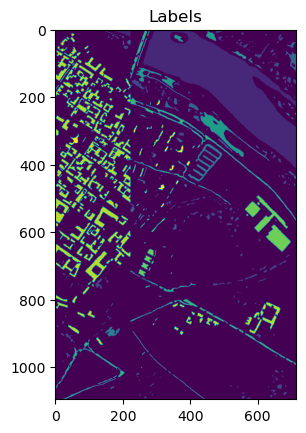

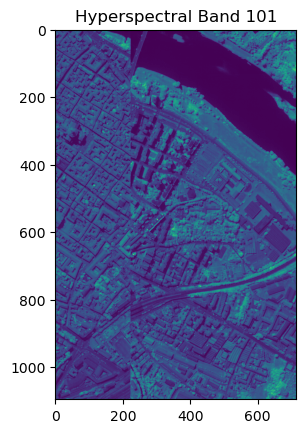

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 20 train


 -- Test set created with: 
	147927 samples
	shape (147927, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(180, 5, 5, 102)
(45, 5, 5, 102)
(147927, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1708, PSNR: 4.4165


	 Training Batch [200/1852], Loss: 0.1070, PSNR: 6.7465


	 Training Batch [400/1852], Loss: 0.0441, PSNR: 9.4382


	 Training Batch [600/1852], Loss: 0.0287, PSNR: 12.1156


	 Training Batch [800/1852], Loss: 0.0153, PSNR: 14.7636


	 Training Batch [1000/1852], Loss: 0.0108, PSNR: 15.1640


	 Training Batch [1200/1852], Loss: 0.0095, PSNR: 16.8462


	 Training Batch [1400/1852], Loss: 0.0095, PSNR: 17.0009


	 Training Batch [1600/1852], Loss: 0.0080, PSNR: 17.5671


	 Training Batch [1800/1852], Loss: 0.0056, PSNR: 18.8860


Epoch [1/50] Training Loss: 0.0322, PSNR: 13.7127
	[Val]   Batch [1/463] Loss: 0.0053, PSNR: 18.0195
	[Val]   Batch [10/463] Loss: 0.0049, PSNR: 19.1863
	[Val]   Batch [20/463] Loss: 0.0049, PSNR: 18.1780
	[Val]   Batch [30/463] Loss: 0.0060, PSNR: 18.7048
	[Val]   Batch [40/463] Loss: 0.0047, PSNR: 17.8723
	[Val]   Batch [50/463] Loss: 0.0050, PSNR: 18.0823


	[Val]   Batch [60/463] Loss: 0.0047, PSNR: 18.1254
	[Val]   Batch [70/463] Loss: 0.0067, PSNR: 18.4427
	[Val]   Batch [80/463] Loss: 0.0060, PSNR: 20.3618
	[Val]   Batch [90/463] Loss: 0.0058, PSNR: 19.4558
	[Val]   Batch [100/463] Loss: 0.0059, PSNR: 19.1572
	[Val]   Batch [110/463] Loss: 0.0068, PSNR: 18.5698
	[Val]   Batch [120/463] Loss: 0.0046, PSNR: 18.1217


	[Val]   Batch [130/463] Loss: 0.0054, PSNR: 19.4820
	[Val]   Batch [140/463] Loss: 0.0064, PSNR: 19.0114
	[Val]   Batch [150/463] Loss: 0.0072, PSNR: 19.0426
	[Val]   Batch [160/463] Loss: 0.0058, PSNR: 19.3198
	[Val]   Batch [170/463] Loss: 0.0075, PSNR: 18.2430
	[Val]   Batch [180/463] Loss: 0.0054, PSNR: 19.0518
	[Val]   Batch [190/463] Loss: 0.0059, PSNR: 19.3880
	[Val]   Batch [200/463] Loss: 0.0059, PSNR: 18.7701


	[Val]   Batch [210/463] Loss: 0.0057, PSNR: 18.3635
	[Val]   Batch [220/463] Loss: 0.0056, PSNR: 19.5912
	[Val]   Batch [230/463] Loss: 0.0067, PSNR: 19.4003
	[Val]   Batch [240/463] Loss: 0.0050, PSNR: 18.2400
	[Val]   Batch [250/463] Loss: 0.0065, PSNR: 17.3859
	[Val]   Batch [260/463] Loss: 0.0056, PSNR: 18.4314
	[Val]   Batch [270/463] Loss: 0.0043, PSNR: 17.6495
	[Val]   Batch [280/463] Loss: 0.0053, PSNR: 20.3116


	[Val]   Batch [290/463] Loss: 0.0059, PSNR: 17.3023
	[Val]   Batch [300/463] Loss: 0.0059, PSNR: 19.5616
	[Val]   Batch [310/463] Loss: 0.0054, PSNR: 19.4686
	[Val]   Batch [320/463] Loss: 0.0055, PSNR: 19.3196
	[Val]   Batch [330/463] Loss: 0.0064, PSNR: 18.7046
	[Val]   Batch [340/463] Loss: 0.0052, PSNR: 19.6671
	[Val]   Batch [350/463] Loss: 0.0069, PSNR: 19.5561
	[Val]   Batch [360/463] Loss: 0.0046, PSNR: 20.5544


	[Val]   Batch [370/463] Loss: 0.0068, PSNR: 18.6280
	[Val]   Batch [380/463] Loss: 0.0067, PSNR: 18.7835
	[Val]   Batch [390/463] Loss: 0.0061, PSNR: 18.6074
	[Val]   Batch [400/463] Loss: 0.0054, PSNR: 17.6788
	[Val]   Batch [410/463] Loss: 0.0052, PSNR: 20.0092
	[Val]   Batch [420/463] Loss: 0.0055, PSNR: 18.7763
	[Val]   Batch [430/463] Loss: 0.0053, PSNR: 18.2179
	[Val]   Batch [440/463] Loss: 0.0052, PSNR: 19.2169


	[Val]   Batch [450/463] Loss: 0.0040, PSNR: 16.6089
	[Val]   Batch [460/463] Loss: 0.0057, PSNR: 17.9378
Epoch [1/50] Validation Loss: 0.0057, PSNR: 18.7583

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0056, PSNR: 19.4111


	 Training Batch [200/1852], Loss: 0.0068, PSNR: 18.2129


	 Training Batch [400/1852], Loss: 0.0054, PSNR: 18.4660


	 Training Batch [600/1852], Loss: 0.0041, PSNR: 18.6561


	 Training Batch [800/1852], Loss: 0.0035, PSNR: 19.6861


	 Training Batch [1000/1852], Loss: 0.0037, PSNR: 20.9669


	 Training Batch [1200/1852], Loss: 0.0045, PSNR: 20.2461


	 Training Batch [1400/1852], Loss: 0.0045, PSNR: 21.1271


	 Training Batch [1600/1852], Loss: 0.0047, PSNR: 20.2847


	 Training Batch [1800/1852], Loss: 0.0025, PSNR: 22.4413


Epoch [2/50] Training Loss: 0.0044, PSNR: 20.0020
	[Val]   Batch [1/463] Loss: 0.0027, PSNR: 20.8673
	[Val]   Batch [10/463] Loss: 0.0025, PSNR: 22.1396
	[Val]   Batch [20/463] Loss: 0.0025, PSNR: 21.2103
	[Val]   Batch [30/463] Loss: 0.0033, PSNR: 21.3570
	[Val]   Batch [40/463] Loss: 0.0024, PSNR: 20.7897
	[Val]   Batch [50/463] Loss: 0.0025, PSNR: 20.9866
	[Val]   Batch [60/463] Loss: 0.0024, PSNR: 21.0734


	[Val]   Batch [70/463] Loss: 0.0037, PSNR: 21.0189
	[Val]   Batch [80/463] Loss: 0.0033, PSNR: 22.9725
	[Val]   Batch [90/463] Loss: 0.0030, PSNR: 22.2874
	[Val]   Batch [100/463] Loss: 0.0033, PSNR: 21.7114
	[Val]   Batch [110/463] Loss: 0.0037, PSNR: 21.2186
	[Val]   Batch [120/463] Loss: 0.0023, PSNR: 21.0425
	[Val]   Batch [130/463] Loss: 0.0028, PSNR: 22.3566
	[Val]   Batch [140/463] Loss: 0.0035, PSNR: 21.6400


	[Val]   Batch [150/463] Loss: 0.0039, PSNR: 21.7377
	[Val]   Batch [160/463] Loss: 0.0032, PSNR: 21.9121
	[Val]   Batch [170/463] Loss: 0.0042, PSNR: 20.7565
	[Val]   Batch [180/463] Loss: 0.0031, PSNR: 21.5121
	[Val]   Batch [190/463] Loss: 0.0031, PSNR: 22.1961
	[Val]   Batch [200/463] Loss: 0.0031, PSNR: 21.5150
	[Val]   Batch [210/463] Loss: 0.0032, PSNR: 20.8252


	[Val]   Batch [220/463] Loss: 0.0030, PSNR: 22.2914
	[Val]   Batch [230/463] Loss: 0.0036, PSNR: 22.0923
	[Val]   Batch [240/463] Loss: 0.0026, PSNR: 21.0421
	[Val]   Batch [250/463] Loss: 0.0036, PSNR: 19.9822
	[Val]   Batch [260/463] Loss: 0.0030, PSNR: 21.0903
	[Val]   Batch [270/463] Loss: 0.0021, PSNR: 20.8063
	[Val]   Batch [280/463] Loss: 0.0027, PSNR: 23.1502
	[Val]   Batch [290/463] Loss: 0.0031, PSNR: 20.1441


	[Val]   Batch [300/463] Loss: 0.0032, PSNR: 22.2718
	[Val]   Batch [310/463] Loss: 0.0030, PSNR: 22.0782
	[Val]   Batch [320/463] Loss: 0.0029, PSNR: 22.0231
	[Val]   Batch [330/463] Loss: 0.0033, PSNR: 21.5553
	[Val]   Batch [340/463] Loss: 0.0028, PSNR: 22.4332
	[Val]   Batch [350/463] Loss: 0.0039, PSNR: 22.0146
	[Val]   Batch [360/463] Loss: 0.0025, PSNR: 23.1887


	[Val]   Batch [370/463] Loss: 0.0036, PSNR: 21.3364
	[Val]   Batch [380/463] Loss: 0.0035, PSNR: 21.6373
	[Val]   Batch [390/463] Loss: 0.0032, PSNR: 21.4245
	[Val]   Batch [400/463] Loss: 0.0029, PSNR: 20.3608
	[Val]   Batch [410/463] Loss: 0.0026, PSNR: 22.9606
	[Val]   Batch [420/463] Loss: 0.0029, PSNR: 21.5434
	[Val]   Batch [430/463] Loss: 0.0029, PSNR: 20.8844


	[Val]   Batch [440/463] Loss: 0.0028, PSNR: 21.8981
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.6017
	[Val]   Batch [460/463] Loss: 0.0030, PSNR: 20.7863
Epoch [2/50] Validation Loss: 0.0030, PSNR: 21.5322

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0036, PSNR: 21.0126


	 Training Batch [200/1852], Loss: 0.0025, PSNR: 21.7540


	 Training Batch [400/1852], Loss: 0.0028, PSNR: 21.6220


	 Training Batch [600/1852], Loss: 0.0028, PSNR: 21.4244


	 Training Batch [800/1852], Loss: 0.0026, PSNR: 21.0463


	 Training Batch [1000/1852], Loss: 0.0020, PSNR: 22.5015


	 Training Batch [1200/1852], Loss: 0.0018, PSNR: 22.8743


	 Training Batch [1400/1852], Loss: 0.0031, PSNR: 22.2257


	 Training Batch [1600/1852], Loss: 0.0019, PSNR: 24.2480


	 Training Batch [1800/1852], Loss: 0.0017, PSNR: 23.6148


Epoch [3/50] Training Loss: 0.0024, PSNR: 22.6072
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.5003
	[Val]   Batch [10/463] Loss: 0.0013, PSNR: 24.8054
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.9600
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.3946
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.0600
	[Val]   Batch [50/463] Loss: 0.0014, PSNR: 23.4524
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.4402


	[Val]   Batch [70/463] Loss: 0.0018, PSNR: 24.0705
	[Val]   Batch [80/463] Loss: 0.0016, PSNR: 26.0500
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 25.0903
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.5676
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.3603
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.3247
	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.4135
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.5462


	[Val]   Batch [150/463] Loss: 0.0018, PSNR: 25.2083
	[Val]   Batch [160/463] Loss: 0.0018, PSNR: 24.3095
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.5853
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.0770
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 25.1463
	[Val]   Batch [200/463] Loss: 0.0015, PSNR: 24.5685
	[Val]   Batch [210/463] Loss: 0.0019, PSNR: 23.2146


	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.7599
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.7038
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.6916
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.6114
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6288
	[Val]   Batch [270/463] Loss: 0.0012, PSNR: 23.0990
	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.7851
	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 22.9227


	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.8421
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.3475
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.7218
	[Val]   Batch [330/463] Loss: 0.0016, PSNR: 24.7270
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.0611
	[Val]   Batch [350/463] Loss: 0.0020, PSNR: 24.8562
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.8705


	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.4567
	[Val]   Batch [380/463] Loss: 0.0015, PSNR: 25.1377
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.7265
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.7132
	[Val]   Batch [410/463] Loss: 0.0014, PSNR: 25.7273
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.3826
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.1510
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.3278


	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.4454
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.4904
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.2856

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0019, PSNR: 24.2506


	 Training Batch [200/1852], Loss: 0.0015, PSNR: 24.2091


	 Training Batch [400/1852], Loss: 0.0018, PSNR: 23.8024


	 Training Batch [600/1852], Loss: 0.0016, PSNR: 25.1086


	 Training Batch [800/1852], Loss: 0.0015, PSNR: 25.0778


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 25.1733


	 Training Batch [1200/1852], Loss: 0.0016, PSNR: 25.6962


	 Training Batch [1400/1852], Loss: 0.0013, PSNR: 25.4232


	 Training Batch [1600/1852], Loss: 0.0015, PSNR: 23.6918


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 25.4822


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.3722
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.8791
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.2125
	[Val]   Batch [20/463] Loss: 0.0009, PSNR: 25.3959
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.8454
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.3419
	[Val]   Batch [50/463] Loss: 0.0010, PSNR: 24.8344


	[Val]   Batch [60/463] Loss: 0.0010, PSNR: 24.7771
	[Val]   Batch [70/463] Loss: 0.0013, PSNR: 25.5340
	[Val]   Batch [80/463] Loss: 0.0011, PSNR: 27.7282
	[Val]   Batch [90/463] Loss: 0.0011, PSNR: 26.5419
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 26.0698
	[Val]   Batch [110/463] Loss: 0.0012, PSNR: 25.9362
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.6926


	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.8959
	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.9835
	[Val]   Batch [150/463] Loss: 0.0012, PSNR: 26.7950
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.5669
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 24.9314
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.4096
	[Val]   Batch [190/463] Loss: 0.0011, PSNR: 26.5621


	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.1537
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4781
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 26.0602
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.4047
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.1254
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.9005


	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.8851
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.4802
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.1682
	[Val]   Batch [290/463] Loss: 0.0011, PSNR: 24.3987
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.1044
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.6282
	[Val]   Batch [320/463] Loss: 0.0011, PSNR: 26.2053


	[Val]   Batch [330/463] Loss: 0.0011, PSNR: 26.2463
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.4862
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.2824
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.8590
	[Val]   Batch [370/463] Loss: 0.0012, PSNR: 26.0091
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.7977
	[Val]   Batch [390/463] Loss: 0.0010, PSNR: 26.3307


	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.9859
	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.1898
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.7738
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.3560
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.7136
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.7299
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.8342
Epoch [4/50] Validation Loss: 0.0011, PSNR: 25.7193

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0013, PSNR: 25.6807


	 Training Batch [200/1852], Loss: 0.0017, PSNR: 23.7748


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 24.1591


	 Training Batch [600/1852], Loss: 0.0012, PSNR: 24.8900


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.6646


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 26.0148


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 24.8111


	 Training Batch [1400/1852], Loss: 0.0012, PSNR: 26.2101


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 22.3007


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 26.3921


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.4961
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.6724
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.0397
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.2172
	[Val]   Batch [30/463] Loss: 0.0010, PSNR: 26.7046
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.1356
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.6990
	[Val]   Batch [60/463] Loss: 0.0009, PSNR: 25.5235


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.3586
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.7648
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.4289
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9792
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.8713
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.5723
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7004
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.9087


	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.6817
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.3539
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.7618
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.2985
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.4080
	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 27.0688
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.3521
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 26.9220


	[Val]   Batch [230/463] Loss: 0.0009, PSNR: 28.3502
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.0115
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.7278
	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.6270
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.4604
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.0764
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.2531


	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.7738
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.5461
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.1614
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.0968
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.3798
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.1262
	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.4889
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.8810


	[Val]   Batch [380/463] Loss: 0.0009, PSNR: 27.6768
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.2353
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8163
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 27.9729
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.5716
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.1424
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.6000


	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.6418
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.6489
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.5846

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 27.1807


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 24.9317


	 Training Batch [400/1852], Loss: 0.0014, PSNR: 26.0382


	 Training Batch [600/1852], Loss: 0.0012, PSNR: 26.7460


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 26.6138


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 24.6720


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 27.1750


	 Training Batch [1400/1852], Loss: 0.0010, PSNR: 26.8794


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 25.2428


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 26.0834


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.3345
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.7591
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.2441
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.4492
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 27.7988
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.1800
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.8806
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.5824


	[Val]   Batch [70/463] Loss: 0.0008, PSNR: 27.4729
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.0541
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.5854
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.0835
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 28.0560
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 26.7382
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.8400
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.0390


	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 28.9744
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.4152
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.7619
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.3936
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.5803
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.3453
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.4097
	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 27.9525


	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 29.5457
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.1457
	[Val]   Batch [250/463] Loss: 0.0009, PSNR: 25.8411
	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 26.6886
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.7662
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.2179
	[Val]   Batch [290/463] Loss: 0.0007, PSNR: 26.4465


	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.8455
	[Val]   Batch [310/463] Loss: 0.0008, PSNR: 27.6721
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.3751
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.2813
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.5644
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 28.1570
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.3013


	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 28.0926
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 29.0546
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.4706
	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.8811
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.1188
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.7816
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 26.1586


	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.6290
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.7625
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 26.8258
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.7513

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 25.6048


	 Training Batch [200/1852], Loss: 0.0015, PSNR: 25.1429


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 26.0034


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 26.9155


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 27.5712


	 Training Batch [1000/1852], Loss: 0.0011, PSNR: 25.6868


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 27.4711


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 25.7730


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 25.8487


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.4921


Epoch [7/50] Training Loss: 0.0009, PSNR: 27.0064
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.4703
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.0101
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.2388
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.4800
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.9071
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 27.7197


	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.2755
	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.1950
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.8695
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.3429
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.8367
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 28.7883
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.4293
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.5382


	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.7147
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.7687
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 28.1644
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.4762
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.1646
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.2912
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.1086


	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.1734
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.6141
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.2662
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 27.9416
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.5918
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.4688
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.5299
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.9263


	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.2089
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.3598
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.3909
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.1963
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 29.0330
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.3026
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.9210
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.7968


	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.8179
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.8397
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.2010
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.5628
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 29.8124
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.5300
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.9341


	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.2573
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.5075
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.5769
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.4970

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.7921


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.2866


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.0907


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.5090


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 27.7917


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 26.9760


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 26.7085


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.2984


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.8773


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 26.1513


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.6098
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.0530
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.6553
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.8886
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.1223
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.5045
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.4161
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.8539


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.9090
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.5882
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.0161
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.5281
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.4864
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.0113
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.1598


	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.3433
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.5385
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 28.8748
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.1606
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.7732
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.9425
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.7744


	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 27.8542
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.2337
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.8726
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.5978
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.2637
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.1799
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.2330


	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.5665
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.8938
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.8896
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.0819
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.9113
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.7284
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.9593
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.6296


	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.1894
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.5016
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.5366
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.8408
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.1773
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.4319
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.1621
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.6041


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.8408
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.1286
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.2780
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.1570

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 26.4894


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 27.6289


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 28.9588


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 29.6118


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 29.0297


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 30.1650


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.0263


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.9569


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.1697


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 27.1891


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.1264
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.7265
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.3839
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.5793
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.7990
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.1675
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.0973
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.5816


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.5810
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.3833
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.6847
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.2565
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.2577
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.7445
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.8661


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.0470
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.3561
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.6762
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.7753
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.4912
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.5307
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.5241


	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.6684
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.9070
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.5919
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.3052
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.9297
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.9749
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.0657


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.2615
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.6419
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.5836
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.8418
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.6463
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.4511
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.7347


	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.3429
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6659
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.1779
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.2875
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.5848
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.7784
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.0627
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.8466


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.2176
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.4223
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.9133
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.0337
Epoch [9/50] Validation Loss: 0.0004, PSNR: 29.8711

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.2506


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.3518


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 26.8048


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.6068


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.4698


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.5035


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 27.6991


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.6179


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.4350


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.5570


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.5311
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.1874
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.9131
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.1264
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.3302
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.6221
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.6814
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.0462


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.1818
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.9386
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.2323
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.7475
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.7904
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.1765
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.3342
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.5322


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.9778
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.2602
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.3382
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.0228
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.0155
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.0594
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.2298


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.3131
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 32.1443
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 29.8559
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.5412
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.6242
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.5296
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.7356
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.1746


	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.1311
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.3441
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.1516
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.0075
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.2265
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.8935
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9641
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.7620


	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.9141
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.1344
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.2692
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.5927
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.3701
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.7373
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 29.9774
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.3486


	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.6197
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.3983

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.4866


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 28.5620


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 30.1997


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 26.9585


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.6767


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 28.1603


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.6052


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 25.9912


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 27.9379


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.9744


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.8462
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.2127
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.9218
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.2130
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.3097
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.6776
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.8055
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.1815


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.2578
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.8322
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.2365
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.7120
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.7606
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.0691
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.3827


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.4688
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 32.0695
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.4762
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.5611
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.0935
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.0751
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 31.0113


	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.3116
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.2157
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 32.0832
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 29.9264
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.7077
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.8594
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.4130
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.7168


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.1437
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.1234
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.2735
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.1614
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.0267
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.2282
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.9162


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9440
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.8404
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.9792
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.0745
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.2922
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.6256
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.4442
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.8326
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 29.8687


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.2236
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.7625
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.4235

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.6244


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 28.8066


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.2946


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.8752


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.9558


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 30.8951


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.9311


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.3359


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.3884


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.6967


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1821
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.8797
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6130
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.8731
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.0715
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.3200
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.4561
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.8274


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.0441
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.7799
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.0123
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.5508
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.6477
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.8014
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.1762


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.2224
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.9064
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.2256
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.2161
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.8450
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.7166
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.8487
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.0917


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.9735
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.9518
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.5983
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.3627
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.5521
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2729
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.4711
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.9820


	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.8484
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.0655
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.9953
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.8072
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.0213
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.7113
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4020


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.5584
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.8024
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.8310
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.9064
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.1967
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0769
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.4825


	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.6254
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.0958
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.3406
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.1765

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 29.1740


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 31.2929


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 30.1294


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.0657


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 30.9677


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 29.0405


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 31.2949


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 30.2359


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 30.2844


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 30.1939


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.4349
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.2689
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 32.0557
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.2038
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.5441
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.6684
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.8883


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.2579
	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.5169
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.1721
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.4085
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.9242
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.0126
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.2025
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.5499


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.6786
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.3960
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.6749
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5630
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.1570
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.0843
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.1886
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5753


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.3282
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.4552
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.0342
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.7651
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.0305
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.6536
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.8179


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.4452
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3215
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.3995
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.3516
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.2233
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.4302
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.1069
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6424


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.9643
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.2728
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.2837
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.2444
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.5636
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.5037
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.8123
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.9567


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.5092
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.8215
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.5774

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 25.0421


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 30.1899


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.3753


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 29.7118


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 27.3279


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 28.0248


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 30.4025


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 28.1188


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.7483


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 31.3167


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.6850
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.4745
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.2822
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.4337
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.7510
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.8973
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.1007


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.5249
	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.8250
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.3878
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.6467
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.1936
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.3036
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.3795
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.7903


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.8528
	[Val]   Batch [150/463] Loss: 0.0002, PSNR: 33.6655
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.9884
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.8392
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.4357
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.2619
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.3931
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.8449


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.5203
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.6578
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.3008
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 30.0182
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.3246
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.8173
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.0198
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.7379


	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.4103
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.6044
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.5923
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.4675
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.6698
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.3687
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.7523
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.2483


	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.5187
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.4799
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.4764
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.7228
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6536
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9692
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.2000


	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.7248
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.9993
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.8080

LOG: Epoch [15/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 29.9954


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 29.5552


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.1146


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 31.1155


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.3203


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.6302


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.5918


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.5179


	 Training Batch [1600/1852], Loss: 0.0003, PSNR: 31.3066


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 33.1775


Epoch [15/50] Training Loss: 0.0004, PSNR: 29.9181
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.7104
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.4893
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.6428
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.9940
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 30.1858
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.4889
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.8012


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 32.0767
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.5858
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.8677
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.4049
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.5155
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.6414
	[Val]   Batch [130/463] Loss: 0.0002, PSNR: 33.0420


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.1504
	[Val]   Batch [150/463] Loss: 0.0002, PSNR: 33.8920
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 32.3242
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 31.1537
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.7319
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.4609
	[Val]   Batch [200/463] Loss: 0.0002, PSNR: 32.6552


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 31.1501
	[Val]   Batch [220/463] Loss: 0.0003, PSNR: 31.7454
	[Val]   Batch [230/463] Loss: 0.0002, PSNR: 33.8795
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.5702
	[Val]   Batch [250/463] Loss: 0.0003, PSNR: 30.3526
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.6355
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 31.2060


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.2714
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.9545
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.7414
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.9034
	[Val]   Batch [320/463] Loss: 0.0002, PSNR: 32.8648
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.7145
	[Val]   Batch [340/463] Loss: 0.0002, PSNR: 32.9347
	[Val]   Batch [350/463] Loss: 0.0003, PSNR: 32.5818


	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.9600
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.5128
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.8347
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.6489
	[Val]   Batch [400/463] Loss: 0.0003, PSNR: 29.7662
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.9499
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.9996
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.3317


	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.3763
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 29.0371
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 31.3058
Epoch [15/50] Validation Loss: 0.0003, PSNR: 32.0751
Early stopping triggered at epoch 15. No improvement for 3 epochs.


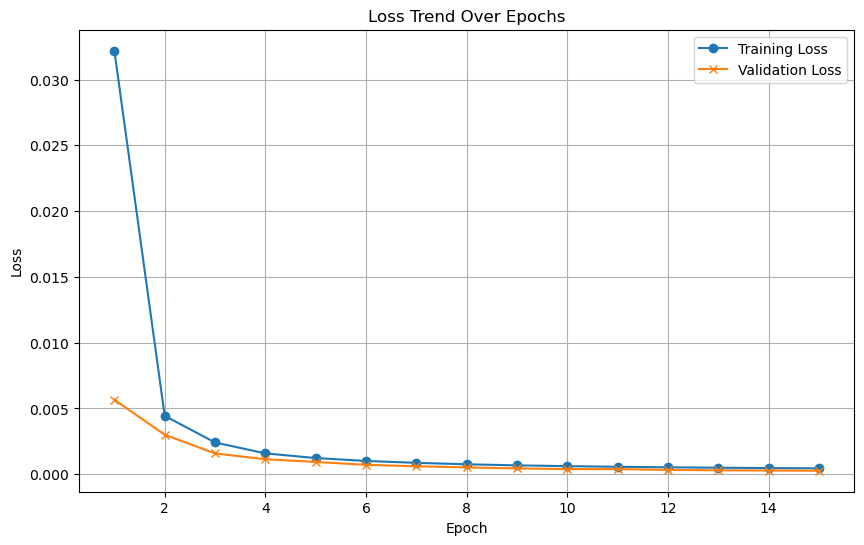

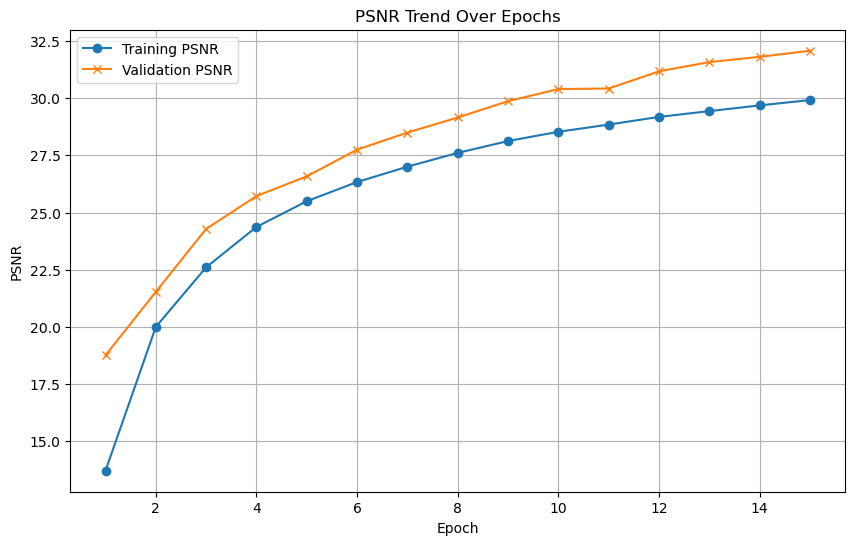

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1804
    Validation Batch [1/1], Loss: 2.2006
Validation Loss: 2.2006, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2006. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1296
    Validation Batch [1/1], Loss: 2.2005
Validation Loss: 2.2005, Validation Accuracy: 11.11%
Validation loss improved from 2.2006 to 2.2005. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1060
    Validation Batch [1/1], Loss: 2.2004
Validation Loss: 2.2004, Validation Accuracy: 11.11%
Validation loss improved from 2.2005 to 2.2004. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0780
    Validation Batch [1/1], Loss: 2.2003
Validation Loss: 2.2003, Validation Accuracy: 11.11%
Validation loss improved from 2.2004 to 2.2003. Saving model...

LOG: Epoch [5/1000

Epoch [9/1000] completed, Average Training Loss: 1.9679
    Validation Batch [1/1], Loss: 2.1999
Validation Loss: 2.1999, Validation Accuracy: 11.11%
Validation loss improved from 2.2001 to 2.1999. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 1.9484
    Validation Batch [1/1], Loss: 2.1997
Validation Loss: 2.1997, Validation Accuracy: 11.11%
Validation loss improved from 2.1999 to 2.1997. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 1.9390
    Validation Batch [1/1], Loss: 2.1995
Validation Loss: 2.1995, Validation Accuracy: 11.11%
Validation loss improved from 2.1997 to 2.1995. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 1.9228
    Validation Batch [1/1], Loss: 2.1992
Validation Loss: 2.1992, Validation Accuracy: 11.11%
Validation loss improved from 2.1995 to 2.1992. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13

    Validation Batch [1/1], Loss: 2.0894
Validation Loss: 2.0894, Validation Accuracy: 40.00%
Validation loss improved from 2.1055 to 2.0894. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.6076
    Validation Batch [1/1], Loss: 2.0726
Validation Loss: 2.0726, Validation Accuracy: 46.67%
Validation loss improved from 2.0894 to 2.0726. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.5765
    Validation Batch [1/1], Loss: 2.0531
Validation Loss: 2.0531, Validation Accuracy: 53.33%
Validation loss improved from 2.0726 to 2.0531. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.5932
    Validation Batch [1/1], Loss: 2.0314
Validation Loss: 2.0314, Validation Accuracy: 53.33%
Validation loss improved from 2.0531 to 2.0314. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.5758
    Vali

Epoch [68/1000] completed, Average Training Loss: 1.3522
    Validation Batch [1/1], Loss: 1.4016
Validation Loss: 1.4016, Validation Accuracy: 84.44%
Validation loss improved from 1.4184 to 1.4016. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.3331
    Validation Batch [1/1], Loss: 1.3864
Validation Loss: 1.3864, Validation Accuracy: 84.44%
Validation loss improved from 1.4016 to 1.3864. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.3417
    Validation Batch [1/1], Loss: 1.3730
Validation Loss: 1.3730, Validation Accuracy: 86.67%
Validation loss improved from 1.3864 to 1.3730. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.3440
    Validation Batch [1/1], Loss: 1.3600
Validation Loss: 1.3600, Validation Accuracy: 86.67%
Validation loss improved from 1.3730 to 1.3600. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 1.0578
Validation Loss: 1.0578, Validation Accuracy: 86.67%
Validation loss improved from 1.0732 to 1.0578. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.0868
    Validation Batch [1/1], Loss: 1.0438
Validation Loss: 1.0438, Validation Accuracy: 86.67%
Validation loss improved from 1.0578 to 1.0438. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.0587
    Validation Batch [1/1], Loss: 1.0331
Validation Loss: 1.0331, Validation Accuracy: 86.67%
Validation loss improved from 1.0438 to 1.0331. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.0449
    Validation Batch [1/1], Loss: 1.0299
Validation Loss: 1.0299, Validation Accuracy: 84.44%
Validation loss improved from 1.0331 to 1.0299. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.0531
  

    Validation Batch [1/1], Loss: 0.8339
Validation Loss: 0.8339, Validation Accuracy: 86.67%
Validation loss improved from 0.8422 to 0.8339. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.8242
    Validation Batch [1/1], Loss: 0.8160
Validation Loss: 0.8160, Validation Accuracy: 86.67%
Validation loss improved from 0.8339 to 0.8160. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 0.8421
    Validation Batch [1/1], Loss: 0.7993
Validation Loss: 0.7993, Validation Accuracy: 86.67%
Validation loss improved from 0.8160 to 0.7993. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 0.8639
    Validation Batch [1/1], Loss: 0.7918
Validation Loss: 0.7918, Validation Accuracy: 88.89%
Validation loss improved from 0.7993 to 0.7918. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 0.8091


Epoch [155/1000] completed, Average Training Loss: 0.6420
    Validation Batch [1/1], Loss: 0.6331
Validation Loss: 0.6331, Validation Accuracy: 88.89%
Validation loss improved from 0.6353 to 0.6331. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.6467
    Validation Batch [1/1], Loss: 0.6264
Validation Loss: 0.6264, Validation Accuracy: 91.11%
Validation loss improved from 0.6331 to 0.6264. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.6509
    Validation Batch [1/1], Loss: 0.6132
Validation Loss: 0.6132, Validation Accuracy: 93.33%
Validation loss improved from 0.6264 to 0.6132. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.6244
    Validation Batch [1/1], Loss: 0.6036
Validation Loss: 0.6036, Validation Accuracy: 88.89%
Validation loss improved from 0.6132 to 0.6036. Saving model...

LOG: Epoch [159/1000] - Training


    Validation Batch [1/1], Loss: 0.4621
Validation Loss: 0.4621, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.4886
    Validation Batch [1/1], Loss: 0.4707
Validation Loss: 0.4707, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.4518
    Validation Batch [1/1], Loss: 0.4651
Validation Loss: 0.4651, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.4730
    Validation Batch [1/1], Loss: 0.4498
Validation Loss: 0.4498, Validation Accuracy: 93.33%
Validation loss improved from 0.4588 to 0.4498. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.5006
    Validation Batch [1/1], Loss: 0.4385
Vali


LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.3533
    Validation Batch [1/1], Loss: 0.3370
Validation Loss: 0.3370, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.3648
    Validation Batch [1/1], Loss: 0.3368
Validation Loss: 0.3368, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.3689
    Validation Batch [1/1], Loss: 0.3343
Validation Loss: 0.3343, Validation Accuracy: 97.78%
Validation loss improved from 0.3364 to 0.3343. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.3291
    Validation Batch [1/1], Loss: 0.3386
Validation Loss: 0.3386, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [219/1000] - Training
Epoch [219/

Epoch [243/1000] completed, Average Training Loss: 0.2588
    Validation Batch [1/1], Loss: 0.2642
Validation Loss: 0.2642, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.2390
    Validation Batch [1/1], Loss: 0.2770
Validation Loss: 0.2770, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.2544
    Validation Batch [1/1], Loss: 0.2775
Validation Loss: 0.2775, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.2697
    Validation Batch [1/1], Loss: 0.2652
Validation Loss: 0.2652, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.2435
  

Epoch [271/1000] completed, Average Training Loss: 0.2088
    Validation Batch [1/1], Loss: 0.2252
Validation Loss: 0.2252, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.1906
    Validation Batch [1/1], Loss: 0.2155
Validation Loss: 0.2155, Validation Accuracy: 97.78%
Validation loss improved from 0.2180 to 0.2155. Saving model...

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.1909
    Validation Batch [1/1], Loss: 0.2142
Validation Loss: 0.2142, Validation Accuracy: 97.78%
Validation loss improved from 0.2155 to 0.2142. Saving model...

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.1829
    Validation Batch [1/1], Loss: 0.2184
Validation Loss: 0.2184, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Av

Epoch [300/1000] completed, Average Training Loss: 0.1528
    Validation Batch [1/1], Loss: 0.1871
Validation Loss: 0.1871, Validation Accuracy: 97.78%
Validation loss improved from 0.1873 to 0.1871. Saving model...

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.1456
    Validation Batch [1/1], Loss: 0.1884
Validation Loss: 0.1884, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.1470
    Validation Batch [1/1], Loss: 0.1878
Validation Loss: 0.1878, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.1701
    Validation Batch [1/1], Loss: 0.1880
Validation Loss: 0.1880, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training 

Epoch [330/1000] completed, Average Training Loss: 0.1225
    Validation Batch [1/1], Loss: 0.1638
Validation Loss: 0.1638, Validation Accuracy: 97.78%
Validation loss improved from 0.1650 to 0.1638. Saving model...

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.1033
    Validation Batch [1/1], Loss: 0.1656
Validation Loss: 0.1656, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.1155
    Validation Batch [1/1], Loss: 0.1727
Validation Loss: 0.1727, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.1214
    Validation Batch [1/1], Loss: 0.1782
Validation Loss: 0.1782, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training 

Epoch [360/1000] completed, Average Training Loss: 0.1067
    Validation Batch [1/1], Loss: 0.1485
Validation Loss: 0.1485, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.1055
    Validation Batch [1/1], Loss: 0.1490
Validation Loss: 0.1490, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.0856
    Validation Batch [1/1], Loss: 0.1457
Validation Loss: 0.1457, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.0960
    Validation Batch [1/1], Loss: 0.1444
Validation Loss: 0.1444, Validation Accuracy: 97.78%
Validation loss improved from 0.1454 to 0.1444. Saving model...

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training 

Epoch [391/1000] completed, Average Training Loss: 0.0731
    Validation Batch [1/1], Loss: 0.1380
Validation Loss: 0.1380, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.0816
    Validation Batch [1/1], Loss: 0.1456
Validation Loss: 0.1456, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.0760
    Validation Batch [1/1], Loss: 0.1597
Validation Loss: 0.1597, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.0811
    Validation Batch [1/1], Loss: 0.1759
Validation Loss: 0.1759, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.0973
  

    Validation Batch [1/1], Loss: 0.1467
Validation Loss: 0.1467, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.0652
    Validation Batch [1/1], Loss: 0.1447
Validation Loss: 0.1447, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.0711
    Validation Batch [1/1], Loss: 0.1438
Validation Loss: 0.1438, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.0589
    Validation Batch [1/1], Loss: 0.1416
Validation Loss: 0.1416, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.0615
    Validation Batch [1/1], Loss: 0.1390
Validation Loss: 0

Epoch [451/1000] completed, Average Training Loss: 0.0560
    Validation Batch [1/1], Loss: 0.1296
Validation Loss: 0.1296, Validation Accuracy: 97.78%
Validation loss improved from 0.1323 to 0.1296. Saving model...

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0519
    Validation Batch [1/1], Loss: 0.1283
Validation Loss: 0.1283, Validation Accuracy: 97.78%
Validation loss improved from 0.1296 to 0.1283. Saving model...

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0555
    Validation Batch [1/1], Loss: 0.1284
Validation Loss: 0.1284, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0451
    Validation Batch [1/1], Loss: 0.1320
Validation Loss: 0.1320, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Av

Epoch [482/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.1300
Validation Loss: 0.1300, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0545
    Validation Batch [1/1], Loss: 0.1301
Validation Loss: 0.1301, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0422
    Validation Batch [1/1], Loss: 0.1347
Validation Loss: 0.1347, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.0463
    Validation Batch [1/1], Loss: 0.1440
Validation Loss: 0.1440, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.0475


Epoch [513/1000] completed, Average Training Loss: 0.0352
    Validation Batch [1/1], Loss: 0.1319
Validation Loss: 0.1319, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.1339
Validation Loss: 0.1339, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0437
    Validation Batch [1/1], Loss: 0.1386
Validation Loss: 0.1386, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0417
    Validation Batch [1/1], Loss: 0.1438
Validation Loss: 0.1438, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.037

Epoch [543/1000] completed, Average Training Loss: 0.0285
    Validation Batch [1/1], Loss: 0.1571
Validation Loss: 0.1571, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0339
    Validation Batch [1/1], Loss: 0.1450
Validation Loss: 0.1450, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0365
    Validation Batch [1/1], Loss: 0.1330
Validation Loss: 0.1330, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0442
    Validation Batch [1/1], Loss: 0.1294
Validation Loss: 0.1294, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.047

Epoch [572/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.1288
Validation Loss: 0.1288, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0348
    Validation Batch [1/1], Loss: 0.1281
Validation Loss: 0.1281, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.1277
Validation Loss: 0.1277, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 574. No improvement for 100 epochs.
Loading the best model weights...


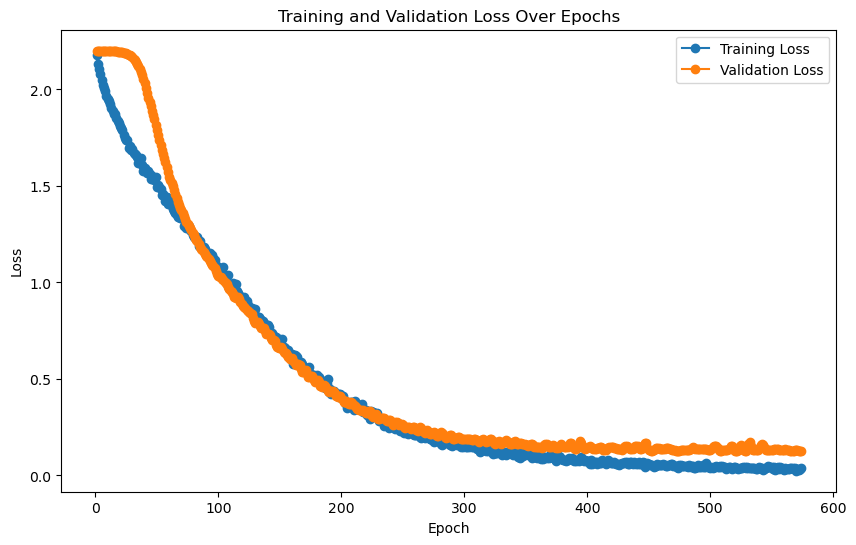

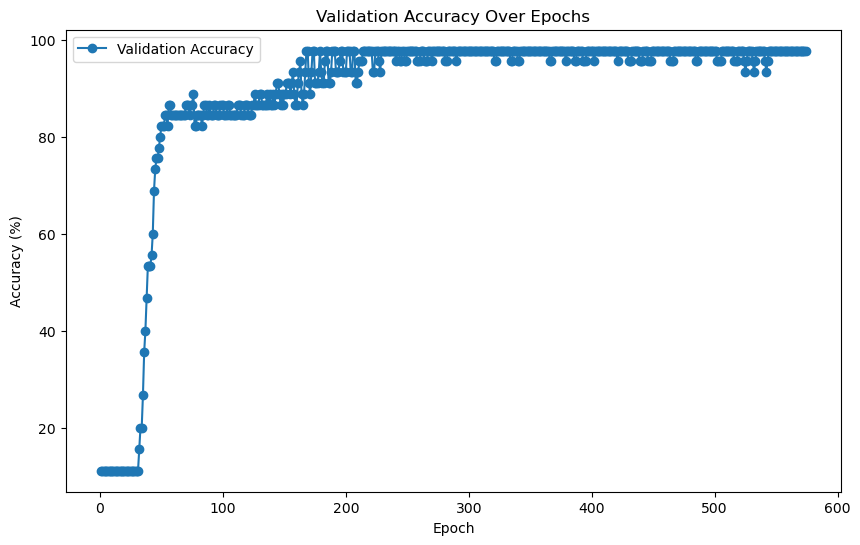


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.0430



Final Test Loss: 0.0945, Test Accuracy: 97.70%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.


  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.


  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.


  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147927, 64), Test labels shape: (147927,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       0.83      1.00      0.91         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00    

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147927, 64)
Test labels shape: (147927,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1721  |  Val Loss: 1.9759
Validation loss improved from inf to 1.9759.


[Epoch 2/1000] Train Loss: 1.9277  |  Val Loss: 1.8149
Validation loss improved from 1.9759 to 1.8149.
[Epoch 3/1000] Train Loss: 1.7781  |  Val Loss: 1.6775
Validation loss improved from 1.8149 to 1.6775.
[Epoch 4/1000] Train Loss: 1.6509  |  Val Loss: 1.5547
Validation loss improved from 1.6775 to 1.5547.
[Epoch 5/1000] Train Loss: 1.5315  |  Val Loss: 1.4370
Validation loss improved from 1.5547 to 1.4370.
[Epoch 6/1000] Train Loss: 1.4134  |  Val Loss: 1.3253
Validation loss improved from 1.4370 to 1.3253.
[Epoch 7/1000] Train Loss: 1.3035  |  Val Loss: 1.2174
Validation loss improved from 1.3253 to 1.2174.
[Epoch 8/1000] Train Loss: 1.1967  |  Val Loss: 1.1224
Validation loss improved from 1.2174 to 1.1224.
[Epoch 9/1000] Train Loss: 1.1048  |  Val Loss: 1.0281
Validation loss improved from 1.1224 to 1.0281.
[Epoch 10/1000] Train Loss: 1.0181  |  Val Loss: 0.9384
Validation loss improved from 1.0281 to 0.9384.
[Epoch 11/1000] Train Loss: 0.9364  |  Val Loss: 0.8584
Validation loss 

[Epoch 31/1000] Train Loss: 0.2194  |  Val Loss: 0.2200
Validation loss improved from 0.2255 to 0.2200.
[Epoch 32/1000] Train Loss: 0.2071  |  Val Loss: 0.2112
Validation loss improved from 0.2200 to 0.2112.
[Epoch 33/1000] Train Loss: 0.1971  |  Val Loss: 0.2040
Validation loss improved from 0.2112 to 0.2040.
[Epoch 34/1000] Train Loss: 0.1876  |  Val Loss: 0.1993
Validation loss improved from 0.2040 to 0.1993.
[Epoch 35/1000] Train Loss: 0.1781  |  Val Loss: 0.1913
Validation loss improved from 0.1993 to 0.1913.
[Epoch 36/1000] Train Loss: 0.1704  |  Val Loss: 0.1860
Validation loss improved from 0.1913 to 0.1860.
[Epoch 37/1000] Train Loss: 0.1626  |  Val Loss: 0.1796
Validation loss improved from 0.1860 to 0.1796.
[Epoch 38/1000] Train Loss: 0.1561  |  Val Loss: 0.1778
Validation loss improved from 0.1796 to 0.1778.
[Epoch 39/1000] Train Loss: 0.1502  |  Val Loss: 0.1748
Validation loss improved from 0.1778 to 0.1748.
[Epoch 40/1000] Train Loss: 0.1401  |  Val Loss: 0.1684
Validati

[Epoch 62/1000] Train Loss: 0.0677  |  Val Loss: 0.1605
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 63/1000] Train Loss: 0.0623  |  Val Loss: 0.1399
Validation loss improved from 0.1416 to 0.1399.
[Epoch 64/1000] Train Loss: 0.0635  |  Val Loss: 0.1442
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 0.0598  |  Val Loss: 0.1594
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 0.0604  |  Val Loss: 0.1490
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 67/1000] Train Loss: 0.0505  |  Val Loss: 0.1426
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 68/1000] Train Loss: 0.0571  |  Val Loss: 0.1401
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 69/1000] Train Loss: 0.0505  |  Val Loss: 0.1617
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 70/1000] Train Loss: 0.0553  |  Val Loss: 0.1445
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 71/1000] 

[Epoch 94/1000] Train Loss: 0.0265  |  Val Loss: 0.1507
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 95/1000] Train Loss: 0.0272  |  Val Loss: 0.1506
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 96/1000] Train Loss: 0.0292  |  Val Loss: 0.1495
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 97/1000] Train Loss: 0.0263  |  Val Loss: 0.1534
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 98/1000] Train Loss: 0.0252  |  Val Loss: 0.1500
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 99/1000] Train Loss: 0.0234  |  Val Loss: 0.1496
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 100/1000] Train Loss: 0.0234  |  Val Loss: 0.1498
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 101/1000] Train Loss: 0.0221  |  Val Loss: 0.1538
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 102/1000] Train Loss: 0.0227  |  Val Loss: 0.1512
!! Validation loss did NOT improve !! Patience: 27/10

[Epoch 128/1000] Train Loss: 0.0133  |  Val Loss: 0.1569
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 129/1000] Train Loss: 0.0130  |  Val Loss: 0.1568
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 130/1000] Train Loss: 0.0130  |  Val Loss: 0.1578
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 131/1000] Train Loss: 0.0127  |  Val Loss: 0.1585
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 132/1000] Train Loss: 0.0126  |  Val Loss: 0.1591
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 133/1000] Train Loss: 0.0128  |  Val Loss: 0.1568
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 134/1000] Train Loss: 0.0116  |  Val Loss: 0.1576
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 135/1000] Train Loss: 0.0124  |  Val Loss: 0.1588
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 136/1000] Train Loss: 0.0119  |  Val Loss: 0.1614
!! Validation loss did NOT improve !! Patience:

[Epoch 159/1000] Train Loss: 0.0079  |  Val Loss: 0.1661
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 160/1000] Train Loss: 0.0087  |  Val Loss: 0.1651
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 161/1000] Train Loss: 0.0079  |  Val Loss: 0.1673
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 162/1000] Train Loss: 0.0080  |  Val Loss: 0.1680
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 163/1000] Train Loss: 0.0077  |  Val Loss: 0.1685
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 164/1000] Train Loss: 0.0081  |  Val Loss: 0.1669
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 165/1000] Train Loss: 0.0073  |  Val Loss: 0.1684
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 166/1000] Train Loss: 0.0077  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 167/1000] Train Loss: 0.0069  |  Val Loss: 0.1689
!! Validation loss did NOT improve !! Patience:

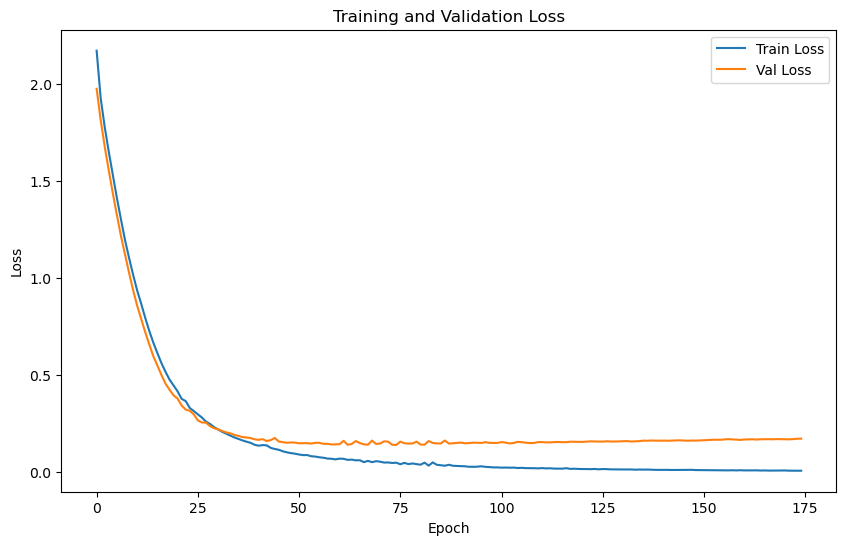

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.1740 | Test Accuracy: 95.80%


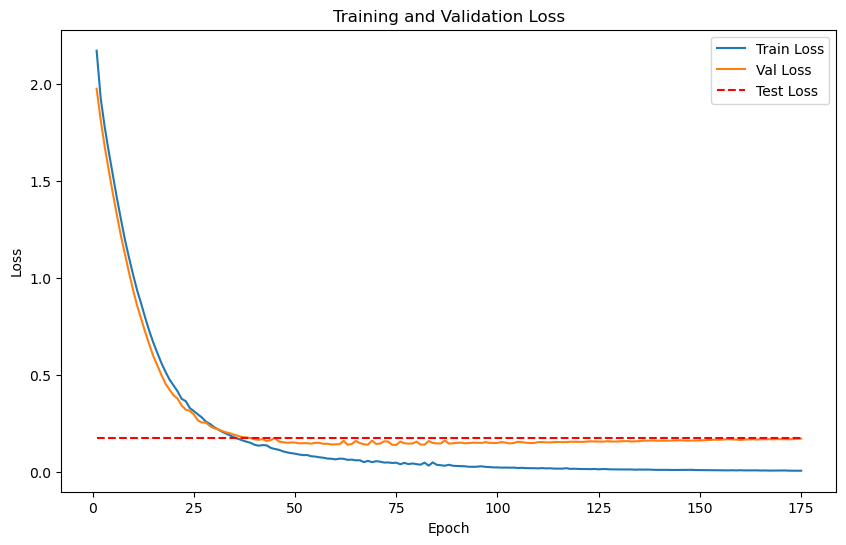

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.4208
Epoch [1/2000], Avg Train Loss: 8.4208


Epoch [1/2000], Avg Val Loss: 3.5782
Validation loss improved from inf to 3.5782. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.3812
Epoch [2/2000], Avg Train Loss: 8.3812
Epoch [2/2000], Avg Val Loss: 3.5363
Validation loss improved from 3.5782 to 3.5363. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4280
Epoch [3/2000], Avg Train Loss: 8.4280
Epoch [3/2000], Avg Val Loss: 3.4959
Validation loss improved from 3.5363 to 3.4959. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.4159
Epoch [4/2000], Avg Train Loss: 8.4159
Epoch [4/2000], Avg Val Loss: 3.4566
Validation loss improved from 3.4959 to 3.4566. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.0689
Epoch [5/2000], Avg Train Loss: 8.0689
Epoch [5/2000], Avg Val Loss: 3.4184
Validation loss improved from 3.4566 to 3.4184. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.1097
Ep

    Batch [1/1], Train Loss: 7.5422
Epoch [15/2000], Avg Train Loss: 7.5422
Epoch [15/2000], Avg Val Loss: 3.0960
Validation loss improved from 3.1237 to 3.0960. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.5625
Epoch [16/2000], Avg Train Loss: 7.5625
Epoch [16/2000], Avg Val Loss: 3.0693
Validation loss improved from 3.0960 to 3.0693. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.3346
Epoch [17/2000], Avg Train Loss: 7.3346
Epoch [17/2000], Avg Val Loss: 3.0435
Validation loss improved from 3.0693 to 3.0435. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.3773
Epoch [18/2000], Avg Train Loss: 7.3773
Epoch [18/2000], Avg Val Loss: 3.0187
Validation loss improved from 3.0435 to 3.0187. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.2584
Epoch [19/2000], Avg Train Loss: 7.2584
Epoch [19/2000], Avg Val Loss: 2.9947
Validation loss improved from 3.0187 to 2.

    Batch [1/1], Train Loss: 6.0390
Epoch [43/2000], Avg Train Loss: 6.0390
Epoch [43/2000], Avg Val Loss: 2.6360
Validation loss improved from 2.6449 to 2.6360. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 5.9166
Epoch [44/2000], Avg Train Loss: 5.9166
Epoch [44/2000], Avg Val Loss: 2.6276
Validation loss improved from 2.6360 to 2.6276. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.7965
Epoch [45/2000], Avg Train Loss: 5.7965
Epoch [45/2000], Avg Val Loss: 2.6196
Validation loss improved from 2.6276 to 2.6196. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.8619
Epoch [46/2000], Avg Train Loss: 5.8619
Epoch [46/2000], Avg Val Loss: 2.6120
Validation loss improved from 2.6196 to 2.6120. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.7638
Epoch [47/2000], Avg Train Loss: 5.7638
Epoch [47/2000], Avg Val Loss: 2.6047
Validation loss improved from 2.6120 to 2.

    Batch [1/1], Train Loss: 5.6372
Epoch [55/2000], Avg Train Loss: 5.6372
Epoch [55/2000], Avg Val Loss: 2.5564
Validation loss improved from 2.5615 to 2.5564. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.4601
Epoch [56/2000], Avg Train Loss: 5.4601
Epoch [56/2000], Avg Val Loss: 2.5515
Validation loss improved from 2.5564 to 2.5515. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.4788
Epoch [57/2000], Avg Train Loss: 5.4788
Epoch [57/2000], Avg Val Loss: 2.5467
Validation loss improved from 2.5515 to 2.5467. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.4767
Epoch [58/2000], Avg Train Loss: 5.4767
Epoch [58/2000], Avg Val Loss: 2.5421
Validation loss improved from 2.5467 to 2.5421. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.4130
Epoch [59/2000], Avg Train Loss: 5.4130
Epoch [59/2000], Avg Val Loss: 2.5378
Validation loss improved from 2.5421 to 2.

Epoch [85/2000], Avg Val Loss: 2.4662
Validation loss improved from 2.4679 to 2.4662. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 4.9330
Epoch [86/2000], Avg Train Loss: 4.9330
Epoch [86/2000], Avg Val Loss: 2.4645
Validation loss improved from 2.4662 to 2.4645. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 4.9538
Epoch [87/2000], Avg Train Loss: 4.9538
Epoch [87/2000], Avg Val Loss: 2.4628
Validation loss improved from 2.4645 to 2.4628. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.9457
Epoch [88/2000], Avg Train Loss: 4.9457
Epoch [88/2000], Avg Val Loss: 2.4612
Validation loss improved from 2.4628 to 2.4612. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.8396
Epoch [89/2000], Avg Train Loss: 4.8396
Epoch [89/2000], Avg Val Loss: 2.4597
Validation loss improved from 2.4612 to 2.4597. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.7168
Epoch [97/2000], Avg Train Loss: 4.7168
Epoch [97/2000], Avg Val Loss: 2.4482
Validation loss improved from 2.4496 to 2.4482. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.7155
Epoch [98/2000], Avg Train Loss: 4.7155
Epoch [98/2000], Avg Val Loss: 2.4469
Validation loss improved from 2.4482 to 2.4469. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.7259
Epoch [99/2000], Avg Train Loss: 4.7259
Epoch [99/2000], Avg Val Loss: 2.4456
Validation loss improved from 2.4469 to 2.4456. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.6987
Epoch [100/2000], Avg Train Loss: 4.6987
Epoch [100/2000], Avg Val Loss: 2.4444
Validation loss improved from 2.4456 to 2.4444. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.7300
Epoch [101/2000], Avg Train Loss: 4.7300
Epoch [101/2000], Avg Val Loss: 2.4431
Validation loss improved from 2.4444

    Batch [1/1], Train Loss: 4.5023
Epoch [128/2000], Avg Train Loss: 4.5023
Epoch [128/2000], Avg Val Loss: 2.4126
Validation loss improved from 2.4136 to 2.4126. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.5248
Epoch [129/2000], Avg Train Loss: 4.5248
Epoch [129/2000], Avg Val Loss: 2.4116
Validation loss improved from 2.4126 to 2.4116. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.5072
Epoch [130/2000], Avg Train Loss: 4.5072
Epoch [130/2000], Avg Val Loss: 2.4106
Validation loss improved from 2.4116 to 2.4106. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.4969
Epoch [131/2000], Avg Train Loss: 4.4969
Epoch [131/2000], Avg Val Loss: 2.4096
Validation loss improved from 2.4106 to 2.4096. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.5046
Epoch [132/2000], Avg Train Loss: 4.5046
Epoch [132/2000], Avg Val Loss: 2.4086
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4574
Epoch [139/2000], Avg Train Loss: 4.4574
Epoch [139/2000], Avg Val Loss: 2.4014
Validation loss improved from 2.4024 to 2.4014. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.4723
Epoch [140/2000], Avg Train Loss: 4.4723
Epoch [140/2000], Avg Val Loss: 2.4004
Validation loss improved from 2.4014 to 2.4004. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.4977
Epoch [141/2000], Avg Train Loss: 4.4977
Epoch [141/2000], Avg Val Loss: 2.3994
Validation loss improved from 2.4004 to 2.3994. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.4406
Epoch [142/2000], Avg Train Loss: 4.4406
Epoch [142/2000], Avg Val Loss: 2.3985
Validation loss improved from 2.3994 to 2.3985. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.4659
Epoch [143/2000], Avg Train Loss: 4.4659
Epoch [143/2000], Avg Val Loss: 2.3975
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3159
Epoch [171/2000], Avg Train Loss: 4.3159
Epoch [171/2000], Avg Val Loss: 2.3710
Validation loss improved from 2.3719 to 2.3710. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.3100
Epoch [172/2000], Avg Train Loss: 4.3100
Epoch [172/2000], Avg Val Loss: 2.3700
Validation loss improved from 2.3710 to 2.3700. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.2487
Epoch [173/2000], Avg Train Loss: 4.2487
Epoch [173/2000], Avg Val Loss: 2.3691
Validation loss improved from 2.3700 to 2.3691. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.2781
Epoch [174/2000], Avg Train Loss: 4.2781
Epoch [174/2000], Avg Val Loss: 2.3682
Validation loss improved from 2.3691 to 2.3682. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.2980
Epoch [175/2000], Avg Train Loss: 4.2980
Epoch [175/2000], Avg Val Loss: 2.3673
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2564
Epoch [183/2000], Avg Train Loss: 4.2564
Epoch [183/2000], Avg Val Loss: 2.3602
Validation loss improved from 2.3611 to 2.3602. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 4.3174
Epoch [184/2000], Avg Train Loss: 4.3174
Epoch [184/2000], Avg Val Loss: 2.3594
Validation loss improved from 2.3602 to 2.3594. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 4.2250
Epoch [185/2000], Avg Train Loss: 4.2250
Epoch [185/2000], Avg Val Loss: 2.3585
Validation loss improved from 2.3594 to 2.3585. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 4.2522
Epoch [186/2000], Avg Train Loss: 4.2522
Epoch [186/2000], Avg Val Loss: 2.3576
Validation loss improved from 2.3585 to 2.3576. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 4.2535
Epoch [187/2000], Avg Train Loss: 4.2535
Epoch [187/2000], Avg Val Loss: 2.3567
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1767
Epoch [215/2000], Avg Train Loss: 4.1767
Epoch [215/2000], Avg Val Loss: 2.3318
Validation loss improved from 2.3327 to 2.3318. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 4.1982
Epoch [216/2000], Avg Train Loss: 4.1982
Epoch [216/2000], Avg Val Loss: 2.3309
Validation loss improved from 2.3318 to 2.3309. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 4.1844
Epoch [217/2000], Avg Train Loss: 4.1844
Epoch [217/2000], Avg Val Loss: 2.3300
Validation loss improved from 2.3309 to 2.3300. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.1610
Epoch [218/2000], Avg Train Loss: 4.1610
Epoch [218/2000], Avg Val Loss: 2.3291
Validation loss improved from 2.3300 to 2.3291. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.1837
Epoch [219/2000], Avg Train Loss: 4.1837
Epoch [219/2000], Avg Val Loss: 2.3283
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1732
Epoch [225/2000], Avg Train Loss: 4.1732
Epoch [225/2000], Avg Val Loss: 2.3232
Validation loss improved from 2.3241 to 2.3232. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 4.1354
Epoch [226/2000], Avg Train Loss: 4.1354
Epoch [226/2000], Avg Val Loss: 2.3224
Validation loss improved from 2.3232 to 2.3224. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 4.0986
Epoch [227/2000], Avg Train Loss: 4.0986
Epoch [227/2000], Avg Val Loss: 2.3215
Validation loss improved from 2.3224 to 2.3215. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.1383
Epoch [228/2000], Avg Train Loss: 4.1383
Epoch [228/2000], Avg Val Loss: 2.3206
Validation loss improved from 2.3215 to 2.3206. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.1491
Epoch [229/2000], Avg Train Loss: 4.1491
Epoch [229/2000], Avg Val Loss: 2.3198
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0414
Epoch [261/2000], Avg Train Loss: 4.0414
Epoch [261/2000], Avg Val Loss: 2.2951
Validation loss improved from 2.2958 to 2.2951. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.0543
Epoch [262/2000], Avg Train Loss: 4.0543
Epoch [262/2000], Avg Val Loss: 2.2944
Validation loss improved from 2.2951 to 2.2944. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.0668
Epoch [263/2000], Avg Train Loss: 4.0668
Epoch [263/2000], Avg Val Loss: 2.2937
Validation loss improved from 2.2944 to 2.2937. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.0562
Epoch [264/2000], Avg Train Loss: 4.0562
Epoch [264/2000], Avg Val Loss: 2.2930
Validation loss improved from 2.2937 to 2.2930. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.0852
Epoch [265/2000], Avg Train Loss: 4.0852
Epoch [265/2000], Avg Val Loss: 2.2922
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9593
Epoch [304/2000], Avg Train Loss: 3.9593
Epoch [304/2000], Avg Val Loss: 2.2654
Validation loss improved from 2.2660 to 2.2654. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 4.0123
Epoch [305/2000], Avg Train Loss: 4.0123
Epoch [305/2000], Avg Val Loss: 2.2647
Validation loss improved from 2.2654 to 2.2647. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 3.9858
Epoch [306/2000], Avg Train Loss: 3.9858
Epoch [306/2000], Avg Val Loss: 2.2641
Validation loss improved from 2.2647 to 2.2641. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 3.9488
Epoch [307/2000], Avg Train Loss: 3.9488
Epoch [307/2000], Avg Val Loss: 2.2634
Validation loss improved from 2.2641 to 2.2634. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 3.9833
Epoch [308/2000], Avg Train Loss: 3.9833
Epoch [308/2000], Avg Val Loss: 2.2628
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9031
Epoch [348/2000], Avg Train Loss: 3.9031
Epoch [348/2000], Avg Val Loss: 2.2393
Validation loss improved from 2.2398 to 2.2393. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.9368
Epoch [349/2000], Avg Train Loss: 3.9368
Epoch [349/2000], Avg Val Loss: 2.2388
Validation loss improved from 2.2393 to 2.2388. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.9089
Epoch [350/2000], Avg Train Loss: 3.9089
Epoch [350/2000], Avg Val Loss: 2.2382
Validation loss improved from 2.2388 to 2.2382. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 3.8800
Epoch [351/2000], Avg Train Loss: 3.8800
Epoch [351/2000], Avg Val Loss: 2.2377
Validation loss improved from 2.2382 to 2.2377. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 3.8877
Epoch [352/2000], Avg Train Loss: 3.8877
Epoch [352/2000], Avg Val Loss: 2.2371
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8564
Epoch [391/2000], Avg Train Loss: 3.8564
Epoch [391/2000], Avg Val Loss: 2.2166
Validation loss improved from 2.2171 to 2.2166. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.8350
Epoch [392/2000], Avg Train Loss: 3.8350
Epoch [392/2000], Avg Val Loss: 2.2162
Validation loss improved from 2.2166 to 2.2162. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.8986
Epoch [393/2000], Avg Train Loss: 3.8986
Epoch [393/2000], Avg Val Loss: 2.2157
Validation loss improved from 2.2162 to 2.2157. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.8510
Epoch [394/2000], Avg Train Loss: 3.8510
Epoch [394/2000], Avg Val Loss: 2.2153
Validation loss improved from 2.2157 to 2.2153. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.8662
Epoch [395/2000], Avg Train Loss: 3.8662
Epoch [395/2000], Avg Val Loss: 2.2148
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8392
Epoch [434/2000], Avg Train Loss: 3.8392
Epoch [434/2000], Avg Val Loss: 2.1976
Validation loss improved from 2.1980 to 2.1976. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 3.8432
Epoch [435/2000], Avg Train Loss: 3.8432
Epoch [435/2000], Avg Val Loss: 2.1972
Validation loss improved from 2.1976 to 2.1972. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.8344
Epoch [436/2000], Avg Train Loss: 3.8344
Epoch [436/2000], Avg Val Loss: 2.1968
Validation loss improved from 2.1972 to 2.1968. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 3.8389
Epoch [437/2000], Avg Train Loss: 3.8389
Epoch [437/2000], Avg Val Loss: 2.1964
Validation loss improved from 2.1968 to 2.1964. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 3.8386
Epoch [438/2000], Avg Train Loss: 3.8386
Epoch [438/2000], Avg Val Loss: 2.1961
Validation loss improved fro

Epoch [473/2000], Avg Val Loss: 2.1821
Validation loss improved from 2.1825 to 2.1821. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 3.7998
Epoch [474/2000], Avg Train Loss: 3.7998
Epoch [474/2000], Avg Val Loss: 2.1817
Validation loss improved from 2.1821 to 2.1817. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 3.8009
Epoch [475/2000], Avg Train Loss: 3.8009
Epoch [475/2000], Avg Val Loss: 2.1814
Validation loss improved from 2.1817 to 2.1814. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 3.7538
Epoch [476/2000], Avg Train Loss: 3.7538
Epoch [476/2000], Avg Val Loss: 2.1810
Validation loss improved from 2.1814 to 2.1810. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 3.7650
Epoch [477/2000], Avg Train Loss: 3.7650
Epoch [477/2000], Avg Val Loss: 2.1806
Validation loss improved from 2.1810 to 2.1806. Saving model...

LOG: Epoch [478/2000] - Training
    Bat

Epoch [516/2000], Avg Val Loss: 2.1663
Validation loss improved from 2.1667 to 2.1663. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 3.7690
Epoch [517/2000], Avg Train Loss: 3.7690
Epoch [517/2000], Avg Val Loss: 2.1660
Validation loss improved from 2.1663 to 2.1660. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.7316
Epoch [518/2000], Avg Train Loss: 3.7316
Epoch [518/2000], Avg Val Loss: 2.1657
Validation loss improved from 2.1660 to 2.1657. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 3.7143
Epoch [519/2000], Avg Train Loss: 3.7143
Epoch [519/2000], Avg Val Loss: 2.1654
Validation loss improved from 2.1657 to 2.1654. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 3.7643
Epoch [520/2000], Avg Train Loss: 3.7643
Epoch [520/2000], Avg Val Loss: 2.1651
Validation loss improved from 2.1654 to 2.1651. Saving model...

LOG: Epoch [521/2000] - Training
    Bat

Epoch [559/2000], Avg Val Loss: 2.1528
Validation loss improved from 2.1531 to 2.1528. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 3.7091
Epoch [560/2000], Avg Train Loss: 3.7091
Epoch [560/2000], Avg Val Loss: 2.1525
Validation loss improved from 2.1528 to 2.1525. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 3.7794
Epoch [561/2000], Avg Train Loss: 3.7794
Epoch [561/2000], Avg Val Loss: 2.1522
Validation loss improved from 2.1525 to 2.1522. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.6670
Epoch [562/2000], Avg Train Loss: 3.6670
Epoch [562/2000], Avg Val Loss: 2.1519
Validation loss improved from 2.1522 to 2.1519. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 3.7062
Epoch [563/2000], Avg Train Loss: 3.7062
Epoch [563/2000], Avg Val Loss: 2.1515
Validation loss improved from 2.1519 to 2.1515. Saving model...

LOG: Epoch [564/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6994
Epoch [604/2000], Avg Train Loss: 3.6994
Epoch [604/2000], Avg Val Loss: 2.1409
Validation loss improved from 2.1411 to 2.1409. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 3.6572
Epoch [605/2000], Avg Train Loss: 3.6572
Epoch [605/2000], Avg Val Loss: 2.1406
Validation loss improved from 2.1409 to 2.1406. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 3.6627
Epoch [606/2000], Avg Train Loss: 3.6627
Epoch [606/2000], Avg Val Loss: 2.1404
Validation loss improved from 2.1406 to 2.1404. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 3.6549
Epoch [607/2000], Avg Train Loss: 3.6549
Epoch [607/2000], Avg Val Loss: 2.1401
Validation loss improved from 2.1404 to 2.1401. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 3.6928
Epoch [608/2000], Avg Train Loss: 3.6928
Epoch [608/2000], Avg Val Loss: 2.1399
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6837
Epoch [631/2000], Avg Train Loss: 3.6837
Epoch [631/2000], Avg Val Loss: 2.1341
Validation loss improved from 2.1344 to 2.1341. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 3.6630
Epoch [632/2000], Avg Train Loss: 3.6630
Epoch [632/2000], Avg Val Loss: 2.1338
Validation loss improved from 2.1341 to 2.1338. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 3.6478
Epoch [633/2000], Avg Train Loss: 3.6478
Epoch [633/2000], Avg Val Loss: 2.1335
Validation loss improved from 2.1338 to 2.1335. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 3.6840
Epoch [634/2000], Avg Train Loss: 3.6840
Epoch [634/2000], Avg Val Loss: 2.1333
Validation loss improved from 2.1335 to 2.1333. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.6706
Epoch [635/2000], Avg Train Loss: 3.6706
Epoch [635/2000], Avg Val Loss: 2.1330
Validation loss improved fro

Epoch [674/2000], Avg Val Loss: 2.1246
Validation loss improved from 2.1248 to 2.1246. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.6077
Epoch [675/2000], Avg Train Loss: 3.6077
Epoch [675/2000], Avg Val Loss: 2.1244
Validation loss improved from 2.1246 to 2.1244. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.6634
Epoch [676/2000], Avg Train Loss: 3.6634
Epoch [676/2000], Avg Val Loss: 2.1242
Validation loss improved from 2.1244 to 2.1242. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 3.6151
Epoch [677/2000], Avg Train Loss: 3.6151
Epoch [677/2000], Avg Val Loss: 2.1239
Validation loss improved from 2.1242 to 2.1239. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 3.6809
Epoch [678/2000], Avg Train Loss: 3.6809
Epoch [678/2000], Avg Val Loss: 2.1237
Validation loss improved from 2.1239 to 2.1237. Saving model...

LOG: Epoch [679/2000] - Training
    Bat

Epoch [714/2000], Avg Val Loss: 2.1176
Validation loss improved from 2.1178 to 2.1176. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.6043
Epoch [715/2000], Avg Train Loss: 3.6043
Epoch [715/2000], Avg Val Loss: 2.1175
Validation loss improved from 2.1176 to 2.1175. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 3.5942
Epoch [716/2000], Avg Train Loss: 3.5942
Epoch [716/2000], Avg Val Loss: 2.1173
Validation loss improved from 2.1175 to 2.1173. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 3.5623
Epoch [717/2000], Avg Train Loss: 3.5623
Epoch [717/2000], Avg Val Loss: 2.1171
Validation loss improved from 2.1173 to 2.1171. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 3.6162
Epoch [718/2000], Avg Train Loss: 3.6162
Epoch [718/2000], Avg Val Loss: 2.1169
Validation loss improved from 2.1171 to 2.1169. Saving model...

LOG: Epoch [719/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6098
Epoch [759/2000], Avg Train Loss: 3.6098
Epoch [759/2000], Avg Val Loss: 2.1094
Validation loss improved from 2.1096 to 2.1094. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 3.5532
Epoch [760/2000], Avg Train Loss: 3.5532
Epoch [760/2000], Avg Val Loss: 2.1093
Validation loss improved from 2.1094 to 2.1093. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 3.6087
Epoch [761/2000], Avg Train Loss: 3.6087
Epoch [761/2000], Avg Val Loss: 2.1091
Validation loss improved from 2.1093 to 2.1091. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 3.5929
Epoch [762/2000], Avg Train Loss: 3.5929
Epoch [762/2000], Avg Val Loss: 2.1089
Validation loss improved from 2.1091 to 2.1089. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 3.5944
Epoch [763/2000], Avg Train Loss: 3.5944
Epoch [763/2000], Avg Val Loss: 2.1087
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5856
Epoch [808/2000], Avg Train Loss: 3.5856
Epoch [808/2000], Avg Val Loss: 2.1018
Validation loss improved from 2.1020 to 2.1018. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 3.5540
Epoch [809/2000], Avg Train Loss: 3.5540
Epoch [809/2000], Avg Val Loss: 2.1016
Validation loss improved from 2.1018 to 2.1016. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 3.5616
Epoch [810/2000], Avg Train Loss: 3.5616
Epoch [810/2000], Avg Val Loss: 2.1014
Validation loss improved from 2.1016 to 2.1014. Saving model...

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 3.5570
Epoch [811/2000], Avg Train Loss: 3.5570
Epoch [811/2000], Avg Val Loss: 2.1013
Validation loss improved from 2.1014 to 2.1013. Saving model...

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 3.5668
Epoch [812/2000], Avg Train Loss: 3.5668
Epoch [812/2000], Avg Val Loss: 2.1011
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5364
Epoch [851/2000], Avg Train Loss: 3.5364
Epoch [851/2000], Avg Val Loss: 2.0953
Validation loss improved from 2.0954 to 2.0953. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.5341
Epoch [852/2000], Avg Train Loss: 3.5341
Epoch [852/2000], Avg Val Loss: 2.0951
Validation loss improved from 2.0953 to 2.0951. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.5206
Epoch [853/2000], Avg Train Loss: 3.5206
Epoch [853/2000], Avg Val Loss: 2.0950
Validation loss improved from 2.0951 to 2.0950. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 3.5561
Epoch [854/2000], Avg Train Loss: 3.5561
Epoch [854/2000], Avg Val Loss: 2.0949
Validation loss improved from 2.0950 to 2.0949. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 3.5450
Epoch [855/2000], Avg Train Loss: 3.5450
Epoch [855/2000], Avg Val Loss: 2.0947
Validation loss improved fro

Epoch [893/2000], Avg Val Loss: 2.0919
Validation loss improved from 2.0920 to 2.0919. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 3.5160
Epoch [894/2000], Avg Train Loss: 3.5160
Epoch [894/2000], Avg Val Loss: 2.0918
Validation loss improved from 2.0919 to 2.0918. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 3.4886
Epoch [895/2000], Avg Train Loss: 3.4886
Epoch [895/2000], Avg Val Loss: 2.0918
Validation loss improved from 2.0918 to 2.0918. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 3.5134
Epoch [896/2000], Avg Train Loss: 3.5134
Epoch [896/2000], Avg Val Loss: 2.0917
Validation loss improved from 2.0918 to 2.0917. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 3.5131
Epoch [897/2000], Avg Train Loss: 3.5131
Epoch [897/2000], Avg Val Loss: 2.0917
Validation loss improved from 2.0917 to 2.0917. Saving model...

LOG: Epoch [898/2000] - Training
    Bat

Epoch [938/2000], Avg Val Loss: 2.0908
Validation loss improved from 2.0908 to 2.0908. Saving model...

LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 3.4914
Epoch [939/2000], Avg Train Loss: 3.4914
Epoch [939/2000], Avg Val Loss: 2.0908
Validation loss improved from 2.0908 to 2.0908. Saving model...

LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 3.4850
Epoch [940/2000], Avg Train Loss: 3.4850
Epoch [940/2000], Avg Val Loss: 2.0907
Validation loss improved from 2.0908 to 2.0907. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 3.4760
Epoch [941/2000], Avg Train Loss: 3.4760
Epoch [941/2000], Avg Val Loss: 2.0907
Validation loss improved from 2.0907 to 2.0907. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.4643
Epoch [942/2000], Avg Train Loss: 3.4643
Epoch [942/2000], Avg Val Loss: 2.0907
Validation loss improved from 2.0907 to 2.0907. Saving model...

LOG: Epoch [943/2000] - Training
    Bat

Epoch [981/2000], Avg Val Loss: 2.0869
Validation loss improved from 2.0869 to 2.0869. Saving model...

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 3.4804
Epoch [982/2000], Avg Train Loss: 3.4804
Epoch [982/2000], Avg Val Loss: 2.0869
Validation loss did not improve. Patience: 1/100

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 3.4784
Epoch [983/2000], Avg Train Loss: 3.4784
Epoch [983/2000], Avg Val Loss: 2.0868
Validation loss improved from 2.0869 to 2.0868. Saving model...

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 3.4581
Epoch [984/2000], Avg Train Loss: 3.4581
Epoch [984/2000], Avg Val Loss: 2.0868
Validation loss improved from 2.0868 to 2.0868. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 3.5038
Epoch [985/2000], Avg Train Loss: 3.5038
Epoch [985/2000], Avg Val Loss: 2.0868
Validation loss did not improve. Patience: 1/100

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 3.4853
E

Epoch [1025/2000], Avg Val Loss: 2.0857
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 3.4578
Epoch [1026/2000], Avg Train Loss: 3.4578
Epoch [1026/2000], Avg Val Loss: 2.0856
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 3.4830
Epoch [1027/2000], Avg Train Loss: 3.4830
Epoch [1027/2000], Avg Val Loss: 2.0855
Validation loss improved from 2.0855 to 2.0855. Saving model...

LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 3.4761
Epoch [1028/2000], Avg Train Loss: 3.4761
Epoch [1028/2000], Avg Val Loss: 2.0854
Validation loss improved from 2.0855 to 2.0854. Saving model...

LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 3.4372
Epoch [1029/2000], Avg Train Loss: 3.4372
Epoch [1029/2000], Avg Val Loss: 2.0854
Validation loss improved from 2.0854 to 2.0854. Saving model...

LOG: Epoch [1030/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 3.4326
Epoch [1066/2000], Avg Train Loss: 3.4326
Epoch [1066/2000], Avg Val Loss: 2.0846
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 3.4865
Epoch [1067/2000], Avg Train Loss: 3.4865
Epoch [1067/2000], Avg Val Loss: 2.0847
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 3.4483
Epoch [1068/2000], Avg Train Loss: 3.4483
Epoch [1068/2000], Avg Val Loss: 2.0848
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 3.4164
Epoch [1069/2000], Avg Train Loss: 3.4164
Epoch [1069/2000], Avg Val Loss: 2.0849
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 3.4531
Epoch [1070/2000], Avg Train Loss: 3.4531
Epoch [1070/2000], Avg Val Loss: 2.0849
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1071/20

    Batch [1/1], Train Loss: 3.4227
Epoch [1109/2000], Avg Train Loss: 3.4227
Epoch [1109/2000], Avg Val Loss: 2.0839
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 3.4790
Epoch [1110/2000], Avg Train Loss: 3.4790
Epoch [1110/2000], Avg Val Loss: 2.0840
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 3.4242
Epoch [1111/2000], Avg Train Loss: 3.4242
Epoch [1111/2000], Avg Val Loss: 2.0841
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 3.3984
Epoch [1112/2000], Avg Train Loss: 3.3984
Epoch [1112/2000], Avg Val Loss: 2.0841
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 3.4268
Epoch [1113/2000], Avg Train Loss: 3.4268
Epoch [1113/2000], Avg Val Loss: 2.0841
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1114/2000] -

Epoch [1151/2000], Avg Val Loss: 2.0850
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 3.4416
Epoch [1152/2000], Avg Train Loss: 3.4416
Epoch [1152/2000], Avg Val Loss: 2.0851
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 3.4128
Epoch [1153/2000], Avg Train Loss: 3.4128
Epoch [1153/2000], Avg Val Loss: 2.0851
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 3.3904
Epoch [1154/2000], Avg Train Loss: 3.3904
Epoch [1154/2000], Avg Val Loss: 2.0850
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 3.4273
Epoch [1155/2000], Avg Train Loss: 3.4273
Epoch [1155/2000], Avg Val Loss: 2.0850
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 3.4182
Epoch [1156/2000], Avg Trai

    Batch [1/1], Train Loss: 3.3803
Epoch [1195/2000], Avg Train Loss: 3.3803
Epoch [1195/2000], Avg Val Loss: 2.0866
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 3.4370
Epoch [1196/2000], Avg Train Loss: 3.4370
Epoch [1196/2000], Avg Val Loss: 2.0865
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 3.4098
Epoch [1197/2000], Avg Train Loss: 3.4098
Epoch [1197/2000], Avg Val Loss: 2.0864
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 3.3969
Epoch [1198/2000], Avg Train Loss: 3.3969
Epoch [1198/2000], Avg Val Loss: 2.0863
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 3.4056
Epoch [1199/2000], Avg Train Loss: 3.4056
Epoch [1199/2000], Avg Val Loss: 2.0861
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1200/20

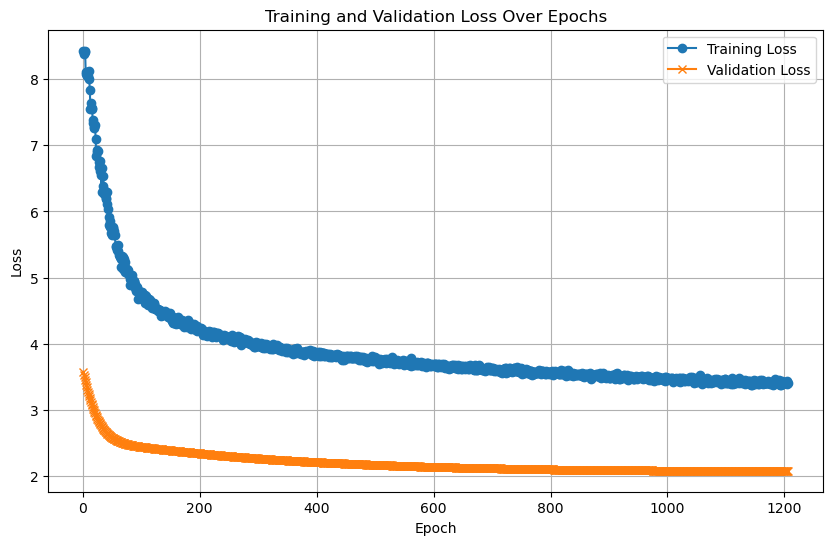

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 5.4416
Test Batch [20/578], Loss: 5.5498
Test Batch [30/578], Loss: 5.4481


Test Batch [40/578], Loss: 5.3526
Test Batch [50/578], Loss: 5.3885
Test Batch [60/578], Loss: 5.4647
Test Batch [70/578], Loss: 5.5918
Test Batch [80/578], Loss: 5.2741
Test Batch [90/578], Loss: 5.6215
Test Batch [100/578], Loss: 5.6084
Test Batch [110/578], Loss: 5.6190
Test Batch [120/578], Loss: 5.5627
Test Batch [130/578], Loss: 5.5254
Test Batch [140/578], Loss: 5.6115
Test Batch [150/578], Loss: 5.5749


Test Batch [160/578], Loss: 5.4362


Test Batch [170/578], Loss: 5.4231
Test Batch [180/578], Loss: 5.6037
Test Batch [190/578], Loss: 5.4509
Test Batch [200/578], Loss: 5.4031
Test Batch [210/578], Loss: 5.4001
Test Batch [220/578], Loss: 5.3552
Test Batch [230/578], Loss: 5.3933
Test Batch [240/578], Loss: 5.2221
Test Batch [250/578], Loss: 5.3442
Test Batch [260/578], Loss: 5.4307
Test Batch [270/578], Loss: 5.3883
Test Batch [280/578], Loss: 5.6867
Test Batch [290/578], Loss: 5.2416
Test Batch [300/578], Loss: 5.0867


Test Batch [310/578], Loss: 5.0534
Test Batch [320/578], Loss: 5.0734
Test Batch [330/578], Loss: 5.1586
Test Batch [340/578], Loss: 4.9871
Test Batch [350/578], Loss: 4.9266
Test Batch [360/578], Loss: 5.0310
Test Batch [370/578], Loss: 5.0230
Test Batch [380/578], Loss: 5.7372
Test Batch [390/578], Loss: 5.0676
Test Batch [400/578], Loss: 5.0897
Test Batch [410/578], Loss: 5.0587
Test Batch [420/578], Loss: 4.8634
Test Batch [430/578], Loss: 5.1519
Test Batch [440/578], Loss: 5.2023
Test Batch [450/578], Loss: 5.0973


Test Batch [460/578], Loss: 5.2684
Test Batch [470/578], Loss: 4.9725
Test Batch [480/578], Loss: 5.6821
Test Batch [490/578], Loss: 4.9402
Test Batch [500/578], Loss: 5.0026
Test Batch [510/578], Loss: 5.0230
Test Batch [520/578], Loss: 4.6535
Test Batch [530/578], Loss: 4.8675
Test Batch [540/578], Loss: 5.8614
Test Batch [550/578], Loss: 5.5396
Test Batch [560/578], Loss: 5.6453
Test Batch [570/578], Loss: 5.5463

Test Loss: 5.3350


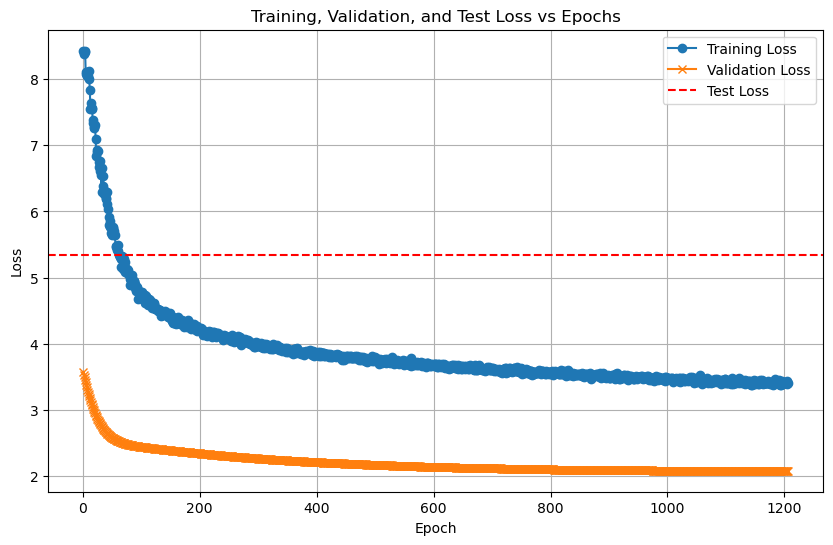

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.


  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.
  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.


  Processed batch 130/578 for test dataset.
  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.
  Processed batch 190/578 for test dataset.


  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.


  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.


  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.


  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.


  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.


Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.80      0.80      0.80         5
           4       0.80      0.80      0.80         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45


LOG: Evaluating on the test set...
Test Accuracy: 95.86%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65946
           1       0.95      0.83      0.89      7573
           2       0.68      0.87      0.76      3065
           3       0.63      0.95      0.76      2660
           4       0.86      0.85      0.86      6559
           5       0.84      0.95      0.90      9223
           6       0.94      0.83      0.88      7262
           7       1.00      0.97      0.98     42801
           8       0.97      1.00      0.98      2838

    accuracy                           0.96    147927
   macro avg       0.88      0.92      0.89    147927
weighted avg       0.96      0.96      0.96    147927

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3045  |  Val Loss: 2.2979
Validation loss improved from inf to 2.2979.
[Epoch 2/1000] Train Loss: 2.2631  |  Val Loss: 2.2557
Validation loss improved from 2.2979 to 2.2557.
[Epoch 3/1000] Train Loss: 2.2268  |  Val Loss: 2.2158
Validation loss improved from 2.2557 to 2.2158.
[Epoch 4/1000] Train Loss: 2.1891  |  Val Loss: 2.1796
Validation loss improved from 2.2158 to 2.1796.
[Epoch 5/1000] Train Loss: 2.1557  |  Val Loss: 2.1460
Validation loss improved from 2.1796 to 2.1460.
[Epoch 6/1000] Train Loss: 2.1244  |  Val Loss: 2.1144
Validation loss improved from 2.1460 to 2.1144.
[Epoch 7/1000] Train Loss: 2.0946  |  Val Loss: 2.0843
Validation loss improved from 2.1144 to 2.0843.
[Epoch 8/1000] Train Loss: 2.0669  |  Val Loss: 2.0552
Validation loss improved from 2.0843 to 2.0552.
[Epoch 9/1000] Train Loss: 2.0399  |  Val Loss: 2.0276
Validation loss improved from 2.0552 to 2.0276.
[Epoch 10/1000] Train Loss: 2.0133  |  Val Loss: 2.0014
Validation loss impr

[Epoch 27/1000] Train Loss: 1.6892  |  Val Loss: 1.6787
Validation loss improved from 1.6950 to 1.6787.


[Epoch 28/1000] Train Loss: 1.6730  |  Val Loss: 1.6624
Validation loss improved from 1.6787 to 1.6624.
[Epoch 29/1000] Train Loss: 1.6565  |  Val Loss: 1.6458
Validation loss improved from 1.6624 to 1.6458.
[Epoch 30/1000] Train Loss: 1.6402  |  Val Loss: 1.6292
Validation loss improved from 1.6458 to 1.6292.
[Epoch 31/1000] Train Loss: 1.6235  |  Val Loss: 1.6128
Validation loss improved from 1.6292 to 1.6128.
[Epoch 32/1000] Train Loss: 1.6072  |  Val Loss: 1.5963
Validation loss improved from 1.6128 to 1.5963.
[Epoch 33/1000] Train Loss: 1.5908  |  Val Loss: 1.5797
Validation loss improved from 1.5963 to 1.5797.
[Epoch 34/1000] Train Loss: 1.5741  |  Val Loss: 1.5636
Validation loss improved from 1.5797 to 1.5636.
[Epoch 35/1000] Train Loss: 1.5576  |  Val Loss: 1.5473
Validation loss improved from 1.5636 to 1.5473.
[Epoch 36/1000] Train Loss: 1.5414  |  Val Loss: 1.5311
Validation loss improved from 1.5473 to 1.5311.
[Epoch 37/1000] Train Loss: 1.5252  |  Val Loss: 1.5148
Validati

[Epoch 60/1000] Train Loss: 1.1326  |  Val Loss: 1.1285
Validation loss improved from 1.1456 to 1.1285.
[Epoch 61/1000] Train Loss: 1.1151  |  Val Loss: 1.1116
Validation loss improved from 1.1285 to 1.1116.
[Epoch 62/1000] Train Loss: 1.0973  |  Val Loss: 1.0946
Validation loss improved from 1.1116 to 1.0946.
[Epoch 63/1000] Train Loss: 1.0797  |  Val Loss: 1.0778
Validation loss improved from 1.0946 to 1.0778.
[Epoch 64/1000] Train Loss: 1.0623  |  Val Loss: 1.0609
Validation loss improved from 1.0778 to 1.0609.
[Epoch 65/1000] Train Loss: 1.0452  |  Val Loss: 1.0442
Validation loss improved from 1.0609 to 1.0442.
[Epoch 66/1000] Train Loss: 1.0278  |  Val Loss: 1.0275
Validation loss improved from 1.0442 to 1.0275.
[Epoch 67/1000] Train Loss: 1.0107  |  Val Loss: 1.0110
Validation loss improved from 1.0275 to 1.0110.
[Epoch 68/1000] Train Loss: 0.9937  |  Val Loss: 0.9946
Validation loss improved from 1.0110 to 0.9946.
[Epoch 69/1000] Train Loss: 0.9766  |  Val Loss: 0.9780
Validati

[Epoch 91/1000] Train Loss: 0.6222  |  Val Loss: 0.6432
Validation loss improved from 0.6565 to 0.6432.
[Epoch 92/1000] Train Loss: 0.6077  |  Val Loss: 0.6302
Validation loss improved from 0.6432 to 0.6302.
[Epoch 93/1000] Train Loss: 0.5938  |  Val Loss: 0.6174
Validation loss improved from 0.6302 to 0.6174.
[Epoch 94/1000] Train Loss: 0.5799  |  Val Loss: 0.6047
Validation loss improved from 0.6174 to 0.6047.
[Epoch 95/1000] Train Loss: 0.5663  |  Val Loss: 0.5924
Validation loss improved from 0.6047 to 0.5924.
[Epoch 96/1000] Train Loss: 0.5526  |  Val Loss: 0.5806
Validation loss improved from 0.5924 to 0.5806.
[Epoch 97/1000] Train Loss: 0.5402  |  Val Loss: 0.5693
Validation loss improved from 0.5806 to 0.5693.
[Epoch 98/1000] Train Loss: 0.5274  |  Val Loss: 0.5582
Validation loss improved from 0.5693 to 0.5582.
[Epoch 99/1000] Train Loss: 0.5151  |  Val Loss: 0.5470
Validation loss improved from 0.5582 to 0.5470.
[Epoch 100/1000] Train Loss: 0.5031  |  Val Loss: 0.5361
Validat

[Epoch 122/1000] Train Loss: 0.3078  |  Val Loss: 0.3607
Validation loss improved from 0.3667 to 0.3607.
[Epoch 123/1000] Train Loss: 0.3014  |  Val Loss: 0.3546
Validation loss improved from 0.3607 to 0.3546.
[Epoch 124/1000] Train Loss: 0.2949  |  Val Loss: 0.3490
Validation loss improved from 0.3546 to 0.3490.
[Epoch 125/1000] Train Loss: 0.2889  |  Val Loss: 0.3436
Validation loss improved from 0.3490 to 0.3436.
[Epoch 126/1000] Train Loss: 0.2826  |  Val Loss: 0.3381
Validation loss improved from 0.3436 to 0.3381.
[Epoch 127/1000] Train Loss: 0.2768  |  Val Loss: 0.3328
Validation loss improved from 0.3381 to 0.3328.
[Epoch 128/1000] Train Loss: 0.2713  |  Val Loss: 0.3275
Validation loss improved from 0.3328 to 0.3275.
[Epoch 129/1000] Train Loss: 0.2652  |  Val Loss: 0.3226
Validation loss improved from 0.3275 to 0.3226.
[Epoch 130/1000] Train Loss: 0.2599  |  Val Loss: 0.3179
Validation loss improved from 0.3226 to 0.3179.
[Epoch 131/1000] Train Loss: 0.2546  |  Val Loss: 0.313

[Epoch 152/1000] Train Loss: 0.1762  |  Val Loss: 0.2466
Validation loss improved from 0.2488 to 0.2466.
[Epoch 153/1000] Train Loss: 0.1735  |  Val Loss: 0.2442
Validation loss improved from 0.2466 to 0.2442.
[Epoch 154/1000] Train Loss: 0.1709  |  Val Loss: 0.2421
Validation loss improved from 0.2442 to 0.2421.
[Epoch 155/1000] Train Loss: 0.1683  |  Val Loss: 0.2400
Validation loss improved from 0.2421 to 0.2400.
[Epoch 156/1000] Train Loss: 0.1658  |  Val Loss: 0.2379
Validation loss improved from 0.2400 to 0.2379.
[Epoch 157/1000] Train Loss: 0.1635  |  Val Loss: 0.2361
Validation loss improved from 0.2379 to 0.2361.
[Epoch 158/1000] Train Loss: 0.1609  |  Val Loss: 0.2340
Validation loss improved from 0.2361 to 0.2340.
[Epoch 159/1000] Train Loss: 0.1584  |  Val Loss: 0.2322
Validation loss improved from 0.2340 to 0.2322.
[Epoch 160/1000] Train Loss: 0.1561  |  Val Loss: 0.2304
Validation loss improved from 0.2322 to 0.2304.
[Epoch 161/1000] Train Loss: 0.1540  |  Val Loss: 0.228

[Epoch 182/1000] Train Loss: 0.1159  |  Val Loss: 0.1997
Validation loss improved from 0.2009 to 0.1997.
[Epoch 183/1000] Train Loss: 0.1144  |  Val Loss: 0.1987
Validation loss improved from 0.1997 to 0.1987.
[Epoch 184/1000] Train Loss: 0.1130  |  Val Loss: 0.1978
Validation loss improved from 0.1987 to 0.1978.
[Epoch 185/1000] Train Loss: 0.1117  |  Val Loss: 0.1970
Validation loss improved from 0.1978 to 0.1970.
[Epoch 186/1000] Train Loss: 0.1104  |  Val Loss: 0.1960
Validation loss improved from 0.1970 to 0.1960.
[Epoch 187/1000] Train Loss: 0.1091  |  Val Loss: 0.1952
Validation loss improved from 0.1960 to 0.1952.
[Epoch 188/1000] Train Loss: 0.1077  |  Val Loss: 0.1944
Validation loss improved from 0.1952 to 0.1944.
[Epoch 189/1000] Train Loss: 0.1065  |  Val Loss: 0.1935
Validation loss improved from 0.1944 to 0.1935.
[Epoch 190/1000] Train Loss: 0.1052  |  Val Loss: 0.1926
Validation loss improved from 0.1935 to 0.1926.
[Epoch 191/1000] Train Loss: 0.1041  |  Val Loss: 0.191

[Epoch 214/1000] Train Loss: 0.0819  |  Val Loss: 0.1788
Validation loss improved from 0.1790 to 0.1788.
[Epoch 215/1000] Train Loss: 0.0810  |  Val Loss: 0.1784
Validation loss improved from 0.1788 to 0.1784.
[Epoch 216/1000] Train Loss: 0.0807  |  Val Loss: 0.1783
Validation loss improved from 0.1784 to 0.1783.
[Epoch 217/1000] Train Loss: 0.0796  |  Val Loss: 0.1778
Validation loss improved from 0.1783 to 0.1778.
[Epoch 218/1000] Train Loss: 0.0788  |  Val Loss: 0.1775
Validation loss improved from 0.1778 to 0.1775.
[Epoch 219/1000] Train Loss: 0.0780  |  Val Loss: 0.1771
Validation loss improved from 0.1775 to 0.1771.
[Epoch 220/1000] Train Loss: 0.0773  |  Val Loss: 0.1769
Validation loss improved from 0.1771 to 0.1769.
[Epoch 221/1000] Train Loss: 0.0767  |  Val Loss: 0.1765
Validation loss improved from 0.1769 to 0.1765.
[Epoch 222/1000] Train Loss: 0.0759  |  Val Loss: 0.1764
Validation loss improved from 0.1765 to 0.1764.
[Epoch 223/1000] Train Loss: 0.0754  |  Val Loss: 0.176

[Epoch 243/1000] Train Loss: 0.0638  |  Val Loss: 0.1720
Validation loss improved from 0.1721 to 0.1720.
[Epoch 244/1000] Train Loss: 0.0635  |  Val Loss: 0.1718
Validation loss improved from 0.1720 to 0.1718.
[Epoch 245/1000] Train Loss: 0.0628  |  Val Loss: 0.1719
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 246/1000] Train Loss: 0.0624  |  Val Loss: 0.1717
Validation loss improved from 0.1718 to 0.1717.
[Epoch 247/1000] Train Loss: 0.0621  |  Val Loss: 0.1718
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 248/1000] Train Loss: 0.0614  |  Val Loss: 0.1716
Validation loss improved from 0.1717 to 0.1716.
[Epoch 249/1000] Train Loss: 0.0609  |  Val Loss: 0.1714
Validation loss improved from 0.1716 to 0.1714.
[Epoch 250/1000] Train Loss: 0.0605  |  Val Loss: 0.1714
Validation loss improved from 0.1714 to 0.1714.
[Epoch 251/1000] Train Loss: 0.0602  |  Val Loss: 0.1714
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.0596  

[Epoch 274/1000] Train Loss: 0.0515  |  Val Loss: 0.1707
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 275/1000] Train Loss: 0.0510  |  Val Loss: 0.1708
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 276/1000] Train Loss: 0.0507  |  Val Loss: 0.1708
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 277/1000] Train Loss: 0.0506  |  Val Loss: 0.1711
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 278/1000] Train Loss: 0.0501  |  Val Loss: 0.1709
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 279/1000] Train Loss: 0.0497  |  Val Loss: 0.1710
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 280/1000] Train Loss: 0.0495  |  Val Loss: 0.1710
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 281/1000] Train Loss: 0.0491  |  Val Loss: 0.1710
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 282/1000] Train Loss: 0.0489  |  Val Loss: 0.1710
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 303/1000] Train Loss: 0.0434  |  Val Loss: 0.1729
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 304/1000] Train Loss: 0.0431  |  Val Loss: 0.1730
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 305/1000] Train Loss: 0.0429  |  Val Loss: 0.1731
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 306/1000] Train Loss: 0.0427  |  Val Loss: 0.1732
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 307/1000] Train Loss: 0.0424  |  Val Loss: 0.1732
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 308/1000] Train Loss: 0.0422  |  Val Loss: 0.1732
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 309/1000] Train Loss: 0.0419  |  Val Loss: 0.1731
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 310/1000] Train Loss: 0.0417  |  Val Loss: 0.1730
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 311/1000] Train Loss: 0.0415  |  Val Loss: 0.1731
!! Validation loss did NOT improve !! Patience:

[Epoch 335/1000] Train Loss: 0.0362  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 336/1000] Train Loss: 0.0363  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 337/1000] Train Loss: 0.0358  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 338/1000] Train Loss: 0.0360  |  Val Loss: 0.1756
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 339/1000] Train Loss: 0.0355  |  Val Loss: 0.1756
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 340/1000] Train Loss: 0.0354  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 341/1000] Train Loss: 0.0350  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 342/1000] Train Loss: 0.0350  |  Val Loss: 0.1761
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 343/1000] Train Loss: 0.0347  |  Val Loss: 0.1761
!! Validation loss did NOT improve !! Patience:

[Epoch 365/1000] Train Loss: 0.0311  |  Val Loss: 0.1789
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 366/1000] Train Loss: 0.0310  |  Val Loss: 0.1790
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 367/1000] Train Loss: 0.0309  |  Val Loss: 0.1791
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 368/1000] Train Loss: 0.0308  |  Val Loss: 0.1793
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 369/1000] Train Loss: 0.0307  |  Val Loss: 0.1793
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 370/1000] Train Loss: 0.0306  |  Val Loss: 0.1794
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 370 !!
No improvement for 100 epochs.


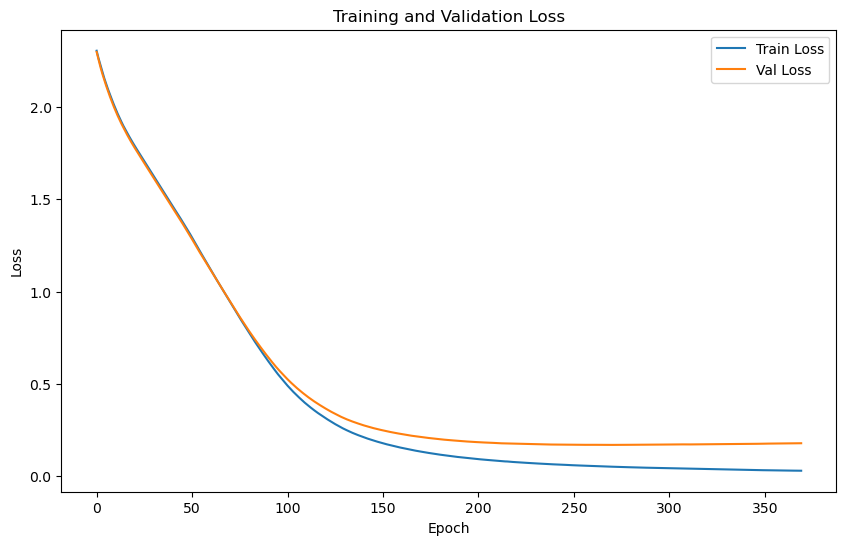

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.1656 | Test Accuracy: 95.43%


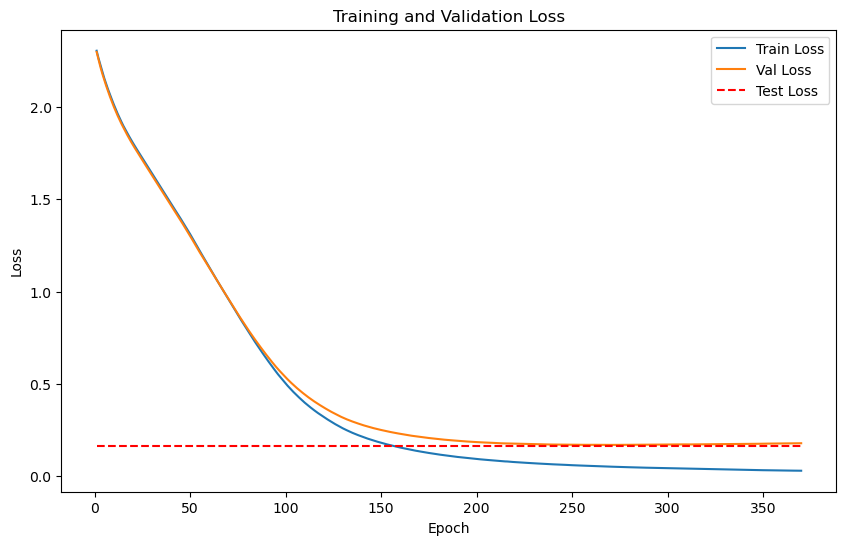

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3868
Epoch [1/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3868

Validation loss improved from inf to 0.3868. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [2/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3850

Validation loss improved from 0.3868 to 0.3850. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.3829
Epoch [3/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.3829

Validation loss improved from 0.3850 to 0.3829. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3804
Epoch [4/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3804

Validation loss improved from 0.3829 to 0.3804. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [5/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.3783

Validation loss improved from 0.3804 to 0.3783. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [6/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.3763

Validation loss improved from 0.3783 to 0.3763. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.3742
Epoch [7/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.3742

Validation loss improved from 0.3763 to 0.3742. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3718
Epoch [8/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.3718

Validation loss improved from 0.3742 to 0.3718. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3700
Epoch [9/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3700

Validation loss improved from 0.3718 to 0.3700. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [10/2000] - Validation


    Batch [1/1], Val Loss: 0.3683
Epoch [10/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3683

Validation loss improved from 0.3700 to 0.3683. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [11/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3663

Validation loss improved from 0.3683 to 0.3663. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [12/2000] - Validation


    Batch [1/1], Val Loss: 0.3645
Epoch [12/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3645

Validation loss improved from 0.3663 to 0.3645. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3627
Epoch [13/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3627

Validation loss improved from 0.3645 to 0.3627. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [14/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3610

Validation loss improved from 0.3627 to 0.3610. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3595
Epoch [15/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3595

Validation loss improved from 0.3610 to 0.3595. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [16/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3579

Validation loss improved from 0.3595 to 0.3579. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [17/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3563

Validation loss improved from 0.3579 to 0.3563. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [18/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3548

Validation loss improved from 0.3563 to 0.3548. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [19/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3532

Validation loss improved from 0.3548 to 0.3532. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [20/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3517

Validation loss improved from 0.3532 to 0.3517. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [21/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.3502

Validation loss improved from 0.3517 to 0.3502. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3488
Epoch [22/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3488

Validation loss improved from 0.3502 to 0.3488. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [23/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3474

Validation loss improved from 0.3488 to 0.3474. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3460
Epoch [24/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.3460

Validation loss improved from 0.3474 to 0.3460. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3446
Epoch [25/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3446

Validation loss improved from 0.3460 to 0.3446. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [26/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.3433

Validation loss improved from 0.3446 to 0.3433. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [27/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.3419

Validation loss improved from 0.3433 to 0.3419. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3406
Epoch [28/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3406

Validation loss improved from 0.3419 to 0.3406. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [29/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.3393

Validation loss improved from 0.3406 to 0.3393. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [30/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.3380

Validation loss improved from 0.3393 to 0.3380. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [31/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3368

Validation loss improved from 0.3380 to 0.3368. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3357
Epoch [32/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.3357

Validation loss improved from 0.3368 to 0.3357. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3345
Epoch [33/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.3345

Validation loss improved from 0.3357 to 0.3345. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [34/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.3334

Validation loss improved from 0.3345 to 0.3334. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [35/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.3323

Validation loss improved from 0.3334 to 0.3323. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [36/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.3312

Validation loss improved from 0.3323 to 0.3312. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.3301
Epoch [37/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.3301

Validation loss improved from 0.3312 to 0.3301. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [38/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.3290

Validation loss improved from 0.3301 to 0.3290. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3279
Epoch [39/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3279

Validation loss improved from 0.3290 to 0.3279. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [40/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.3268

Validation loss improved from 0.3279 to 0.3268. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [41/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3257

Validation loss improved from 0.3268 to 0.3257. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [42/2000] - Validation


    Batch [1/1], Val Loss: 0.3246
Epoch [42/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.3246

Validation loss improved from 0.3257 to 0.3246. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3235
Epoch [43/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3235

Validation loss improved from 0.3246 to 0.3235. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3224
Epoch [44/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.3224

Validation loss improved from 0.3235 to 0.3224. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3213
Epoch [45/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3213

Validation loss improved from 0.3224 to 0.3213. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [46/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3202

Validation loss improved from 0.3213 to 0.3202. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3192
Epoch [47/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3192

Validation loss improved from 0.3202 to 0.3192. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3181
Epoch [48/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.3181

Validation loss improved from 0.3192 to 0.3181. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.3171
Epoch [49/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3171

Validation loss improved from 0.3181 to 0.3171. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [50/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3160

Validation loss improved from 0.3171 to 0.3160. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [51/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3150

Validation loss improved from 0.3160 to 0.3150. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [52/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3139

Validation loss improved from 0.3150 to 0.3139. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3129
Epoch [53/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3129

Validation loss improved from 0.3139 to 0.3129. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3119
Epoch [54/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3119

Validation loss improved from 0.3129 to 0.3119. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3108
Epoch [55/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.3108

Validation loss improved from 0.3119 to 0.3108. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [56/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3098

Validation loss improved from 0.3108 to 0.3098. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [57/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3087

Validation loss improved from 0.3098 to 0.3087. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [58/2000] - Validation


    Batch [1/1], Val Loss: 0.3076
Epoch [58/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3076

Validation loss improved from 0.3087 to 0.3076. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [59/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3066

Validation loss improved from 0.3076 to 0.3066. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [60/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3056

Validation loss improved from 0.3066 to 0.3056. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [61/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3046

Validation loss improved from 0.3056 to 0.3046. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [62/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3036

Validation loss improved from 0.3046 to 0.3036. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3026
Epoch [63/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3026

Validation loss improved from 0.3036 to 0.3026. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [64/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3017

Validation loss improved from 0.3026 to 0.3017. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [65/2000] - Validation


    Batch [1/1], Val Loss: 0.3007
Epoch [65/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3007

Validation loss improved from 0.3017 to 0.3007. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.2998
Epoch [66/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2998

Validation loss improved from 0.3007 to 0.2998. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [67/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2989

Validation loss improved from 0.2998 to 0.2989. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.2980
Epoch [68/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2980

Validation loss improved from 0.2989 to 0.2980. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [69/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2971

Validation loss improved from 0.2980 to 0.2971. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.2962
Epoch [70/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2962

Validation loss improved from 0.2971 to 0.2962. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [71/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2953

Validation loss improved from 0.2962 to 0.2953. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [72/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2944

Validation loss improved from 0.2953 to 0.2944. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.2936
Epoch [73/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2936

Validation loss improved from 0.2944 to 0.2936. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [74/2000] - Validation


    Batch [1/1], Val Loss: 0.2927
Epoch [74/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2927

Validation loss improved from 0.2936 to 0.2927. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [75/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2918

Validation loss improved from 0.2927 to 0.2918. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.2910
Epoch [76/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2910

Validation loss improved from 0.2918 to 0.2910. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.2901
Epoch [77/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2901

Validation loss improved from 0.2910 to 0.2901. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [78/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2893

Validation loss improved from 0.2901 to 0.2893. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [79/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2884

Validation loss improved from 0.2893 to 0.2884. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.2876
Epoch [80/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2876

Validation loss improved from 0.2884 to 0.2876. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [81/2000] - Validation


    Batch [1/1], Val Loss: 0.2867
Epoch [81/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2867

Validation loss improved from 0.2876 to 0.2867. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.2859
Epoch [82/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2859

Validation loss improved from 0.2867 to 0.2859. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [83/2000] - Validation


    Batch [1/1], Val Loss: 0.2850
Epoch [83/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2850

Validation loss improved from 0.2859 to 0.2850. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.2842
Epoch [84/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2842

Validation loss improved from 0.2850 to 0.2842. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.2834
Epoch [85/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2834

Validation loss improved from 0.2842 to 0.2834. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [86/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2826

Validation loss improved from 0.2834 to 0.2826. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.2818
Epoch [87/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2818

Validation loss improved from 0.2826 to 0.2818. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [88/2000] - Validation


    Batch [1/1], Val Loss: 0.2810
Epoch [88/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2810

Validation loss improved from 0.2818 to 0.2810. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.2802
Epoch [89/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2802

Validation loss improved from 0.2810 to 0.2802. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.2794
Epoch [90/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2794

Validation loss improved from 0.2802 to 0.2794. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.2786
Epoch [91/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2786

Validation loss improved from 0.2794 to 0.2786. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.2778
Epoch [92/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2778

Validation loss improved from 0.2786 to 0.2778. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [93/2000] - Validation


    Batch [1/1], Val Loss: 0.2771
Epoch [93/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2771

Validation loss improved from 0.2778 to 0.2771. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.2763
Epoch [94/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2763

Validation loss improved from 0.2771 to 0.2763. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [95/2000] - Validation


    Batch [1/1], Val Loss: 0.2756
Epoch [95/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2756

Validation loss improved from 0.2763 to 0.2756. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.2748
Epoch [96/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2748

Validation loss improved from 0.2756 to 0.2748. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.2741
Epoch [97/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2741

Validation loss improved from 0.2748 to 0.2741. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [98/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.2734

Validation loss improved from 0.2741 to 0.2734. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [99/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2728

Validation loss improved from 0.2734 to 0.2728. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.2721
Epoch [100/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2721

Validation loss improved from 0.2728 to 0.2721. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.2714
Epoch [101/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.2714

Validation loss improved from 0.2721 to 0.2714. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [102/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.2708

Validation loss improved from 0.2714 to 0.2708. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.2702
Epoch [103/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2702

Validation loss improved from 0.2708 to 0.2702. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [104/2000] - Validation


    Batch [1/1], Val Loss: 0.2696
Epoch [104/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2696

Validation loss improved from 0.2702 to 0.2696. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.2690
Epoch [105/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.2690

Validation loss improved from 0.2696 to 0.2690. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [106/2000] - Validation


    Batch [1/1], Val Loss: 0.2684
Epoch [106/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2684

Validation loss improved from 0.2690 to 0.2684. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.2677
Epoch [107/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2677

Validation loss improved from 0.2684 to 0.2677. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.2671
Epoch [108/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2671

Validation loss improved from 0.2677 to 0.2671. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [109/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2665

Validation loss improved from 0.2671 to 0.2665. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.2659
Epoch [110/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2659

Validation loss improved from 0.2665 to 0.2659. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.2653
Epoch [111/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2653

Validation loss improved from 0.2659 to 0.2653. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.2647
Epoch [112/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2647

Validation loss improved from 0.2653 to 0.2647. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [113/2000] - Validation


    Batch [1/1], Val Loss: 0.2641
Epoch [113/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2641

Validation loss improved from 0.2647 to 0.2641. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [114/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2635

Validation loss improved from 0.2641 to 0.2635. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.2629
Epoch [115/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2629

Validation loss improved from 0.2635 to 0.2629. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.2622
Epoch [116/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2622

Validation loss improved from 0.2629 to 0.2622. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.2616
Epoch [117/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2616

Validation loss improved from 0.2622 to 0.2616. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.2610
Epoch [118/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2610

Validation loss improved from 0.2616 to 0.2610. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.2605
Epoch [119/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2605

Validation loss improved from 0.2610 to 0.2605. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [120/2000] - Validation


    Batch [1/1], Val Loss: 0.2599
Epoch [120/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.2599

Validation loss improved from 0.2605 to 0.2599. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.2593
Epoch [121/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.2593

Validation loss improved from 0.2599 to 0.2593. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [122/2000] - Validation


    Batch [1/1], Val Loss: 0.2587
Epoch [122/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.2587

Validation loss improved from 0.2593 to 0.2587. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.2581
Epoch [123/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.2581

Validation loss improved from 0.2587 to 0.2581. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.2576
Epoch [124/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2576

Validation loss improved from 0.2581 to 0.2576. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.2570
Epoch [125/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.2570

Validation loss improved from 0.2576 to 0.2570. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [126/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2564

Validation loss improved from 0.2570 to 0.2564. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.2559
Epoch [127/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2559

Validation loss improved from 0.2564 to 0.2559. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [128/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.2553

Validation loss improved from 0.2559 to 0.2553. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [129/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.2547

Validation loss improved from 0.2553 to 0.2547. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.2542
Epoch [130/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.2542

Validation loss improved from 0.2547 to 0.2542. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.2536
Epoch [131/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.2536

Validation loss improved from 0.2542 to 0.2536. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [132/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2531

Validation loss improved from 0.2536 to 0.2531. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [133/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.2525

Validation loss improved from 0.2531 to 0.2525. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.2520
Epoch [134/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2520

Validation loss improved from 0.2525 to 0.2520. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.2515
Epoch [135/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2515

Validation loss improved from 0.2520 to 0.2515. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.2510
Epoch [136/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2510

Validation loss improved from 0.2515 to 0.2510. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [137/2000] - Validation


    Batch [1/1], Val Loss: 0.2505
Epoch [137/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2505

Validation loss improved from 0.2510 to 0.2505. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [138/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2500

Validation loss improved from 0.2505 to 0.2500. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.2494
Epoch [139/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2494

Validation loss improved from 0.2500 to 0.2494. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [140/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2489

Validation loss improved from 0.2494 to 0.2489. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [141/2000] - Validation


    Batch [1/1], Val Loss: 0.2484
Epoch [141/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2484

Validation loss improved from 0.2489 to 0.2484. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.2479
Epoch [142/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.2479

Validation loss improved from 0.2484 to 0.2479. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [143/2000] - Validation


    Batch [1/1], Val Loss: 0.2474
Epoch [143/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2474

Validation loss improved from 0.2479 to 0.2474. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [144/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.2468

Validation loss improved from 0.2474 to 0.2468. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [145/2000] - Validation


    Batch [1/1], Val Loss: 0.2463
Epoch [145/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.2463

Validation loss improved from 0.2468 to 0.2463. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [146/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.2458

Validation loss improved from 0.2463 to 0.2458. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [147/2000] - Validation


    Batch [1/1], Val Loss: 0.2453
Epoch [147/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2453

Validation loss improved from 0.2458 to 0.2453. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3142
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [148/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.2448

Validation loss improved from 0.2453 to 0.2448. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [149/2000] - Validation


    Batch [1/1], Val Loss: 0.2443
Epoch [149/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.2443

Validation loss improved from 0.2448 to 0.2443. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.2439
Epoch [150/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2439

Validation loss improved from 0.2443 to 0.2439. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3129
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.2434
Epoch [151/2000], Avg Train Loss: 0.3129, Avg Val Loss: 0.2434

Validation loss improved from 0.2439 to 0.2434. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3111
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.2430
Epoch [152/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.2430

Validation loss improved from 0.2434 to 0.2430. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.2425
Epoch [153/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.2425

Validation loss improved from 0.2430 to 0.2425. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [154/2000] - Validation


    Batch [1/1], Val Loss: 0.2421
Epoch [154/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.2421

Validation loss improved from 0.2425 to 0.2421. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.2417
Epoch [155/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.2417

Validation loss improved from 0.2421 to 0.2417. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [156/2000] - Validation


    Batch [1/1], Val Loss: 0.2412
Epoch [156/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.2412

Validation loss improved from 0.2417 to 0.2412. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2408
Epoch [157/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2408

Validation loss improved from 0.2412 to 0.2408. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [158/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.2404

Validation loss improved from 0.2408 to 0.2404. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.2399
Epoch [159/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2399

Validation loss improved from 0.2404 to 0.2399. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [160/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.2395

Validation loss improved from 0.2399 to 0.2395. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [161/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.2390

Validation loss improved from 0.2395 to 0.2390. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.2386
Epoch [162/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2386

Validation loss improved from 0.2390 to 0.2386. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [163/2000] - Validation


    Batch [1/1], Val Loss: 0.2381
Epoch [163/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.2381

Validation loss improved from 0.2386 to 0.2381. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2376
Epoch [164/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2376

Validation loss improved from 0.2381 to 0.2376. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.2372
Epoch [165/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2372

Validation loss improved from 0.2376 to 0.2372. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.2368
Epoch [166/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.2368

Validation loss improved from 0.2372 to 0.2368. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2363
Epoch [167/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.2363

Validation loss improved from 0.2368 to 0.2363. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [168/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.2358

Validation loss improved from 0.2363 to 0.2358. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.2354
Epoch [169/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.2354

Validation loss improved from 0.2358 to 0.2354. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3030
LOG: Epoch [170/2000] - Validation


    Batch [1/1], Val Loss: 0.2349
Epoch [170/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.2349

Validation loss improved from 0.2354 to 0.2349. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.2345
Epoch [171/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.2345

Validation loss improved from 0.2349 to 0.2345. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [172/2000] - Validation


    Batch [1/1], Val Loss: 0.2340
Epoch [172/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.2340

Validation loss improved from 0.2345 to 0.2340. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2336
Epoch [173/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2336

Validation loss improved from 0.2340 to 0.2336. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.2332
Epoch [174/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.2332

Validation loss improved from 0.2336 to 0.2332. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3005
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.2328
Epoch [175/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.2328

Validation loss improved from 0.2332 to 0.2328. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.2324
Epoch [176/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2324

Validation loss improved from 0.2328 to 0.2324. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2320
Epoch [177/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.2320

Validation loss improved from 0.2324 to 0.2320. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.2317
Epoch [178/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2317

Validation loss improved from 0.2320 to 0.2317. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [179/2000] - Validation


    Batch [1/1], Val Loss: 0.2313
Epoch [179/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.2313

Validation loss improved from 0.2317 to 0.2313. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2309
Epoch [180/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2309

Validation loss improved from 0.2313 to 0.2309. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.2306
Epoch [181/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.2306

Validation loss improved from 0.2309 to 0.2306. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.2934
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2302
Epoch [182/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.2302

Validation loss improved from 0.2306 to 0.2302. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.2299
Epoch [183/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2299

Validation loss improved from 0.2302 to 0.2299. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2296
Epoch [184/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.2296

Validation loss improved from 0.2299 to 0.2296. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.2292
Epoch [185/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.2292

Validation loss improved from 0.2296 to 0.2292. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2289
Epoch [186/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.2289

Validation loss improved from 0.2292 to 0.2289. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2285
Epoch [187/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.2285

Validation loss improved from 0.2289 to 0.2285. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2282
Epoch [188/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.2282

Validation loss improved from 0.2285 to 0.2282. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2279
Epoch [189/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.2279

Validation loss improved from 0.2282 to 0.2279. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.2275
Epoch [190/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2275

Validation loss improved from 0.2279 to 0.2275. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2272
Epoch [191/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2272

Validation loss improved from 0.2275 to 0.2272. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [192/2000] - Validation


    Batch [1/1], Val Loss: 0.2268
Epoch [192/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2268

Validation loss improved from 0.2272 to 0.2268. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [193/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2265

Validation loss improved from 0.2268 to 0.2265. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [194/2000] - Validation


    Batch [1/1], Val Loss: 0.2261
Epoch [194/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2261

Validation loss improved from 0.2265 to 0.2261. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2258
Epoch [195/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2258

Validation loss improved from 0.2261 to 0.2258. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.2255
Epoch [196/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2255

Validation loss improved from 0.2258 to 0.2255. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2252
Epoch [197/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2252

Validation loss improved from 0.2255 to 0.2252. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2248
Epoch [198/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.2248

Validation loss improved from 0.2252 to 0.2248. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.2245
Epoch [199/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2245

Validation loss improved from 0.2248 to 0.2245. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.2242
Epoch [200/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2242

Validation loss improved from 0.2245 to 0.2242. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [201/2000] - Validation


    Batch [1/1], Val Loss: 0.2239
Epoch [201/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.2239

Validation loss improved from 0.2242 to 0.2239. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2236
Epoch [202/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2236

Validation loss improved from 0.2239 to 0.2236. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2233
Epoch [203/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2233

Validation loss improved from 0.2236 to 0.2233. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2230
Epoch [204/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2230

Validation loss improved from 0.2233 to 0.2230. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2228
Epoch [205/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2228

Validation loss improved from 0.2230 to 0.2228. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2225
Epoch [206/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2225

Validation loss improved from 0.2228 to 0.2225. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.2222
Epoch [207/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2222

Validation loss improved from 0.2225 to 0.2222. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2220
Epoch [208/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2220

Validation loss improved from 0.2222 to 0.2220. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [209/2000] - Validation


    Batch [1/1], Val Loss: 0.2217
Epoch [209/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2217

Validation loss improved from 0.2220 to 0.2217. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2214
Epoch [210/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2214

Validation loss improved from 0.2217 to 0.2214. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [211/2000] - Validation


    Batch [1/1], Val Loss: 0.2211
Epoch [211/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2211

Validation loss improved from 0.2214 to 0.2211. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [212/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2208

Validation loss improved from 0.2211 to 0.2208. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.2205
Epoch [213/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2205

Validation loss improved from 0.2208 to 0.2205. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.2202
Epoch [214/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2202

Validation loss improved from 0.2205 to 0.2202. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.2199
Epoch [215/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2199

Validation loss improved from 0.2202 to 0.2199. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.2196
Epoch [216/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2196

Validation loss improved from 0.2199 to 0.2196. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2193
Epoch [217/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2193

Validation loss improved from 0.2196 to 0.2193. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [218/2000] - Validation


    Batch [1/1], Val Loss: 0.2190
Epoch [218/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2190

Validation loss improved from 0.2193 to 0.2190. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.2187
Epoch [219/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2187

Validation loss improved from 0.2190 to 0.2187. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [220/2000] - Validation


    Batch [1/1], Val Loss: 0.2184
Epoch [220/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2184

Validation loss improved from 0.2187 to 0.2184. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [221/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2182

Validation loss improved from 0.2184 to 0.2182. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [222/2000] - Validation


    Batch [1/1], Val Loss: 0.2179
Epoch [222/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2179

Validation loss improved from 0.2182 to 0.2179. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.2177
Epoch [223/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2177

Validation loss improved from 0.2179 to 0.2177. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2174
Epoch [224/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2174

Validation loss improved from 0.2177 to 0.2174. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2171
Epoch [225/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2171

Validation loss improved from 0.2174 to 0.2171. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2169
Epoch [226/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2169

Validation loss improved from 0.2171 to 0.2169. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2166
Epoch [227/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2166

Validation loss improved from 0.2169 to 0.2166. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.2164
Epoch [228/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2164

Validation loss improved from 0.2166 to 0.2164. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2162
Epoch [229/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2162

Validation loss improved from 0.2164 to 0.2162. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [230/2000] - Validation


    Batch [1/1], Val Loss: 0.2159
Epoch [230/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.2159

Validation loss improved from 0.2162 to 0.2159. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2157
Epoch [231/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2157

Validation loss improved from 0.2159 to 0.2157. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [232/2000] - Validation


    Batch [1/1], Val Loss: 0.2154
Epoch [232/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2154

Validation loss improved from 0.2157 to 0.2154. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2151
Epoch [233/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2151

Validation loss improved from 0.2154 to 0.2151. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [234/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [234/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2149

Validation loss improved from 0.2151 to 0.2149. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2146
Epoch [235/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2146

Validation loss improved from 0.2149 to 0.2146. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2144
Epoch [236/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2144

Validation loss improved from 0.2146 to 0.2144. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.2141
Epoch [237/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2141

Validation loss improved from 0.2144 to 0.2141. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2139
Epoch [238/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.2139

Validation loss improved from 0.2141 to 0.2139. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2136
Epoch [239/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2136

Validation loss improved from 0.2139 to 0.2136. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2134
Epoch [240/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.2134

Validation loss improved from 0.2136 to 0.2134. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.2131
Epoch [241/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.2131

Validation loss improved from 0.2134 to 0.2131. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2128
Epoch [242/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2128

Validation loss improved from 0.2131 to 0.2128. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.2126
Epoch [243/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.2126

Validation loss improved from 0.2128 to 0.2126. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2123
Epoch [244/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2123

Validation loss improved from 0.2126 to 0.2123. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.2120
Epoch [245/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2120

Validation loss improved from 0.2123 to 0.2120. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.2614
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2117
Epoch [246/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.2117

Validation loss improved from 0.2120 to 0.2117. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.2115
Epoch [247/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.2115

Validation loss improved from 0.2117 to 0.2115. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.2517
LOG: Epoch [248/2000] - Validation


    Batch [1/1], Val Loss: 0.2112
Epoch [248/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.2112

Validation loss improved from 0.2115 to 0.2112. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2110
Epoch [249/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2110

Validation loss improved from 0.2112 to 0.2110. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [250/2000] - Validation


    Batch [1/1], Val Loss: 0.2108
Epoch [250/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.2108

Validation loss improved from 0.2110 to 0.2108. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2106
Epoch [251/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.2106

Validation loss improved from 0.2108 to 0.2106. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2103
Epoch [252/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.2103

Validation loss improved from 0.2106 to 0.2103. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2101
Epoch [253/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.2101

Validation loss improved from 0.2103 to 0.2101. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.2098
Epoch [254/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.2098

Validation loss improved from 0.2101 to 0.2098. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [255/2000] - Validation


    Batch [1/1], Val Loss: 0.2095
Epoch [255/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.2095

Validation loss improved from 0.2098 to 0.2095. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2432
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.2092
Epoch [256/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.2092

Validation loss improved from 0.2095 to 0.2092. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2089
Epoch [257/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.2089

Validation loss improved from 0.2092 to 0.2089. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.2525
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.2086
Epoch [258/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.2086

Validation loss improved from 0.2089 to 0.2086. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2083
Epoch [259/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.2083

Validation loss improved from 0.2086 to 0.2083. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [260/2000] - Validation


    Batch [1/1], Val Loss: 0.2081
Epoch [260/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.2081

Validation loss improved from 0.2083 to 0.2081. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2078
Epoch [261/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.2078

Validation loss improved from 0.2081 to 0.2078. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [262/2000] - Validation


    Batch [1/1], Val Loss: 0.2075
Epoch [262/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2075

Validation loss improved from 0.2078 to 0.2075. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2495
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2072
Epoch [263/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.2072

Validation loss improved from 0.2075 to 0.2072. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.2069
Epoch [264/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.2069

Validation loss improved from 0.2072 to 0.2069. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2066
Epoch [265/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.2066

Validation loss improved from 0.2069 to 0.2066. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2414
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2063
Epoch [266/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.2063

Validation loss improved from 0.2066 to 0.2063. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [267/2000] - Validation


    Batch [1/1], Val Loss: 0.2061
Epoch [267/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.2061

Validation loss improved from 0.2063 to 0.2061. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2432
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2058
Epoch [268/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.2058

Validation loss improved from 0.2061 to 0.2058. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.2055
Epoch [269/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.2055

Validation loss improved from 0.2058 to 0.2055. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2052
Epoch [270/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.2052

Validation loss improved from 0.2055 to 0.2052. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [271/2000] - Validation


    Batch [1/1], Val Loss: 0.2049
Epoch [271/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.2049

Validation loss improved from 0.2052 to 0.2049. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2047
Epoch [272/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.2047

Validation loss improved from 0.2049 to 0.2047. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2044
Epoch [273/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.2044

Validation loss improved from 0.2047 to 0.2044. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2042
Epoch [274/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2042

Validation loss improved from 0.2044 to 0.2042. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [275/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.2039

Validation loss improved from 0.2042 to 0.2039. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [276/2000] - Validation


    Batch [1/1], Val Loss: 0.2036
Epoch [276/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.2036

Validation loss improved from 0.2039 to 0.2036. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2034
Epoch [277/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.2034

Validation loss improved from 0.2036 to 0.2034. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2031
Epoch [278/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2031

Validation loss improved from 0.2034 to 0.2031. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2029
Epoch [279/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.2029

Validation loss improved from 0.2031 to 0.2029. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.2027
Epoch [280/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.2027

Validation loss improved from 0.2029 to 0.2027. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2025
Epoch [281/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.2025

Validation loss improved from 0.2027 to 0.2025. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2395
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2023
Epoch [282/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.2023

Validation loss improved from 0.2025 to 0.2023. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2021
Epoch [283/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.2021

Validation loss improved from 0.2023 to 0.2021. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2393
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2019
Epoch [284/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.2019

Validation loss improved from 0.2021 to 0.2019. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [285/2000] - Validation


    Batch [1/1], Val Loss: 0.2017
Epoch [285/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.2017

Validation loss improved from 0.2019 to 0.2017. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2016
Epoch [286/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.2016

Validation loss improved from 0.2017 to 0.2016. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.2014
Epoch [287/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2014

Validation loss improved from 0.2016 to 0.2014. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.2402
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2012
Epoch [288/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.2012

Validation loss improved from 0.2014 to 0.2012. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2010
Epoch [289/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.2010

Validation loss improved from 0.2012 to 0.2010. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2007
Epoch [290/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.2007

Validation loss improved from 0.2010 to 0.2007. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2005
Epoch [291/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.2005

Validation loss improved from 0.2007 to 0.2005. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2003
Epoch [292/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.2003

Validation loss improved from 0.2005 to 0.2003. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2001
Epoch [293/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2001

Validation loss improved from 0.2003 to 0.2001. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [294/2000] - Validation


    Batch [1/1], Val Loss: 0.1999
Epoch [294/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.1999

Validation loss improved from 0.2001 to 0.1999. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.1997
Epoch [295/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.1997

Validation loss improved from 0.1999 to 0.1997. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2325
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.1995
Epoch [296/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.1995

Validation loss improved from 0.1997 to 0.1995. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.1993
Epoch [297/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1993

Validation loss improved from 0.1995 to 0.1993. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.1991
Epoch [298/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.1991

Validation loss improved from 0.1993 to 0.1991. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.1989
Epoch [299/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.1989

Validation loss improved from 0.1991 to 0.1989. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2379
LOG: Epoch [300/2000] - Validation


    Batch [1/1], Val Loss: 0.1987
Epoch [300/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.1987

Validation loss improved from 0.1989 to 0.1987. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [301/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.1985

Validation loss improved from 0.1987 to 0.1985. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [302/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.1982

Validation loss improved from 0.1985 to 0.1982. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [303/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1980

Validation loss improved from 0.1982 to 0.1980. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.1979
Epoch [304/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.1979

Validation loss improved from 0.1980 to 0.1979. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2288
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.1977
Epoch [305/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.1977

Validation loss improved from 0.1979 to 0.1977. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.1975
Epoch [306/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.1975

Validation loss improved from 0.1977 to 0.1975. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.1973
Epoch [307/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.1973

Validation loss improved from 0.1975 to 0.1973. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.1971
Epoch [308/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1971

Validation loss improved from 0.1973 to 0.1971. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.1968
Epoch [309/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.1968

Validation loss improved from 0.1971 to 0.1968. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.1966
Epoch [310/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.1966

Validation loss improved from 0.1968 to 0.1966. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.1964
Epoch [311/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1964

Validation loss improved from 0.1966 to 0.1964. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.1962
Epoch [312/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.1962

Validation loss improved from 0.1964 to 0.1962. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.1960
Epoch [313/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.1960

Validation loss improved from 0.1962 to 0.1960. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2268
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.1958
Epoch [314/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.1958

Validation loss improved from 0.1960 to 0.1958. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.1956
Epoch [315/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1956

Validation loss improved from 0.1958 to 0.1956. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.1954
Epoch [316/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.1954

Validation loss improved from 0.1956 to 0.1954. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.1952
Epoch [317/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.1952

Validation loss improved from 0.1954 to 0.1952. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.1950
Epoch [318/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1950

Validation loss improved from 0.1952 to 0.1950. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2210
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.1948
Epoch [319/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.1948

Validation loss improved from 0.1950 to 0.1948. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.1946
Epoch [320/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.1946

Validation loss improved from 0.1948 to 0.1946. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.1944
Epoch [321/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1944

Validation loss improved from 0.1946 to 0.1944. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.1942
Epoch [322/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1942

Validation loss improved from 0.1944 to 0.1942. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2208
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.1940
Epoch [323/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1940

Validation loss improved from 0.1942 to 0.1940. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.1938
Epoch [324/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.1938

Validation loss improved from 0.1940 to 0.1938. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.1937
Epoch [325/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1937

Validation loss improved from 0.1938 to 0.1937. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.1935
Epoch [326/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1935

Validation loss improved from 0.1937 to 0.1935. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.1933
Epoch [327/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1933

Validation loss improved from 0.1935 to 0.1933. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.1931
Epoch [328/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1931

Validation loss improved from 0.1933 to 0.1931. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.1929
Epoch [329/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1929

Validation loss improved from 0.1931 to 0.1929. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.1927
Epoch [330/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1927

Validation loss improved from 0.1929 to 0.1927. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [331/2000] - Validation


    Batch [1/1], Val Loss: 0.1925
Epoch [331/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.1925

Validation loss improved from 0.1927 to 0.1925. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.1923
Epoch [332/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1923

Validation loss improved from 0.1925 to 0.1923. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.1922
Epoch [333/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1922

Validation loss improved from 0.1923 to 0.1922. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.1920
Epoch [334/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1920

Validation loss improved from 0.1922 to 0.1920. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.1919
Epoch [335/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1919

Validation loss improved from 0.1920 to 0.1919. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.1917
Epoch [336/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1917

Validation loss improved from 0.1919 to 0.1917. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [337/2000] - Validation


    Batch [1/1], Val Loss: 0.1916
Epoch [337/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1916

Validation loss improved from 0.1917 to 0.1916. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.1914
Epoch [338/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1914

Validation loss improved from 0.1916 to 0.1914. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [339/2000] - Validation


    Batch [1/1], Val Loss: 0.1912
Epoch [339/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1912

Validation loss improved from 0.1914 to 0.1912. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.1909
Epoch [340/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.1909

Validation loss improved from 0.1912 to 0.1909. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.1907
Epoch [341/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1907

Validation loss improved from 0.1909 to 0.1907. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.1904
Epoch [342/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1904

Validation loss improved from 0.1907 to 0.1904. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.1902
Epoch [343/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1902

Validation loss improved from 0.1904 to 0.1902. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2133
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.1899
Epoch [344/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.1899

Validation loss improved from 0.1902 to 0.1899. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2119
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.1897
Epoch [345/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1897

Validation loss improved from 0.1899 to 0.1897. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [346/2000] - Validation


    Batch [1/1], Val Loss: 0.1894
Epoch [346/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1894

Validation loss improved from 0.1897 to 0.1894. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.1891
Epoch [347/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.1891

Validation loss improved from 0.1894 to 0.1891. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [348/2000] - Validation


    Batch [1/1], Val Loss: 0.1888
Epoch [348/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1888

Validation loss improved from 0.1891 to 0.1888. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.1886
Epoch [349/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1886

Validation loss improved from 0.1888 to 0.1886. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.1883
Epoch [350/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.1883

Validation loss improved from 0.1886 to 0.1883. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.1881
Epoch [351/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1881

Validation loss improved from 0.1883 to 0.1881. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.1878
Epoch [352/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1878

Validation loss improved from 0.1881 to 0.1878. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.1876
Epoch [353/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.1876

Validation loss improved from 0.1878 to 0.1876. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.1874
Epoch [354/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.1874

Validation loss improved from 0.1876 to 0.1874. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.1872
Epoch [355/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1872

Validation loss improved from 0.1874 to 0.1872. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.1870
Epoch [356/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1870

Validation loss improved from 0.1872 to 0.1870. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.1868
Epoch [357/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1868

Validation loss improved from 0.1870 to 0.1868. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.1867
Epoch [358/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.1867

Validation loss improved from 0.1868 to 0.1867. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2119
LOG: Epoch [359/2000] - Validation


    Batch [1/1], Val Loss: 0.1866
Epoch [359/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1866

Validation loss improved from 0.1867 to 0.1866. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.1866
Epoch [360/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.1866

Validation loss improved from 0.1866 to 0.1866. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2071
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.1865
Epoch [361/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.1865

Validation loss improved from 0.1866 to 0.1865. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.1864
Epoch [362/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.1864

Validation loss improved from 0.1865 to 0.1864. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.1863
Epoch [363/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1863

Validation loss improved from 0.1864 to 0.1863. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [364/2000] - Validation


    Batch [1/1], Val Loss: 0.1862
Epoch [364/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.1862

Validation loss improved from 0.1863 to 0.1862. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.1861
Epoch [365/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1861

Validation loss improved from 0.1862 to 0.1861. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [366/2000] - Validation


    Batch [1/1], Val Loss: 0.1860
Epoch [366/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1860

Validation loss improved from 0.1861 to 0.1860. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.1859
Epoch [367/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.1859

Validation loss improved from 0.1860 to 0.1859. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.1858
Epoch [368/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.1858

Validation loss improved from 0.1859 to 0.1858. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.1856
Epoch [369/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.1856

Validation loss improved from 0.1858 to 0.1856. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.1855
Epoch [370/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.1855

Validation loss improved from 0.1856 to 0.1855. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.1854
Epoch [371/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.1854

Validation loss improved from 0.1855 to 0.1854. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.1852
Epoch [372/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.1852

Validation loss improved from 0.1854 to 0.1852. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [373/2000] - Validation


    Batch [1/1], Val Loss: 0.1851
Epoch [373/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1851

Validation loss improved from 0.1852 to 0.1851. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.1849
Epoch [374/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1849

Validation loss improved from 0.1851 to 0.1849. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [375/2000] - Validation


    Batch [1/1], Val Loss: 0.1847
Epoch [375/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1847

Validation loss improved from 0.1849 to 0.1847. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.1846
Epoch [376/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1846

Validation loss improved from 0.1847 to 0.1846. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.1844
Epoch [377/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1844

Validation loss improved from 0.1846 to 0.1844. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.1842
Epoch [378/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.1842

Validation loss improved from 0.1844 to 0.1842. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.1840
Epoch [379/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1840

Validation loss improved from 0.1842 to 0.1840. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [380/2000] - Validation


    Batch [1/1], Val Loss: 0.1839
Epoch [380/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.1839

Validation loss improved from 0.1840 to 0.1839. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.1837
Epoch [381/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1837

Validation loss improved from 0.1839 to 0.1837. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.1835
Epoch [382/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.1835

Validation loss improved from 0.1837 to 0.1835. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.1833
Epoch [383/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1833

Validation loss improved from 0.1835 to 0.1833. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.1830
Epoch [384/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.1830

Validation loss improved from 0.1833 to 0.1830. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.1828
Epoch [385/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.1828

Validation loss improved from 0.1830 to 0.1828. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.1826
Epoch [386/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1826

Validation loss improved from 0.1828 to 0.1826. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.1824
Epoch [387/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1824

Validation loss improved from 0.1826 to 0.1824. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.1822
Epoch [388/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1822

Validation loss improved from 0.1824 to 0.1822. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.1821
Epoch [389/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1821

Validation loss improved from 0.1822 to 0.1821. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.1819
Epoch [390/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.1819

Validation loss improved from 0.1821 to 0.1819. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.1818
Epoch [391/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1818

Validation loss improved from 0.1819 to 0.1818. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.1816
Epoch [392/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1816

Validation loss improved from 0.1818 to 0.1816. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [393/2000] - Validation


    Batch [1/1], Val Loss: 0.1815
Epoch [393/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1815

Validation loss improved from 0.1816 to 0.1815. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.1814
Epoch [394/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.1814

Validation loss improved from 0.1815 to 0.1814. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.1813
Epoch [395/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1813

Validation loss improved from 0.1814 to 0.1813. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.1811
Epoch [396/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1811

Validation loss improved from 0.1813 to 0.1811. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.1810
Epoch [397/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.1810

Validation loss improved from 0.1811 to 0.1810. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.1809
Epoch [398/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.1809

Validation loss improved from 0.1810 to 0.1809. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.1807
Epoch [399/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1807

Validation loss improved from 0.1809 to 0.1807. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.1806
Epoch [400/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1806

Validation loss improved from 0.1807 to 0.1806. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.1806
Epoch [401/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1806

Validation loss improved from 0.1806 to 0.1806. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.1805
Epoch [402/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1805

Validation loss improved from 0.1806 to 0.1805. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.1804
Epoch [403/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.1804

Validation loss improved from 0.1805 to 0.1804. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.1802
Epoch [404/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.1802

Validation loss improved from 0.1804 to 0.1802. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.1801
Epoch [405/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1801

Validation loss improved from 0.1802 to 0.1801. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.1800
Epoch [406/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1800

Validation loss improved from 0.1801 to 0.1800. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.1799
Epoch [407/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.1799

Validation loss improved from 0.1800 to 0.1799. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [408/2000] - Validation


    Batch [1/1], Val Loss: 0.1798
Epoch [408/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1798

Validation loss improved from 0.1799 to 0.1798. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.1797
Epoch [409/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1797

Validation loss improved from 0.1798 to 0.1797. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.1796
Epoch [410/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1796

Validation loss improved from 0.1797 to 0.1796. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.1795
Epoch [411/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1795

Validation loss improved from 0.1796 to 0.1795. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.1794
Epoch [412/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1794

Validation loss improved from 0.1795 to 0.1794. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.1793
Epoch [413/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1793

Validation loss improved from 0.1794 to 0.1793. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.1792
Epoch [414/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.1792

Validation loss improved from 0.1793 to 0.1792. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.1791
Epoch [415/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1791

Validation loss improved from 0.1792 to 0.1791. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.1790
Epoch [416/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1790

Validation loss improved from 0.1791 to 0.1790. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.1790
Epoch [417/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1790

Validation loss improved from 0.1790 to 0.1790. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.1789
Epoch [418/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.1789

Validation loss improved from 0.1790 to 0.1789. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [419/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1788

Validation loss improved from 0.1789 to 0.1788. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [420/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1788

Validation loss improved from 0.1788 to 0.1788. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.1787
Epoch [421/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.1787

Validation loss improved from 0.1788 to 0.1787. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.1787
Epoch [422/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.1787

Validation loss improved from 0.1787 to 0.1787. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.1787
Epoch [423/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1787

Validation loss improved from 0.1787 to 0.1787. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [424/2000] - Validation


    Batch [1/1], Val Loss: 0.1786
Epoch [424/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1786

Validation loss improved from 0.1787 to 0.1786. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.1785
Epoch [425/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1785

Validation loss improved from 0.1786 to 0.1785. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [426/2000] - Validation


    Batch [1/1], Val Loss: 0.1785
Epoch [426/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1785

Validation loss improved from 0.1785 to 0.1785. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.1888
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.1784
Epoch [427/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1784

Validation loss improved from 0.1785 to 0.1784. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.1784
Epoch [428/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1784

Validation loss improved from 0.1784 to 0.1784. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.1783
Epoch [429/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1783

Validation loss improved from 0.1784 to 0.1783. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.1782
Epoch [430/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1782

Validation loss improved from 0.1783 to 0.1782. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.1781
Epoch [431/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1781

Validation loss improved from 0.1782 to 0.1781. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.1779
Epoch [432/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.1779

Validation loss improved from 0.1781 to 0.1779. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.1778
Epoch [433/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1778

Validation loss improved from 0.1779 to 0.1778. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.1777
Epoch [434/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.1777

Validation loss improved from 0.1778 to 0.1777. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [435/2000] - Validation


    Batch [1/1], Val Loss: 0.1776
Epoch [435/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1776

Validation loss improved from 0.1777 to 0.1776. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.1774
Epoch [436/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1774

Validation loss improved from 0.1776 to 0.1774. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [437/2000] - Validation


    Batch [1/1], Val Loss: 0.1773
Epoch [437/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1773

Validation loss improved from 0.1774 to 0.1773. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.1771
Epoch [438/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.1771

Validation loss improved from 0.1773 to 0.1771. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [439/2000] - Validation


    Batch [1/1], Val Loss: 0.1769
Epoch [439/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1769

Validation loss improved from 0.1771 to 0.1769. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.1791
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.1767
Epoch [440/2000], Avg Train Loss: 0.1791, Avg Val Loss: 0.1767

Validation loss improved from 0.1769 to 0.1767. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [441/2000] - Validation


    Batch [1/1], Val Loss: 0.1766
Epoch [441/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.1766

Validation loss improved from 0.1767 to 0.1766. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.1764
Epoch [442/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1764

Validation loss improved from 0.1766 to 0.1764. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.1763
Epoch [443/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.1763

Validation loss improved from 0.1764 to 0.1763. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.1761
Epoch [444/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.1761

Validation loss improved from 0.1763 to 0.1761. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.1760
Epoch [445/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1760

Validation loss improved from 0.1761 to 0.1760. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.1758
Epoch [446/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1758

Validation loss improved from 0.1760 to 0.1758. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.1773
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.1757
Epoch [447/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.1757

Validation loss improved from 0.1758 to 0.1757. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.1755
Epoch [448/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1755

Validation loss improved from 0.1757 to 0.1755. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.1754
Epoch [449/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1754

Validation loss improved from 0.1755 to 0.1754. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [450/2000] - Validation


    Batch [1/1], Val Loss: 0.1753
Epoch [450/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1753

Validation loss improved from 0.1754 to 0.1753. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.1751
Epoch [451/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1751

Validation loss improved from 0.1753 to 0.1751. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1785
LOG: Epoch [452/2000] - Validation


    Batch [1/1], Val Loss: 0.1750
Epoch [452/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.1750

Validation loss improved from 0.1751 to 0.1750. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.1749
Epoch [453/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.1749

Validation loss improved from 0.1750 to 0.1749. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [454/2000] - Validation


    Batch [1/1], Val Loss: 0.1748
Epoch [454/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1748

Validation loss improved from 0.1749 to 0.1748. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.1816
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.1746
Epoch [455/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.1746

Validation loss improved from 0.1748 to 0.1746. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.1745
Epoch [456/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1745

Validation loss improved from 0.1746 to 0.1745. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.1743
Epoch [457/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1743

Validation loss improved from 0.1745 to 0.1743. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.1742
Epoch [458/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.1742

Validation loss improved from 0.1743 to 0.1742. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.1774
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.1740
Epoch [459/2000], Avg Train Loss: 0.1774, Avg Val Loss: 0.1740

Validation loss improved from 0.1742 to 0.1740. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1796
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.1739
Epoch [460/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.1739

Validation loss improved from 0.1740 to 0.1739. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [461/2000] - Validation


    Batch [1/1], Val Loss: 0.1738
Epoch [461/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1738

Validation loss improved from 0.1739 to 0.1738. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.1736
Epoch [462/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1736

Validation loss improved from 0.1738 to 0.1736. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [463/2000] - Validation


    Batch [1/1], Val Loss: 0.1735
Epoch [463/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.1735

Validation loss improved from 0.1736 to 0.1735. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.1734
Epoch [464/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1734

Validation loss improved from 0.1735 to 0.1734. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.1733
Epoch [465/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.1733

Validation loss improved from 0.1734 to 0.1733. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.1733
Epoch [466/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.1733

Validation loss improved from 0.1733 to 0.1733. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.1732
Epoch [467/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.1732

Validation loss improved from 0.1733 to 0.1732. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.1758
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.1731
Epoch [468/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.1731

Validation loss improved from 0.1732 to 0.1731. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.1785
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.1729
Epoch [469/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.1729

Validation loss improved from 0.1731 to 0.1729. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [470/2000] - Validation


    Batch [1/1], Val Loss: 0.1728
Epoch [470/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1728

Validation loss improved from 0.1729 to 0.1728. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.1727
Epoch [471/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.1727

Validation loss improved from 0.1728 to 0.1727. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.1727
Epoch [472/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.1727

Validation loss improved from 0.1727 to 0.1727. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.1726
Epoch [473/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1726

Validation loss improved from 0.1727 to 0.1726. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.1725
Epoch [474/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1725

Validation loss improved from 0.1726 to 0.1725. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [475/2000] - Validation


    Batch [1/1], Val Loss: 0.1724
Epoch [475/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.1724

Validation loss improved from 0.1725 to 0.1724. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1787
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.1723
Epoch [476/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.1723

Validation loss improved from 0.1724 to 0.1723. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.1722
Epoch [477/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.1722

Validation loss improved from 0.1723 to 0.1722. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.1721
Epoch [478/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1721

Validation loss improved from 0.1722 to 0.1721. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.1720
Epoch [479/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1720

Validation loss improved from 0.1721 to 0.1720. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.1719
Epoch [480/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1719

Validation loss improved from 0.1720 to 0.1719. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1744
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.1718
Epoch [481/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.1718

Validation loss improved from 0.1719 to 0.1718. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [482/2000] - Validation


    Batch [1/1], Val Loss: 0.1718
Epoch [482/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.1718

Validation loss improved from 0.1718 to 0.1718. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.1717
Epoch [483/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.1717

Validation loss improved from 0.1718 to 0.1717. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.1716
Epoch [484/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1716

Validation loss improved from 0.1717 to 0.1716. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.1716
Epoch [485/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.1716

Validation loss improved from 0.1716 to 0.1716. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.1716
Epoch [486/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1716

Validation loss improved from 0.1716 to 0.1716. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [487/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1715

Validation loss improved from 0.1716 to 0.1715. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [488/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1715

Validation loss improved from 0.1715 to 0.1715. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1697
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [489/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.1715

Validation loss improved from 0.1715 to 0.1715. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1737
LOG: Epoch [490/2000] - Validation


    Batch [1/1], Val Loss: 0.1714
Epoch [490/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.1714

Validation loss improved from 0.1715 to 0.1714. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [491/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.1713

Validation loss improved from 0.1714 to 0.1713. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1675
LOG: Epoch [492/2000] - Validation


    Batch [1/1], Val Loss: 0.1712
Epoch [492/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.1712

Validation loss improved from 0.1713 to 0.1712. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [493/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.1711

Validation loss improved from 0.1712 to 0.1711. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.1710
Epoch [494/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.1710

Validation loss improved from 0.1711 to 0.1710. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.1710
Epoch [495/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.1710

Validation loss improved from 0.1710 to 0.1710. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1677
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.1710
Epoch [496/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1710

Validation loss improved from 0.1710 to 0.1710. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.1660
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.1709
Epoch [497/2000], Avg Train Loss: 0.1660, Avg Val Loss: 0.1709

Validation loss improved from 0.1710 to 0.1709. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1677
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.1708
Epoch [498/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1708

Validation loss improved from 0.1709 to 0.1708. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [499/2000] - Validation


    Batch [1/1], Val Loss: 0.1707
Epoch [499/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.1707

Validation loss improved from 0.1708 to 0.1707. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.1706
Epoch [500/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.1706

Validation loss improved from 0.1707 to 0.1706. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.1700
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.1705
Epoch [501/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.1705

Validation loss improved from 0.1706 to 0.1705. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.1676
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.1704
Epoch [502/2000], Avg Train Loss: 0.1676, Avg Val Loss: 0.1704

Validation loss improved from 0.1705 to 0.1704. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.1703
Epoch [503/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.1703

Validation loss improved from 0.1704 to 0.1703. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.1702
Epoch [504/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1702

Validation loss improved from 0.1703 to 0.1702. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1625
LOG: Epoch [505/2000] - Validation


    Batch [1/1], Val Loss: 0.1702
Epoch [505/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.1702

Validation loss improved from 0.1702 to 0.1702. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.1701
Epoch [506/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.1701

Validation loss improved from 0.1702 to 0.1701. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [507/2000] - Validation


    Batch [1/1], Val Loss: 0.1701
Epoch [507/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.1701

Validation loss improved from 0.1701 to 0.1701. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.1620
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.1701
Epoch [508/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1701

Validation loss improved from 0.1701 to 0.1701. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1658
LOG: Epoch [509/2000] - Validation


    Batch [1/1], Val Loss: 0.1700
Epoch [509/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.1700

Validation loss improved from 0.1701 to 0.1700. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1620
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.1700
Epoch [510/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1700

Validation loss improved from 0.1700 to 0.1700. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.1699
Epoch [511/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.1699

Validation loss improved from 0.1700 to 0.1699. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.1656
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.1699
Epoch [512/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.1699

Validation loss improved from 0.1699 to 0.1699. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.1698
Epoch [513/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.1698

Validation loss improved from 0.1699 to 0.1698. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.1697
Epoch [514/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.1697

Validation loss improved from 0.1698 to 0.1697. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.1696
Epoch [515/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1696

Validation loss improved from 0.1697 to 0.1696. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.1663
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.1694
Epoch [516/2000], Avg Train Loss: 0.1663, Avg Val Loss: 0.1694

Validation loss improved from 0.1696 to 0.1694. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.1693
Epoch [517/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.1693

Validation loss improved from 0.1694 to 0.1693. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [518/2000] - Validation


    Batch [1/1], Val Loss: 0.1692
Epoch [518/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.1692

Validation loss improved from 0.1693 to 0.1692. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1605
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.1691
Epoch [519/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.1691

Validation loss improved from 0.1692 to 0.1691. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.1690
Epoch [520/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.1690

Validation loss improved from 0.1691 to 0.1690. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.1689
Epoch [521/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.1689

Validation loss improved from 0.1690 to 0.1689. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.1689
Epoch [522/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.1689

Validation loss improved from 0.1689 to 0.1689. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.1688
Epoch [523/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.1688

Validation loss improved from 0.1689 to 0.1688. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.1688
Epoch [524/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.1688

Validation loss improved from 0.1688 to 0.1688. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.1688
Epoch [525/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.1688

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.1688
Epoch [526/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1688

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.1655
LOG: Epoch [527/2000] - Validation


    Batch [1/1], Val Loss: 0.1688
Epoch [527/2000], Avg Train Loss: 0.1655, Avg Val Loss: 0.1688

Validation loss improved from 0.1688 to 0.1688. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.1688
Epoch [528/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.1688

Validation loss improved from 0.1688 to 0.1688. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1693
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.1688
Epoch [529/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.1688

Validation loss improved from 0.1688 to 0.1688. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.1687
Epoch [530/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.1687

Validation loss improved from 0.1688 to 0.1687. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.1686
Epoch [531/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.1686

Validation loss improved from 0.1687 to 0.1686. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1602
LOG: Epoch [532/2000] - Validation


    Batch [1/1], Val Loss: 0.1686
Epoch [532/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.1686

Validation loss improved from 0.1686 to 0.1686. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.1685
Epoch [533/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.1685

Validation loss improved from 0.1686 to 0.1685. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.1635
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.1684
Epoch [534/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.1684

Validation loss improved from 0.1685 to 0.1684. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.1683
Epoch [535/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.1683

Validation loss improved from 0.1684 to 0.1683. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.1682
Epoch [536/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.1682

Validation loss improved from 0.1683 to 0.1682. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1616
LOG: Epoch [537/2000] - Validation


    Batch [1/1], Val Loss: 0.1681
Epoch [537/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.1681

Validation loss improved from 0.1682 to 0.1681. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.1681
Epoch [538/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.1681

Validation loss improved from 0.1681 to 0.1681. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1635
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.1680


Epoch [539/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.1680

Validation loss improved from 0.1681 to 0.1680. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.1680
Epoch [540/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.1680

Validation loss improved from 0.1680 to 0.1680. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [541/2000] - Validation


    Batch [1/1], Val Loss: 0.1679
Epoch [541/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.1679

Validation loss improved from 0.1680 to 0.1679. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1582
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.1678
Epoch [542/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.1678

Validation loss improved from 0.1679 to 0.1678. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1627
LOG: Epoch [543/2000] - Validation


    Batch [1/1], Val Loss: 0.1678
Epoch [543/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.1678

Validation loss improved from 0.1678 to 0.1678. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1590
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.1678
Epoch [544/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.1678

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1572
LOG: Epoch [545/2000] - Validation


    Batch [1/1], Val Loss: 0.1678
Epoch [545/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.1678

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1624
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.1678
Epoch [546/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.1678

Validation loss improved from 0.1678 to 0.1678. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.1678
Epoch [547/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.1678

Validation loss improved from 0.1678 to 0.1678. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1602
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.1678
Epoch [548/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.1678

Validation loss improved from 0.1678 to 0.1678. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.1601
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.1678
Epoch [549/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.1678

Validation loss improved from 0.1678 to 0.1678. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1588
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.1677
Epoch [550/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.1677

Validation loss improved from 0.1678 to 0.1677. Saving model...
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.1676
Epoch [551/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.1676

Validation loss improved from 0.1677 to 0.1676. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.1675
Epoch [552/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.1675

Validation loss improved from 0.1676 to 0.1675. Saving model...
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.1674
Epoch [553/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.1674

Validation loss improved from 0.1675 to 0.1674. Saving model...
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1587
LOG: Epoch [554/2000] - Validation


    Batch [1/1], Val Loss: 0.1673
Epoch [554/2000], Avg Train Loss: 0.1587, Avg Val Loss: 0.1673

Validation loss improved from 0.1674 to 0.1673. Saving model...
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.1672
Epoch [555/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.1672

Validation loss improved from 0.1673 to 0.1672. Saving model...
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.1671
Epoch [556/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.1671

Validation loss improved from 0.1672 to 0.1671. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.1538
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.1670
Epoch [557/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.1670

Validation loss improved from 0.1671 to 0.1670. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.1670
Epoch [558/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.1670

Validation loss improved from 0.1670 to 0.1670. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.1578
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.1669
Epoch [559/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.1669

Validation loss improved from 0.1670 to 0.1669. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.1669
Epoch [560/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.1669

Validation loss improved from 0.1669 to 0.1669. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1588
LOG: Epoch [561/2000] - Validation


    Batch [1/1], Val Loss: 0.1668
Epoch [561/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.1668

Validation loss improved from 0.1669 to 0.1668. Saving model...
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.1667
Epoch [562/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.1667

Validation loss improved from 0.1668 to 0.1667. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [563/2000] - Validation


    Batch [1/1], Val Loss: 0.1666
Epoch [563/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.1666

Validation loss improved from 0.1667 to 0.1666. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.1665
Epoch [564/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.1665

Validation loss improved from 0.1666 to 0.1665. Saving model...
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1507
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.1664
Epoch [565/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.1664

Validation loss improved from 0.1665 to 0.1664. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.1663
Epoch [566/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.1663

Validation loss improved from 0.1664 to 0.1663. Saving model...
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.1662
Epoch [567/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.1662

Validation loss improved from 0.1663 to 0.1662. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.1554
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.1661
Epoch [568/2000], Avg Train Loss: 0.1554, Avg Val Loss: 0.1661

Validation loss improved from 0.1662 to 0.1661. Saving model...
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.1660
Epoch [569/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.1660

Validation loss improved from 0.1661 to 0.1660. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.1553
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.1659
Epoch [570/2000], Avg Train Loss: 0.1553, Avg Val Loss: 0.1659

Validation loss improved from 0.1660 to 0.1659. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.1658
Epoch [571/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.1658

Validation loss improved from 0.1659 to 0.1658. Saving model...
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [572/2000] - Validation


    Batch [1/1], Val Loss: 0.1658
Epoch [572/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.1658

Validation loss improved from 0.1658 to 0.1658. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.1658
Epoch [573/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.1658

Validation loss improved from 0.1658 to 0.1658. Saving model...
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1542
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.1657
Epoch [574/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.1657

Validation loss improved from 0.1658 to 0.1657. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.1658
Epoch [575/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.1658
Epoch [576/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.1659
Epoch [577/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1518
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.1659
Epoch [578/2000], Avg Train Loss: 0.1518, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.1659
Epoch [579/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1502
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.1660
Epoch [580/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.1660

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.1659
Epoch [581/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1472
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.1658
Epoch [582/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1498
LOG: Epoch [583/2000] - Validation


    Batch [1/1], Val Loss: 0.1658
Epoch [583/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.1657
Epoch [584/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.1657

Validation loss improved from 0.1657 to 0.1657. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.1656
Epoch [585/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.1656

Validation loss improved from 0.1657 to 0.1656. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.1489
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.1655
Epoch [586/2000], Avg Train Loss: 0.1489, Avg Val Loss: 0.1655

Validation loss improved from 0.1656 to 0.1655. Saving model...
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.1654
Epoch [587/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.1654

Validation loss improved from 0.1655 to 0.1654. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [588/2000] - Validation


    Batch [1/1], Val Loss: 0.1653
Epoch [588/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.1653

Validation loss improved from 0.1654 to 0.1653. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.1651
Epoch [589/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.1651

Validation loss improved from 0.1653 to 0.1651. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1480
LOG: Epoch [590/2000] - Validation


    Batch [1/1], Val Loss: 0.1650
Epoch [590/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.1650

Validation loss improved from 0.1651 to 0.1650. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.1649
Epoch [591/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.1649

Validation loss improved from 0.1650 to 0.1649. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.1648
Epoch [592/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.1648

Validation loss improved from 0.1649 to 0.1648. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.1647
Epoch [593/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.1647

Validation loss improved from 0.1648 to 0.1647. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.1646
Epoch [594/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.1646

Validation loss improved from 0.1647 to 0.1646. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1494
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.1646
Epoch [595/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.1646

Validation loss improved from 0.1646 to 0.1646. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.1485
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [596/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.1645

Validation loss improved from 0.1646 to 0.1645. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1532
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [597/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.1645

Validation loss improved from 0.1645 to 0.1645. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.1534
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [598/2000], Avg Train Loss: 0.1534, Avg Val Loss: 0.1645

Validation loss improved from 0.1645 to 0.1645. Saving model...
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.1644
Epoch [599/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.1644

Validation loss improved from 0.1645 to 0.1644. Saving model...
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1409
LOG: Epoch [600/2000] - Validation


    Batch [1/1], Val Loss: 0.1644
Epoch [600/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.1644

Validation loss improved from 0.1644 to 0.1644. Saving model...
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [601/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [602/2000] - Validation


    Batch [1/1], Val Loss: 0.1645
Epoch [602/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [603/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [604/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.1416
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [605/2000], Avg Train Loss: 0.1416, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1476
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [606/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [607/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [608/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.1447
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.1644
Epoch [609/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.1644
Epoch [610/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.1644

Validation loss improved from 0.1644 to 0.1644. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.1644
Epoch [611/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.1644

Validation loss improved from 0.1644 to 0.1644. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1499
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.1643
Epoch [612/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.1643

Validation loss improved from 0.1644 to 0.1643. Saving model...
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [613/2000] - Validation


    Batch [1/1], Val Loss: 0.1643
Epoch [613/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.1643

Validation loss improved from 0.1643 to 0.1643. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1403
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.1642
Epoch [614/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.1642

Validation loss improved from 0.1643 to 0.1642. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [615/2000] - Validation


    Batch [1/1], Val Loss: 0.1642
Epoch [615/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.1642

Validation loss improved from 0.1642 to 0.1642. Saving model...
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.1641
Epoch [616/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.1641

Validation loss improved from 0.1642 to 0.1641. Saving model...
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.1641
Epoch [617/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.1641

Validation loss improved from 0.1641 to 0.1641. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.1640
Epoch [618/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.1640

Validation loss improved from 0.1641 to 0.1640. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.1641
Epoch [619/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.1447
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.1641
Epoch [620/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.1641
Epoch [621/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.1640
Epoch [622/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.1640

Validation loss improved from 0.1640 to 0.1640. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.1639
Epoch [623/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.1639

Validation loss improved from 0.1640 to 0.1639. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [624/2000] - Validation


    Batch [1/1], Val Loss: 0.1638
Epoch [624/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.1638

Validation loss improved from 0.1639 to 0.1638. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1468
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.1637
Epoch [625/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.1637

Validation loss improved from 0.1638 to 0.1637. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.1636
Epoch [626/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.1636

Validation loss improved from 0.1637 to 0.1636. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.1635
Epoch [627/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.1635

Validation loss improved from 0.1636 to 0.1635. Saving model...
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1497
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.1635
Epoch [628/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.1635

Validation loss improved from 0.1635 to 0.1635. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [629/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.1634

Validation loss improved from 0.1635 to 0.1634. Saving model...
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [630/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.1634

Validation loss improved from 0.1634 to 0.1634. Saving model...
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [631/2000] - Validation


    Batch [1/1], Val Loss: 0.1634
Epoch [631/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.1634

Validation loss improved from 0.1634 to 0.1634. Saving model...
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1388
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [632/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [633/2000] - Validation


    Batch [1/1], Val Loss: 0.1634
Epoch [633/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.1634

Validation loss improved from 0.1634 to 0.1634. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1426
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [634/2000], Avg Train Loss: 0.1426, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.1412
LOG: Epoch [635/2000] - Validation


    Batch [1/1], Val Loss: 0.1634
Epoch [635/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1405
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [636/2000], Avg Train Loss: 0.1405, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1467
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [637/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [638/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.1392
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [639/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.1485
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [640/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [641/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1392
LOG: Epoch [642/2000] - Validation


    Batch [1/1], Val Loss: 0.1634
Epoch [642/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1416
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [643/2000], Avg Train Loss: 0.1416, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.1406
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [644/2000], Avg Train Loss: 0.1406, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1386
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [645/2000], Avg Train Loss: 0.1386, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [646/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1432
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.1635
Epoch [647/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.1635

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.1424
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [648/2000], Avg Train Loss: 0.1424, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [649/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [650/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.1634

Validation loss improved from 0.1634 to 0.1634. Saving model...
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1351
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.1633
Epoch [651/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.1633

Validation loss improved from 0.1634 to 0.1633. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.1390
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.1632
Epoch [652/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.1632

Validation loss improved from 0.1633 to 0.1632. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1345
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.1632
Epoch [653/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.1632

Validation loss improved from 0.1632 to 0.1632. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.1407
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.1632
Epoch [654/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.1632

Validation loss improved from 0.1632 to 0.1632. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.1632
Epoch [655/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.1632

Validation loss improved from 0.1632 to 0.1632. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.1397
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.1631
Epoch [656/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.1631

Validation loss improved from 0.1632 to 0.1631. Saving model...
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.1631
Epoch [657/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.1631

Validation loss improved from 0.1631 to 0.1631. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.1631
Epoch [658/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.1631

Validation loss improved from 0.1631 to 0.1631. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.1631
Epoch [659/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.1631

Validation loss improved from 0.1631 to 0.1631. Saving model...
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.1353
LOG: Epoch [660/2000] - Validation


    Batch [1/1], Val Loss: 0.1630
Epoch [660/2000], Avg Train Loss: 0.1353, Avg Val Loss: 0.1630

Validation loss improved from 0.1631 to 0.1630. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1364
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.1630
Epoch [661/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.1630

Validation loss improved from 0.1630 to 0.1630. Saving model...
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [662/2000] - Validation


    Batch [1/1], Val Loss: 0.1630
Epoch [662/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.1630

Validation loss improved from 0.1630 to 0.1630. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.1630
Epoch [663/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.1630

Validation loss improved from 0.1630 to 0.1630. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.1630
Epoch [664/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.1630

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.1630
Epoch [665/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.1630

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.1630
Epoch [666/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.1630

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.1629
Epoch [667/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.1629

Validation loss improved from 0.1630 to 0.1629. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1333
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.1628
Epoch [668/2000], Avg Train Loss: 0.1333, Avg Val Loss: 0.1628

Validation loss improved from 0.1629 to 0.1628. Saving model...
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [669/2000] - Validation


    Batch [1/1], Val Loss: 0.1627
Epoch [669/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.1627

Validation loss improved from 0.1628 to 0.1627. Saving model...
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1333
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.1627
Epoch [670/2000], Avg Train Loss: 0.1333, Avg Val Loss: 0.1627

Validation loss improved from 0.1627 to 0.1627. Saving model...
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.1626
Epoch [671/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.1626

Validation loss improved from 0.1627 to 0.1626. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.1371
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.1625
Epoch [672/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.1625

Validation loss improved from 0.1626 to 0.1625. Saving model...
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.1385
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.1625
Epoch [673/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.1625

Validation loss improved from 0.1625 to 0.1625. Saving model...
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1369
LOG: Epoch [674/2000] - Validation


    Batch [1/1], Val Loss: 0.1624
Epoch [674/2000], Avg Train Loss: 0.1369, Avg Val Loss: 0.1624

Validation loss improved from 0.1625 to 0.1624. Saving model...
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.1407
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.1623
Epoch [675/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.1623

Validation loss improved from 0.1624 to 0.1623. Saving model...
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.1428
LOG: Epoch [676/2000] - Validation


    Batch [1/1], Val Loss: 0.1622
Epoch [676/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.1622

Validation loss improved from 0.1623 to 0.1622. Saving model...
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1382
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.1621
Epoch [677/2000], Avg Train Loss: 0.1382, Avg Val Loss: 0.1621

Validation loss improved from 0.1622 to 0.1621. Saving model...
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.1340
LOG: Epoch [678/2000] - Validation


    Batch [1/1], Val Loss: 0.1620
Epoch [678/2000], Avg Train Loss: 0.1340, Avg Val Loss: 0.1620

Validation loss improved from 0.1621 to 0.1620. Saving model...
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.1299
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.1620
Epoch [679/2000], Avg Train Loss: 0.1299, Avg Val Loss: 0.1620

Validation loss improved from 0.1620 to 0.1620. Saving model...
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.1347
LOG: Epoch [680/2000] - Validation


    Batch [1/1], Val Loss: 0.1619
Epoch [680/2000], Avg Train Loss: 0.1347, Avg Val Loss: 0.1619

Validation loss improved from 0.1620 to 0.1619. Saving model...
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.1618
Epoch [681/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.1618

Validation loss improved from 0.1619 to 0.1618. Saving model...
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.1618
Epoch [682/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.1618

Validation loss improved from 0.1618 to 0.1618. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.1618
Epoch [683/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.1618

Validation loss improved from 0.1618 to 0.1618. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1348
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.1617
Epoch [684/2000], Avg Train Loss: 0.1348, Avg Val Loss: 0.1617

Validation loss improved from 0.1618 to 0.1617. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.1312
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.1617
Epoch [685/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.1617

Validation loss improved from 0.1617 to 0.1617. Saving model...
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.1322
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.1617
Epoch [686/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.1617

Validation loss improved from 0.1617 to 0.1617. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.1616
Epoch [687/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.1616

Validation loss improved from 0.1617 to 0.1616. Saving model...
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.1368
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.1616
Epoch [688/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.1616

Validation loss improved from 0.1616 to 0.1616. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.1615
Epoch [689/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.1615

Validation loss improved from 0.1616 to 0.1615. Saving model...
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.1615
Epoch [690/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.1615

Validation loss improved from 0.1615 to 0.1615. Saving model...
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1332
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.1615
Epoch [691/2000], Avg Train Loss: 0.1332, Avg Val Loss: 0.1615

Validation loss improved from 0.1615 to 0.1615. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.1390
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.1614
Epoch [692/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.1614

Validation loss improved from 0.1615 to 0.1614. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.1613
Epoch [693/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.1613

Validation loss improved from 0.1614 to 0.1613. Saving model...
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [694/2000] - Validation


    Batch [1/1], Val Loss: 0.1613
Epoch [694/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.1613

Validation loss improved from 0.1613 to 0.1613. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.1612
Epoch [695/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.1612

Validation loss improved from 0.1613 to 0.1612. Saving model...
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.1353
LOG: Epoch [696/2000] - Validation


    Batch [1/1], Val Loss: 0.1611
Epoch [696/2000], Avg Train Loss: 0.1353, Avg Val Loss: 0.1611

Validation loss improved from 0.1612 to 0.1611. Saving model...
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.1610
Epoch [697/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.1610

Validation loss improved from 0.1611 to 0.1610. Saving model...
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1391
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.1610
Epoch [698/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.1610

Validation loss improved from 0.1610 to 0.1610. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.1610
Epoch [699/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.1610
Epoch [700/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.1385
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.1610
Epoch [701/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.1332
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.1610
Epoch [702/2000], Avg Train Loss: 0.1332, Avg Val Loss: 0.1610

Validation loss improved from 0.1610 to 0.1610. Saving model...
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.1609
Epoch [703/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.1609

Validation loss improved from 0.1610 to 0.1609. Saving model...
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [704/2000] - Validation


    Batch [1/1], Val Loss: 0.1609
Epoch [704/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.1609

Validation loss improved from 0.1609 to 0.1609. Saving model...
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.1609
Epoch [705/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.1609

Validation loss improved from 0.1609 to 0.1609. Saving model...
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.1299
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.1609
Epoch [706/2000], Avg Train Loss: 0.1299, Avg Val Loss: 0.1609

Validation loss improved from 0.1609 to 0.1609. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.1609
Epoch [707/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.1609

Validation loss improved from 0.1609 to 0.1609. Saving model...
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.1396
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.1608
Epoch [708/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.1608

Validation loss improved from 0.1609 to 0.1608. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.1608
Epoch [709/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.1608

Validation loss improved from 0.1608 to 0.1608. Saving model...
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.1608
Epoch [710/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [711/2000] - Validation


    Batch [1/1], Val Loss: 0.1608
Epoch [711/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.1608
Epoch [712/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.1608
Epoch [713/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.1609
Epoch [714/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.1609
Epoch [715/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.1609
Epoch [716/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.1608
Epoch [717/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.1608
Epoch [718/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.1608

Validation loss improved from 0.1608 to 0.1608. Saving model...
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.1346
LOG: Epoch [719/2000] - Validation


    Batch [1/1], Val Loss: 0.1607
Epoch [719/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.1607

Validation loss improved from 0.1608 to 0.1607. Saving model...
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.1607
Epoch [720/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.1607

Validation loss improved from 0.1607 to 0.1607. Saving model...
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.1313
LOG: Epoch [721/2000] - Validation


    Batch [1/1], Val Loss: 0.1606
Epoch [721/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.1606

Validation loss improved from 0.1607 to 0.1606. Saving model...
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.1605
Epoch [722/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.1605

Validation loss improved from 0.1606 to 0.1605. Saving model...
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [723/2000] - Validation


    Batch [1/1], Val Loss: 0.1604
Epoch [723/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.1604

Validation loss improved from 0.1605 to 0.1604. Saving model...
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.1603
Epoch [724/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.1603

Validation loss improved from 0.1604 to 0.1603. Saving model...
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.1602
Epoch [725/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.1602

Validation loss improved from 0.1603 to 0.1602. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.1601
Epoch [726/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.1601

Validation loss improved from 0.1602 to 0.1601. Saving model...
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.1601
Epoch [727/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [728/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.1600

Validation loss improved from 0.1601 to 0.1600. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [729/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.1600

Validation loss improved from 0.1600 to 0.1600. Saving model...
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [730/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.1600

Validation loss improved from 0.1600 to 0.1600. Saving model...
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [731/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [731/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.1601
Epoch [732/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.1602
Epoch [733/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [734/2000] - Validation
    Batch [1/1], Val Loss: 0.1603
Epoch [734/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.1603
Epoch [735/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [736/2000] - Validation


    Batch [1/1], Val Loss: 0.1604
Epoch [736/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.1289
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.1604
Epoch [737/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.1302
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.1604
Epoch [738/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1298
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.1604
Epoch [739/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.1604
Epoch [740/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.1603
Epoch [741/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [742/2000] - Validation


    Batch [1/1], Val Loss: 0.1602
Epoch [742/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.1602
Epoch [743/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [744/2000] - Validation


    Batch [1/1], Val Loss: 0.1601
Epoch [744/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.1601
Epoch [745/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [746/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [746/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.1313
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [747/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [748/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [748/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.1600

Validation loss improved from 0.1600 to 0.1600. Saving model...
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [749/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.1599

Validation loss improved from 0.1600 to 0.1599. Saving model...
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [750/2000] - Validation


    Batch [1/1], Val Loss: 0.1598
Epoch [750/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.1598

Validation loss improved from 0.1599 to 0.1598. Saving model...
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.1598
Epoch [751/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.1598

Validation loss improved from 0.1598 to 0.1598. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [752/2000] - Validation


    Batch [1/1], Val Loss: 0.1598
Epoch [752/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.1598

Validation loss improved from 0.1598 to 0.1598. Saving model...
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.1598
Epoch [753/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.1598

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.1598
Epoch [754/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.1598

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [755/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [755/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [756/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [757/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [757/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [758/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [759/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [759/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [760/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [761/2000] - Validation
    Batch [1/1], Val Loss: 0.1601
Epoch [761/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [762/2000] - Validation


    Batch [1/1], Val Loss: 0.1601
Epoch [762/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.1602
Epoch [763/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.1602
Epoch [764/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.1603
Epoch [765/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.1603
Epoch [766/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.1602
Epoch [767/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.1602
Epoch [768/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.1602
Epoch [769/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [770/2000] - Validation
    Batch [1/1], Val Loss: 0.1601
Epoch [770/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [771/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [771/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1200
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [772/2000], Avg Train Loss: 0.1200, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.1201
LOG: Epoch [773/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [773/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [774/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [775/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [775/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [776/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [777/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [777/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [778/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [779/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.1177
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [780/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [781/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [782/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [782/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.1201
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [783/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [784/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.1245
LOG: Epoch [785/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [785/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [786/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [787/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [787/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [788/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.1196
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [789/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [790/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [790/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [791/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [792/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [793/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [794/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [794/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [795/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [796/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [797/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.1245
LOG: Epoch [798/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [798/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [799/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [800/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [800/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [801/2000] - Validation
    Batch [1/1], Val Loss: 0.1599
Epoch [801/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.1269
LOG: Epoch [802/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [802/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [803/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [804/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [805/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [806/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [807/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [808/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [808/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.1182
LOG: Epoch [809/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [809/2000], Avg Train Loss: 0.1182, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [810/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [810/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [811/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [811/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [812/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [813/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [813/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [814/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [814/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [815/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [815/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [816/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [817/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [817/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.1210
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [818/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [819/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [819/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.1210
LOG: Epoch [820/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [820/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.1153
LOG: Epoch [821/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [821/2000], Avg Train Loss: 0.1153, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [822/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [823/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.1210
LOG: Epoch [824/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [824/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [825/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [826/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [826/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [827/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [828/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 0.1200
LOG: Epoch [829/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [829/2000], Avg Train Loss: 0.1200, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.1210
LOG: Epoch [830/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [830/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [831/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [831/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [832/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [833/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [833/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [834/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [834/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.1163
LOG: Epoch [835/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [835/2000], Avg Train Loss: 0.1163, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [836/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [837/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [837/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [838/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [838/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [839/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [839/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [840/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [840/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [841/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [841/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [842/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [842/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.1198
LOG: Epoch [843/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [843/2000], Avg Train Loss: 0.1198, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [844/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [844/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [845/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [845/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.1177
LOG: Epoch [846/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [846/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [847/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [847/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [848/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [848/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [849/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [849/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [850/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [850/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.1191
LOG: Epoch [851/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [851/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [852/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [852/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.1600

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 852!!
No improvement for 100 epochs


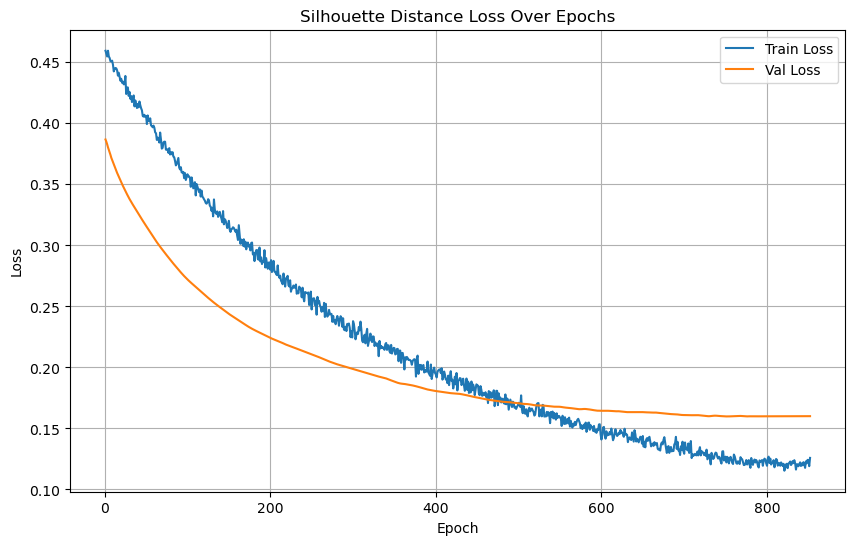

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2312], Loss: 0.0992


Test Batch [20/2312], Loss: 0.1450
Test Batch [30/2312], Loss: 0.5000
Test Batch [40/2312], Loss: 0.0480
Test Batch [50/2312], Loss: 0.5000
Test Batch [60/2312], Loss: 0.5000


Test Batch [70/2312], Loss: 0.5000
Test Batch [80/2312], Loss: 0.1102


Test Batch [90/2312], Loss: 0.5000
Test Batch [100/2312], Loss: 0.0378
Test Batch [110/2312], Loss: 0.5000
Test Batch [120/2312], Loss: 0.0755
Test Batch [130/2312], Loss: 0.5000


Test Batch [140/2312], Loss: 0.5000


Test Batch [150/2312], Loss: 0.5000
Test Batch [160/2312], Loss: 0.0728
Test Batch [170/2312], Loss: 0.5000
Test Batch [180/2312], Loss: 0.5000
Test Batch [190/2312], Loss: 0.5000
Test Batch [200/2312], Loss: 0.0996


Test Batch [210/2312], Loss: 0.5000
Test Batch [220/2312], Loss: 0.5000


Test Batch [230/2312], Loss: 0.1007
Test Batch [240/2312], Loss: 0.5000
Test Batch [250/2312], Loss: 0.0777
Test Batch [260/2312], Loss: 0.5000
Test Batch [270/2312], Loss: 0.5000


Test Batch [280/2312], Loss: 0.5000
Test Batch [290/2312], Loss: 0.0407


Test Batch [300/2312], Loss: 0.1230
Test Batch [310/2312], Loss: 0.5000
Test Batch [320/2312], Loss: 0.0707
Test Batch [330/2312], Loss: 0.5000
Test Batch [340/2312], Loss: 0.5000


Test Batch [350/2312], Loss: 0.0572
Test Batch [360/2312], Loss: 0.1200


Test Batch [370/2312], Loss: 0.1100
Test Batch [380/2312], Loss: 0.0779
Test Batch [390/2312], Loss: 0.0460
Test Batch [400/2312], Loss: 0.5000
Test Batch [410/2312], Loss: 0.0734


Test Batch [420/2312], Loss: 0.0905
Test Batch [430/2312], Loss: 0.1095


Test Batch [440/2312], Loss: 0.5000
Test Batch [450/2312], Loss: 0.0667
Test Batch [460/2312], Loss: 0.5000
Test Batch [470/2312], Loss: 0.0857


Test Batch [480/2312], Loss: 0.0400
Test Batch [490/2312], Loss: 0.5000
Test Batch [500/2312], Loss: 0.0465


Test Batch [510/2312], Loss: 0.5000
Test Batch [520/2312], Loss: 0.1302
Test Batch [530/2312], Loss: 0.5000
Test Batch [540/2312], Loss: 0.5000


Test Batch [550/2312], Loss: 0.0852
Test Batch [560/2312], Loss: 0.5000
Test Batch [570/2312], Loss: 0.5000


Test Batch [580/2312], Loss: 0.0282
Test Batch [590/2312], Loss: 0.0850
Test Batch [600/2312], Loss: 0.5000


Test Batch [610/2312], Loss: 0.5000
Test Batch [620/2312], Loss: 0.0776


Test Batch [630/2312], Loss: 0.0155
Test Batch [640/2312], Loss: 0.0899
Test Batch [650/2312], Loss: 0.5000


Test Batch [660/2312], Loss: 0.0913
Test Batch [670/2312], Loss: 0.0336
Test Batch [680/2312], Loss: 0.5000


Test Batch [690/2312], Loss: 0.5000
Test Batch [700/2312], Loss: 0.0770
Test Batch [710/2312], Loss: 0.0178


Test Batch [720/2312], Loss: 0.5000
Test Batch [730/2312], Loss: 0.0439
Test Batch [740/2312], Loss: 0.5000
Test Batch [750/2312], Loss: 0.0532


Test Batch [760/2312], Loss: 0.1056
Test Batch [770/2312], Loss: 0.5000


Test Batch [780/2312], Loss: 0.5000
Test Batch [790/2312], Loss: 0.0200
Test Batch [800/2312], Loss: 0.0725
Test Batch [810/2312], Loss: 0.5000


Test Batch [820/2312], Loss: 0.1197
Test Batch [830/2312], Loss: 0.5000


Test Batch [840/2312], Loss: 0.0683
Test Batch [850/2312], Loss: 0.1783
Test Batch [860/2312], Loss: 0.0364
Test Batch [870/2312], Loss: 0.1225
Test Batch [880/2312], Loss: 0.5000
Test Batch [890/2312], Loss: 0.5000


Test Batch [900/2312], Loss: 0.5000


Test Batch [910/2312], Loss: 0.5000
Test Batch [920/2312], Loss: 0.0459
Test Batch [930/2312], Loss: 0.0958
Test Batch [940/2312], Loss: 0.0614
Test Batch [950/2312], Loss: 0.5000
Test Batch [960/2312], Loss: 0.5000
Test Batch [970/2312], Loss: 0.5000


Test Batch [980/2312], Loss: 0.0867
Test Batch [990/2312], Loss: 0.0444
Test Batch [1000/2312], Loss: 0.0495
Test Batch [1010/2312], Loss: 0.0216
Test Batch [1020/2312], Loss: 0.1202
Test Batch [1030/2312], Loss: 0.5000


Test Batch [1040/2312], Loss: 0.0433
Test Batch [1050/2312], Loss: 0.0875
Test Batch [1060/2312], Loss: 0.0567
Test Batch [1070/2312], Loss: 0.0685
Test Batch [1080/2312], Loss: 0.0517
Test Batch [1090/2312], Loss: 0.1223


Test Batch [1100/2312], Loss: 0.0952
Test Batch [1110/2312], Loss: 0.1004
Test Batch [1120/2312], Loss: 0.0309
Test Batch [1130/2312], Loss: 0.0291
Test Batch [1140/2312], Loss: 0.5000
Test Batch [1150/2312], Loss: 0.0328


Test Batch [1160/2312], Loss: 0.0837
Test Batch [1170/2312], Loss: 0.0939
Test Batch [1180/2312], Loss: 0.1426
Test Batch [1190/2312], Loss: 0.0287
Test Batch [1200/2312], Loss: 0.1170


Test Batch [1210/2312], Loss: 0.1008
Test Batch [1220/2312], Loss: 0.1407
Test Batch [1230/2312], Loss: 0.1359
Test Batch [1240/2312], Loss: 0.0766
Test Batch [1250/2312], Loss: 0.5000


Test Batch [1260/2312], Loss: 0.0444
Test Batch [1270/2312], Loss: 0.0827
Test Batch [1280/2312], Loss: 0.1783
Test Batch [1290/2312], Loss: 0.5000


Test Batch [1300/2312], Loss: 0.0935
Test Batch [1310/2312], Loss: 0.0903
Test Batch [1320/2312], Loss: 0.1977
Test Batch [1330/2312], Loss: 0.0602


Test Batch [1340/2312], Loss: 0.0246
Test Batch [1350/2312], Loss: 0.1073
Test Batch [1360/2312], Loss: 0.2464
Test Batch [1370/2312], Loss: 0.1204


Test Batch [1380/2312], Loss: 0.1458
Test Batch [1390/2312], Loss: 0.1184
Test Batch [1400/2312], Loss: 0.1153


Test Batch [1410/2312], Loss: 0.1300
Test Batch [1420/2312], Loss: 0.0734
Test Batch [1430/2312], Loss: 0.5000


Test Batch [1440/2312], Loss: 0.1086
Test Batch [1450/2312], Loss: 0.5000
Test Batch [1460/2312], Loss: 0.1099
Test Batch [1470/2312], Loss: 0.0779
Test Batch [1480/2312], Loss: 0.1005


Test Batch [1490/2312], Loss: 0.1314
Test Batch [1500/2312], Loss: 0.5000
Test Batch [1510/2312], Loss: 0.0954
Test Batch [1520/2312], Loss: 0.5000


Test Batch [1530/2312], Loss: 0.0915
Test Batch [1540/2312], Loss: 0.0898
Test Batch [1550/2312], Loss: 0.0639
Test Batch [1560/2312], Loss: 0.1127


Test Batch [1570/2312], Loss: 0.0893
Test Batch [1580/2312], Loss: 0.1285
Test Batch [1590/2312], Loss: 0.1468
Test Batch [1600/2312], Loss: 0.0787


Test Batch [1610/2312], Loss: 0.1163
Test Batch [1620/2312], Loss: 0.2440
Test Batch [1630/2312], Loss: 0.1521
Test Batch [1640/2312], Loss: 0.0993


Test Batch [1650/2312], Loss: 0.0525
Test Batch [1660/2312], Loss: 0.1005
Test Batch [1670/2312], Loss: 0.1356
Test Batch [1680/2312], Loss: 0.1266


Test Batch [1690/2312], Loss: 0.1733
Test Batch [1700/2312], Loss: 0.1198
Test Batch [1710/2312], Loss: 0.0994
Test Batch [1720/2312], Loss: 0.0512
Test Batch [1730/2312], Loss: 0.5000
Test Batch [1740/2312], Loss: 0.5000
Test Batch [1750/2312], Loss: 0.0760


Test Batch [1760/2312], Loss: 0.0887
Test Batch [1770/2312], Loss: 0.0648
Test Batch [1780/2312], Loss: 0.0872
Test Batch [1790/2312], Loss: 0.1015
Test Batch [1800/2312], Loss: 0.0813
Test Batch [1810/2312], Loss: 0.0883


Test Batch [1820/2312], Loss: 0.1161
Test Batch [1830/2312], Loss: 0.0315
Test Batch [1840/2312], Loss: 0.1032
Test Batch [1850/2312], Loss: 0.0897
Test Batch [1860/2312], Loss: 0.0779


Test Batch [1870/2312], Loss: 0.0874
Test Batch [1880/2312], Loss: 0.1158
Test Batch [1890/2312], Loss: 0.0765
Test Batch [1900/2312], Loss: 0.1088


Test Batch [1910/2312], Loss: 0.1304
Test Batch [1920/2312], Loss: 0.1536
Test Batch [1930/2312], Loss: 0.1490
Test Batch [1940/2312], Loss: 0.1007
Test Batch [1950/2312], Loss: 0.0886
Test Batch [1960/2312], Loss: 0.1101


Test Batch [1970/2312], Loss: 0.0936
Test Batch [1980/2312], Loss: 0.0529
Test Batch [1990/2312], Loss: 0.0435
Test Batch [2000/2312], Loss: 0.0514
Test Batch [2010/2312], Loss: 0.0368
Test Batch [2020/2312], Loss: 0.0924


Test Batch [2030/2312], Loss: 0.0471
Test Batch [2040/2312], Loss: 0.0934
Test Batch [2050/2312], Loss: 0.1888
Test Batch [2060/2312], Loss: 0.1284
Test Batch [2070/2312], Loss: 0.1050


Test Batch [2080/2312], Loss: 0.5000
Test Batch [2090/2312], Loss: 0.0966
Test Batch [2100/2312], Loss: 0.1478
Test Batch [2110/2312], Loss: 0.1213
Test Batch [2120/2312], Loss: 0.1818
Test Batch [2130/2312], Loss: 0.0219


Test Batch [2140/2312], Loss: 0.1265
Test Batch [2150/2312], Loss: 0.1799
Test Batch [2160/2312], Loss: 0.5000
Test Batch [2170/2312], Loss: 0.5000
Test Batch [2180/2312], Loss: 0.0659
Test Batch [2190/2312], Loss: 0.5000


Test Batch [2200/2312], Loss: 0.5000
Test Batch [2210/2312], Loss: 0.5000
Test Batch [2220/2312], Loss: 0.1081
Test Batch [2230/2312], Loss: 0.0285
Test Batch [2240/2312], Loss: 0.0918
Test Batch [2250/2312], Loss: 0.0244


Test Batch [2260/2312], Loss: 0.5000
Test Batch [2270/2312], Loss: 0.0834
Test Batch [2280/2312], Loss: 0.5000
Test Batch [2290/2312], Loss: 0.0363
Test Batch [2300/2312], Loss: 0.5000
Test Batch [2310/2312], Loss: 0.5000

Test Loss: 0.2098


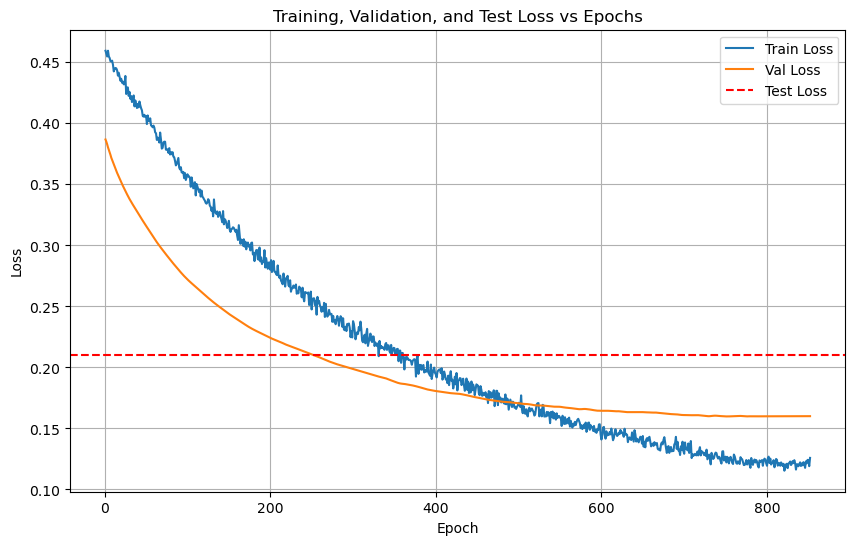

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2312 for test dataset.
  Processed batch 20/2312 for test dataset.
  Processed batch 30/2312 for test dataset.


  Processed batch 40/2312 for test dataset.
  Processed batch 50/2312 for test dataset.
  Processed batch 60/2312 for test dataset.
  Processed batch 70/2312 for test dataset.


  Processed batch 80/2312 for test dataset.
  Processed batch 90/2312 for test dataset.
  Processed batch 100/2312 for test dataset.
  Processed batch 110/2312 for test dataset.


  Processed batch 120/2312 for test dataset.
  Processed batch 130/2312 for test dataset.
  Processed batch 140/2312 for test dataset.


  Processed batch 150/2312 for test dataset.
  Processed batch 160/2312 for test dataset.
  Processed batch 170/2312 for test dataset.
  Processed batch 180/2312 for test dataset.


  Processed batch 190/2312 for test dataset.
  Processed batch 200/2312 for test dataset.
  Processed batch 210/2312 for test dataset.
  Processed batch 220/2312 for test dataset.


  Processed batch 230/2312 for test dataset.
  Processed batch 240/2312 for test dataset.
  Processed batch 250/2312 for test dataset.
  Processed batch 260/2312 for test dataset.


  Processed batch 270/2312 for test dataset.
  Processed batch 280/2312 for test dataset.
  Processed batch 290/2312 for test dataset.
  Processed batch 300/2312 for test dataset.


  Processed batch 310/2312 for test dataset.
  Processed batch 320/2312 for test dataset.
  Processed batch 330/2312 for test dataset.


  Processed batch 340/2312 for test dataset.
  Processed batch 350/2312 for test dataset.
  Processed batch 360/2312 for test dataset.
  Processed batch 370/2312 for test dataset.


  Processed batch 380/2312 for test dataset.
  Processed batch 390/2312 for test dataset.
  Processed batch 400/2312 for test dataset.


  Processed batch 410/2312 for test dataset.
  Processed batch 420/2312 for test dataset.
  Processed batch 430/2312 for test dataset.
  Processed batch 440/2312 for test dataset.


  Processed batch 450/2312 for test dataset.
  Processed batch 460/2312 for test dataset.
  Processed batch 470/2312 for test dataset.
  Processed batch 480/2312 for test dataset.


  Processed batch 490/2312 for test dataset.
  Processed batch 500/2312 for test dataset.
  Processed batch 510/2312 for test dataset.
  Processed batch 520/2312 for test dataset.


  Processed batch 530/2312 for test dataset.
  Processed batch 540/2312 for test dataset.
  Processed batch 550/2312 for test dataset.
  Processed batch 560/2312 for test dataset.


  Processed batch 570/2312 for test dataset.
  Processed batch 580/2312 for test dataset.
  Processed batch 590/2312 for test dataset.
  Processed batch 600/2312 for test dataset.


  Processed batch 610/2312 for test dataset.
  Processed batch 620/2312 for test dataset.
  Processed batch 630/2312 for test dataset.
  Processed batch 640/2312 for test dataset.


  Processed batch 650/2312 for test dataset.
  Processed batch 660/2312 for test dataset.
  Processed batch 670/2312 for test dataset.
  Processed batch 680/2312 for test dataset.


  Processed batch 690/2312 for test dataset.
  Processed batch 700/2312 for test dataset.
  Processed batch 710/2312 for test dataset.
  Processed batch 720/2312 for test dataset.


  Processed batch 730/2312 for test dataset.
  Processed batch 740/2312 for test dataset.
  Processed batch 750/2312 for test dataset.
  Processed batch 760/2312 for test dataset.


  Processed batch 770/2312 for test dataset.
  Processed batch 780/2312 for test dataset.
  Processed batch 790/2312 for test dataset.
  Processed batch 800/2312 for test dataset.


  Processed batch 810/2312 for test dataset.
  Processed batch 820/2312 for test dataset.
  Processed batch 830/2312 for test dataset.
  Processed batch 840/2312 for test dataset.


  Processed batch 850/2312 for test dataset.
  Processed batch 860/2312 for test dataset.
  Processed batch 870/2312 for test dataset.
  Processed batch 880/2312 for test dataset.


  Processed batch 890/2312 for test dataset.
  Processed batch 900/2312 for test dataset.
  Processed batch 910/2312 for test dataset.
  Processed batch 920/2312 for test dataset.


  Processed batch 930/2312 for test dataset.
  Processed batch 940/2312 for test dataset.
  Processed batch 950/2312 for test dataset.
  Processed batch 960/2312 for test dataset.


  Processed batch 970/2312 for test dataset.
  Processed batch 980/2312 for test dataset.
  Processed batch 990/2312 for test dataset.
  Processed batch 1000/2312 for test dataset.


  Processed batch 1010/2312 for test dataset.
  Processed batch 1020/2312 for test dataset.
  Processed batch 1030/2312 for test dataset.
  Processed batch 1040/2312 for test dataset.


  Processed batch 1050/2312 for test dataset.
  Processed batch 1060/2312 for test dataset.
  Processed batch 1070/2312 for test dataset.
  Processed batch 1080/2312 for test dataset.


  Processed batch 1090/2312 for test dataset.
  Processed batch 1100/2312 for test dataset.
  Processed batch 1110/2312 for test dataset.
  Processed batch 1120/2312 for test dataset.


  Processed batch 1130/2312 for test dataset.
  Processed batch 1140/2312 for test dataset.
  Processed batch 1150/2312 for test dataset.


  Processed batch 1160/2312 for test dataset.
  Processed batch 1170/2312 for test dataset.
  Processed batch 1180/2312 for test dataset.
  Processed batch 1190/2312 for test dataset.


  Processed batch 1200/2312 for test dataset.
  Processed batch 1210/2312 for test dataset.
  Processed batch 1220/2312 for test dataset.
  Processed batch 1230/2312 for test dataset.


  Processed batch 1240/2312 for test dataset.
  Processed batch 1250/2312 for test dataset.
  Processed batch 1260/2312 for test dataset.
  Processed batch 1270/2312 for test dataset.


  Processed batch 1280/2312 for test dataset.
  Processed batch 1290/2312 for test dataset.
  Processed batch 1300/2312 for test dataset.
  Processed batch 1310/2312 for test dataset.


  Processed batch 1320/2312 for test dataset.
  Processed batch 1330/2312 for test dataset.
  Processed batch 1340/2312 for test dataset.
  Processed batch 1350/2312 for test dataset.


  Processed batch 1360/2312 for test dataset.
  Processed batch 1370/2312 for test dataset.
  Processed batch 1380/2312 for test dataset.
  Processed batch 1390/2312 for test dataset.


  Processed batch 1400/2312 for test dataset.
  Processed batch 1410/2312 for test dataset.
  Processed batch 1420/2312 for test dataset.
  Processed batch 1430/2312 for test dataset.


  Processed batch 1440/2312 for test dataset.
  Processed batch 1450/2312 for test dataset.
  Processed batch 1460/2312 for test dataset.
  Processed batch 1470/2312 for test dataset.


  Processed batch 1480/2312 for test dataset.
  Processed batch 1490/2312 for test dataset.
  Processed batch 1500/2312 for test dataset.


  Processed batch 1510/2312 for test dataset.
  Processed batch 1520/2312 for test dataset.
  Processed batch 1530/2312 for test dataset.
  Processed batch 1540/2312 for test dataset.


  Processed batch 1550/2312 for test dataset.
  Processed batch 1560/2312 for test dataset.
  Processed batch 1570/2312 for test dataset.
  Processed batch 1580/2312 for test dataset.


  Processed batch 1590/2312 for test dataset.
  Processed batch 1600/2312 for test dataset.
  Processed batch 1610/2312 for test dataset.
  Processed batch 1620/2312 for test dataset.


  Processed batch 1630/2312 for test dataset.
  Processed batch 1640/2312 for test dataset.
  Processed batch 1650/2312 for test dataset.


  Processed batch 1660/2312 for test dataset.
  Processed batch 1670/2312 for test dataset.
  Processed batch 1680/2312 for test dataset.
  Processed batch 1690/2312 for test dataset.


  Processed batch 1700/2312 for test dataset.
  Processed batch 1710/2312 for test dataset.
  Processed batch 1720/2312 for test dataset.


  Processed batch 1730/2312 for test dataset.
  Processed batch 1740/2312 for test dataset.
  Processed batch 1750/2312 for test dataset.
  Processed batch 1760/2312 for test dataset.


  Processed batch 1770/2312 for test dataset.
  Processed batch 1780/2312 for test dataset.
  Processed batch 1790/2312 for test dataset.


  Processed batch 1800/2312 for test dataset.
  Processed batch 1810/2312 for test dataset.
  Processed batch 1820/2312 for test dataset.
  Processed batch 1830/2312 for test dataset.


  Processed batch 1840/2312 for test dataset.
  Processed batch 1850/2312 for test dataset.
  Processed batch 1860/2312 for test dataset.
  Processed batch 1870/2312 for test dataset.


  Processed batch 1880/2312 for test dataset.
  Processed batch 1890/2312 for test dataset.
  Processed batch 1900/2312 for test dataset.
  Processed batch 1910/2312 for test dataset.


  Processed batch 1920/2312 for test dataset.
  Processed batch 1930/2312 for test dataset.
  Processed batch 1940/2312 for test dataset.
  Processed batch 1950/2312 for test dataset.


  Processed batch 1960/2312 for test dataset.
  Processed batch 1970/2312 for test dataset.
  Processed batch 1980/2312 for test dataset.


  Processed batch 1990/2312 for test dataset.
  Processed batch 2000/2312 for test dataset.
  Processed batch 2010/2312 for test dataset.
  Processed batch 2020/2312 for test dataset.


  Processed batch 2030/2312 for test dataset.
  Processed batch 2040/2312 for test dataset.
  Processed batch 2050/2312 for test dataset.
  Processed batch 2060/2312 for test dataset.


  Processed batch 2070/2312 for test dataset.
  Processed batch 2080/2312 for test dataset.
  Processed batch 2090/2312 for test dataset.


  Processed batch 2100/2312 for test dataset.
  Processed batch 2110/2312 for test dataset.
  Processed batch 2120/2312 for test dataset.
  Processed batch 2130/2312 for test dataset.


  Processed batch 2140/2312 for test dataset.
  Processed batch 2150/2312 for test dataset.
  Processed batch 2160/2312 for test dataset.
  Processed batch 2170/2312 for test dataset.


  Processed batch 2180/2312 for test dataset.
  Processed batch 2190/2312 for test dataset.
  Processed batch 2200/2312 for test dataset.
  Processed batch 2210/2312 for test dataset.


  Processed batch 2220/2312 for test dataset.
  Processed batch 2230/2312 for test dataset.
  Processed batch 2240/2312 for test dataset.
  Processed batch 2250/2312 for test dataset.


  Processed batch 2260/2312 for test dataset.
  Processed batch 2270/2312 for test dataset.
  Processed batch 2280/2312 for test dataset.
  Processed batch 2290/2312 for test dataset.


  Processed batch 2300/2312 for test dataset.
  Processed batch 2310/2312 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.80      0.80      0.80         5
           4       0.80      0.80      0.80         5
           5       0.83      1.00      0.91         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45


LOG: Evaluating on the test set...
Test Accuracy: 96.11%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65946
           1       0.96      0.85      0.90      7573
           2       0.69      0.89      0.78      3065
           3       0.64      0.86      0.73      2660
           4       0.83      0.88      0.86      6559
           5       0.86      0.96      0.91      9223
           6       0.95      0.83      0.89      7262
           7       1.00      0.97      0.98     42801
           8       1.00      1.00      1.00      2838

    accuracy                           0.96    147927
   macro avg       0.88      0.92      0.89    147927
weighted avg       0.97      0.96      0.96    147927

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7642  |  Val Loss: 2.6574
Validation loss improved from inf to 2.6574.
[Epoch 2/1000] Train Loss: 2.6718  |  Val Loss: 2.5766
Validation loss improved from 2.6574 to 2.5766.
[Epoch 3/1000] Train Loss: 2.5829  |  Val Loss: 2.5006
Validation loss improved from 2.5766 to 2.5006.
[Epoch 4/1000] Train Loss: 2.5021  |  Val Loss: 2.4285
Validation loss improved from 2.5006 to 2.4285.
[Epoch 5/1000] Train Loss: 2.4225  |  Val Loss: 2.3608
Validation loss improved from 2.4285 to 2.3608.
[Epoch 6/1000] Train Loss: 2.3466  |  Val Loss: 2.2967
Validation loss improved from 2.3608 to 2.2967.
[Epoch 7/1000] Train Loss: 2.2757  |  Val Loss: 2.2349
Validation loss improved from 2.2967 to 2.2349.
[Epoch 8/1000] Train Loss: 2.2091  |  Val Loss: 2.1754
Validation loss improved from 2.2349 to 2.1754.
[Epoch 9/1000] Train Loss: 2.1443  |  Val Loss: 2.1189
Validation loss improved from 2.1754 to 2.1189.
[Epoch 10/1000] Train Loss: 2.0838  |  Val Loss: 2.0655
Validation loss impr

[Epoch 26/1000] Train Loss: 1.3950  |  Val Loss: 1.4508
Validation loss improved from 1.4783 to 1.4508.


[Epoch 27/1000] Train Loss: 1.3651  |  Val Loss: 1.4243
Validation loss improved from 1.4508 to 1.4243.
[Epoch 28/1000] Train Loss: 1.3358  |  Val Loss: 1.3984
Validation loss improved from 1.4243 to 1.3984.
[Epoch 29/1000] Train Loss: 1.3090  |  Val Loss: 1.3733
Validation loss improved from 1.3984 to 1.3733.
[Epoch 30/1000] Train Loss: 1.2818  |  Val Loss: 1.3488
Validation loss improved from 1.3733 to 1.3488.
[Epoch 31/1000] Train Loss: 1.2563  |  Val Loss: 1.3247
Validation loss improved from 1.3488 to 1.3247.
[Epoch 32/1000] Train Loss: 1.2305  |  Val Loss: 1.3012
Validation loss improved from 1.3247 to 1.3012.
[Epoch 33/1000] Train Loss: 1.2061  |  Val Loss: 1.2783
Validation loss improved from 1.3012 to 1.2783.
[Epoch 34/1000] Train Loss: 1.1813  |  Val Loss: 1.2561
Validation loss improved from 1.2783 to 1.2561.
[Epoch 35/1000] Train Loss: 1.1578  |  Val Loss: 1.2343
Validation loss improved from 1.2561 to 1.2343.
[Epoch 36/1000] Train Loss: 1.1345  |  Val Loss: 1.2128
Validati

[Epoch 56/1000] Train Loss: 0.7422  |  Val Loss: 0.8570
Validation loss improved from 0.8716 to 0.8570.
[Epoch 57/1000] Train Loss: 0.7265  |  Val Loss: 0.8427
Validation loss improved from 0.8570 to 0.8427.
[Epoch 58/1000] Train Loss: 0.7110  |  Val Loss: 0.8284
Validation loss improved from 0.8427 to 0.8284.
[Epoch 59/1000] Train Loss: 0.6958  |  Val Loss: 0.8144
Validation loss improved from 0.8284 to 0.8144.
[Epoch 60/1000] Train Loss: 0.6809  |  Val Loss: 0.8007
Validation loss improved from 0.8144 to 0.8007.
[Epoch 61/1000] Train Loss: 0.6662  |  Val Loss: 0.7873
Validation loss improved from 0.8007 to 0.7873.
[Epoch 62/1000] Train Loss: 0.6519  |  Val Loss: 0.7740
Validation loss improved from 0.7873 to 0.7740.
[Epoch 63/1000] Train Loss: 0.6376  |  Val Loss: 0.7610
Validation loss improved from 0.7740 to 0.7610.
[Epoch 64/1000] Train Loss: 0.6237  |  Val Loss: 0.7482
Validation loss improved from 0.7610 to 0.7482.
[Epoch 65/1000] Train Loss: 0.6103  |  Val Loss: 0.7355
Validati

[Epoch 88/1000] Train Loss: 0.3564  |  Val Loss: 0.5105
Validation loss improved from 0.5178 to 0.5105.
[Epoch 89/1000] Train Loss: 0.3476  |  Val Loss: 0.5034
Validation loss improved from 0.5105 to 0.5034.
[Epoch 90/1000] Train Loss: 0.3393  |  Val Loss: 0.4964
Validation loss improved from 0.5034 to 0.4964.
[Epoch 91/1000] Train Loss: 0.3309  |  Val Loss: 0.4897
Validation loss improved from 0.4964 to 0.4897.
[Epoch 92/1000] Train Loss: 0.3229  |  Val Loss: 0.4831
Validation loss improved from 0.4897 to 0.4831.
[Epoch 93/1000] Train Loss: 0.3152  |  Val Loss: 0.4767
Validation loss improved from 0.4831 to 0.4767.
[Epoch 94/1000] Train Loss: 0.3073  |  Val Loss: 0.4704
Validation loss improved from 0.4767 to 0.4704.
[Epoch 95/1000] Train Loss: 0.2999  |  Val Loss: 0.4643
Validation loss improved from 0.4704 to 0.4643.
[Epoch 96/1000] Train Loss: 0.2926  |  Val Loss: 0.4583
Validation loss improved from 0.4643 to 0.4583.
[Epoch 97/1000] Train Loss: 0.2853  |  Val Loss: 0.4525
Validati

[Epoch 118/1000] Train Loss: 0.1725  |  Val Loss: 0.3638
Validation loss improved from 0.3666 to 0.3638.
[Epoch 119/1000] Train Loss: 0.1685  |  Val Loss: 0.3610
Validation loss improved from 0.3638 to 0.3610.
[Epoch 120/1000] Train Loss: 0.1647  |  Val Loss: 0.3582
Validation loss improved from 0.3610 to 0.3582.
[Epoch 121/1000] Train Loss: 0.1610  |  Val Loss: 0.3556
Validation loss improved from 0.3582 to 0.3556.
[Epoch 122/1000] Train Loss: 0.1573  |  Val Loss: 0.3531
Validation loss improved from 0.3556 to 0.3531.
[Epoch 123/1000] Train Loss: 0.1539  |  Val Loss: 0.3507
Validation loss improved from 0.3531 to 0.3507.
[Epoch 124/1000] Train Loss: 0.1503  |  Val Loss: 0.3484
Validation loss improved from 0.3507 to 0.3484.
[Epoch 125/1000] Train Loss: 0.1471  |  Val Loss: 0.3462
Validation loss improved from 0.3484 to 0.3462.
[Epoch 126/1000] Train Loss: 0.1438  |  Val Loss: 0.3441
Validation loss improved from 0.3462 to 0.3441.
[Epoch 127/1000] Train Loss: 0.1407  |  Val Loss: 0.342

[Epoch 150/1000] Train Loss: 0.0882  |  Val Loss: 0.3098
Validation loss improved from 0.3108 to 0.3098.
[Epoch 151/1000] Train Loss: 0.0866  |  Val Loss: 0.3090
Validation loss improved from 0.3098 to 0.3090.
[Epoch 152/1000] Train Loss: 0.0851  |  Val Loss: 0.3082
Validation loss improved from 0.3090 to 0.3082.
[Epoch 153/1000] Train Loss: 0.0836  |  Val Loss: 0.3074
Validation loss improved from 0.3082 to 0.3074.
[Epoch 154/1000] Train Loss: 0.0820  |  Val Loss: 0.3066
Validation loss improved from 0.3074 to 0.3066.
[Epoch 155/1000] Train Loss: 0.0806  |  Val Loss: 0.3058
Validation loss improved from 0.3066 to 0.3058.
[Epoch 156/1000] Train Loss: 0.0792  |  Val Loss: 0.3050
Validation loss improved from 0.3058 to 0.3050.
[Epoch 157/1000] Train Loss: 0.0778  |  Val Loss: 0.3043
Validation loss improved from 0.3050 to 0.3043.
[Epoch 158/1000] Train Loss: 0.0764  |  Val Loss: 0.3036
Validation loss improved from 0.3043 to 0.3036.
[Epoch 159/1000] Train Loss: 0.0751  |  Val Loss: 0.303

[Epoch 181/1000] Train Loss: 0.0529  |  Val Loss: 0.2936
Validation loss improved from 0.2939 to 0.2936.
[Epoch 182/1000] Train Loss: 0.0521  |  Val Loss: 0.2934
Validation loss improved from 0.2936 to 0.2934.
[Epoch 183/1000] Train Loss: 0.0514  |  Val Loss: 0.2931
Validation loss improved from 0.2934 to 0.2931.
[Epoch 184/1000] Train Loss: 0.0506  |  Val Loss: 0.2929
Validation loss improved from 0.2931 to 0.2929.
[Epoch 185/1000] Train Loss: 0.0499  |  Val Loss: 0.2926
Validation loss improved from 0.2929 to 0.2926.
[Epoch 186/1000] Train Loss: 0.0492  |  Val Loss: 0.2925
Validation loss improved from 0.2926 to 0.2925.
[Epoch 187/1000] Train Loss: 0.0485  |  Val Loss: 0.2924
Validation loss improved from 0.2925 to 0.2924.
[Epoch 188/1000] Train Loss: 0.0478  |  Val Loss: 0.2922
Validation loss improved from 0.2924 to 0.2922.
[Epoch 189/1000] Train Loss: 0.0472  |  Val Loss: 0.2920
Validation loss improved from 0.2922 to 0.2920.
[Epoch 190/1000] Train Loss: 0.0465  |  Val Loss: 0.291

[Epoch 214/1000] Train Loss: 0.0341  |  Val Loss: 0.2904
Validation loss improved from 0.2904 to 0.2904.
[Epoch 215/1000] Train Loss: 0.0337  |  Val Loss: 0.2904
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 0.0333  |  Val Loss: 0.2905
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 217/1000] Train Loss: 0.0329  |  Val Loss: 0.2904
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 218/1000] Train Loss: 0.0325  |  Val Loss: 0.2904
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 219/1000] Train Loss: 0.0321  |  Val Loss: 0.2905
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 220/1000] Train Loss: 0.0317  |  Val Loss: 0.2905
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 221/1000] Train Loss: 0.0314  |  Val Loss: 0.2906
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 222/1000] Train Loss: 0.0310  |  Val Loss: 0.2906
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 246/1000] Train Loss: 0.0238  |  Val Loss: 0.2929
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 247/1000] Train Loss: 0.0236  |  Val Loss: 0.2930
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 248/1000] Train Loss: 0.0233  |  Val Loss: 0.2931
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 249/1000] Train Loss: 0.0231  |  Val Loss: 0.2933
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 250/1000] Train Loss: 0.0229  |  Val Loss: 0.2934
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 251/1000] Train Loss: 0.0227  |  Val Loss: 0.2935
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 252/1000] Train Loss: 0.0224  |  Val Loss: 0.2936
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 253/1000] Train Loss: 0.0222  |  Val Loss: 0.2938
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 254/1000] Train Loss: 0.0220  |  Val Loss: 0.2939
!! Validation loss did NOT improve !! Patience:

[Epoch 278/1000] Train Loss: 0.0175  |  Val Loss: 0.2984
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 279/1000] Train Loss: 0.0174  |  Val Loss: 0.2985
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 280/1000] Train Loss: 0.0172  |  Val Loss: 0.2987
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 281/1000] Train Loss: 0.0171  |  Val Loss: 0.2988
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 282/1000] Train Loss: 0.0169  |  Val Loss: 0.2990
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 283/1000] Train Loss: 0.0168  |  Val Loss: 0.2991
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 284/1000] Train Loss: 0.0166  |  Val Loss: 0.2993
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 285/1000] Train Loss: 0.0165  |  Val Loss: 0.2995
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 286/1000] Train Loss: 0.0163  |  Val Loss: 0.2997
!! Validation loss did NOT improve !! Patience:

[Epoch 307/1000] Train Loss: 0.0137  |  Val Loss: 0.3036
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 308/1000] Train Loss: 0.0136  |  Val Loss: 0.3038
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 309/1000] Train Loss: 0.0135  |  Val Loss: 0.3040
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 310/1000] Train Loss: 0.0134  |  Val Loss: 0.3041
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 311/1000] Train Loss: 0.0133  |  Val Loss: 0.3044
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 312/1000] Train Loss: 0.0132  |  Val Loss: 0.3046
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 313/1000] Train Loss: 0.0131  |  Val Loss: 0.3048
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 314/1000] Train Loss: 0.0130  |  Val Loss: 0.3049
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 314 !!
No improvement for 100 epochs.


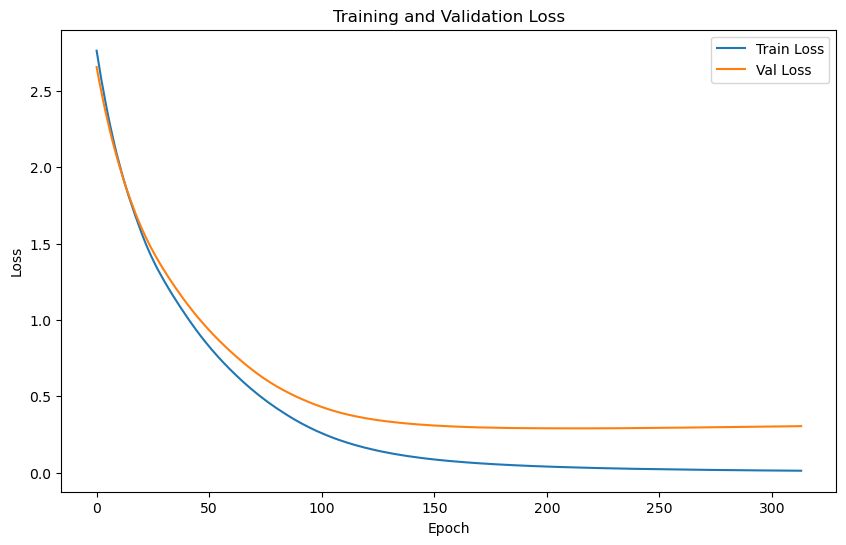

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.1846 | Test Accuracy: 96.30%


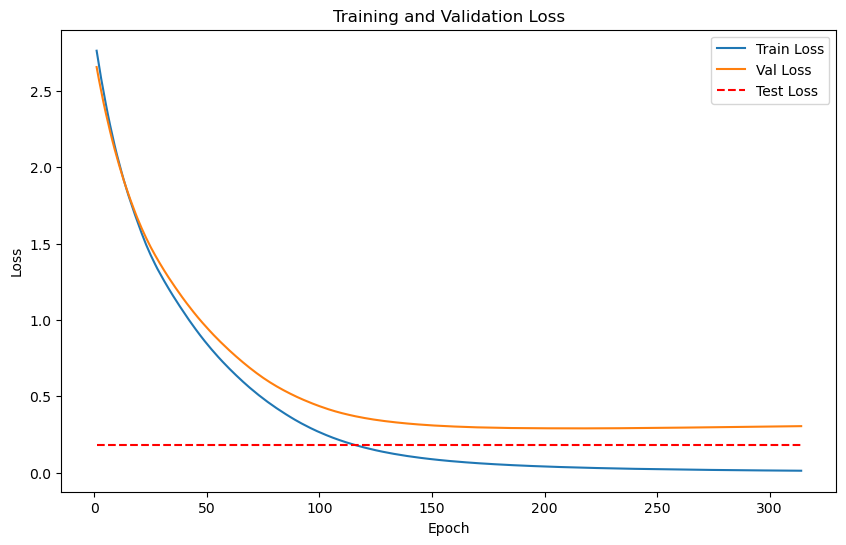

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


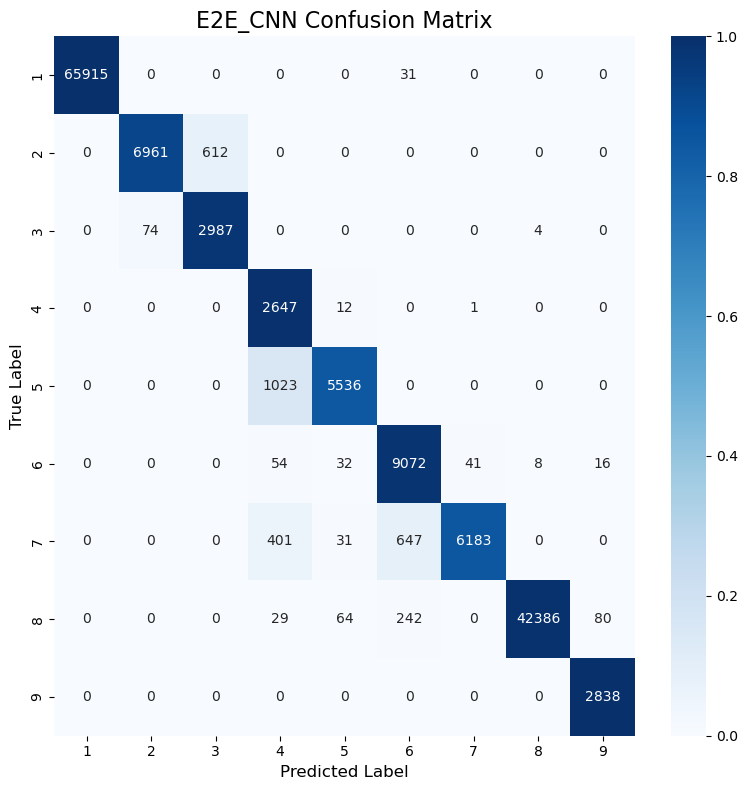

Classification Accuracy: 97.70%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


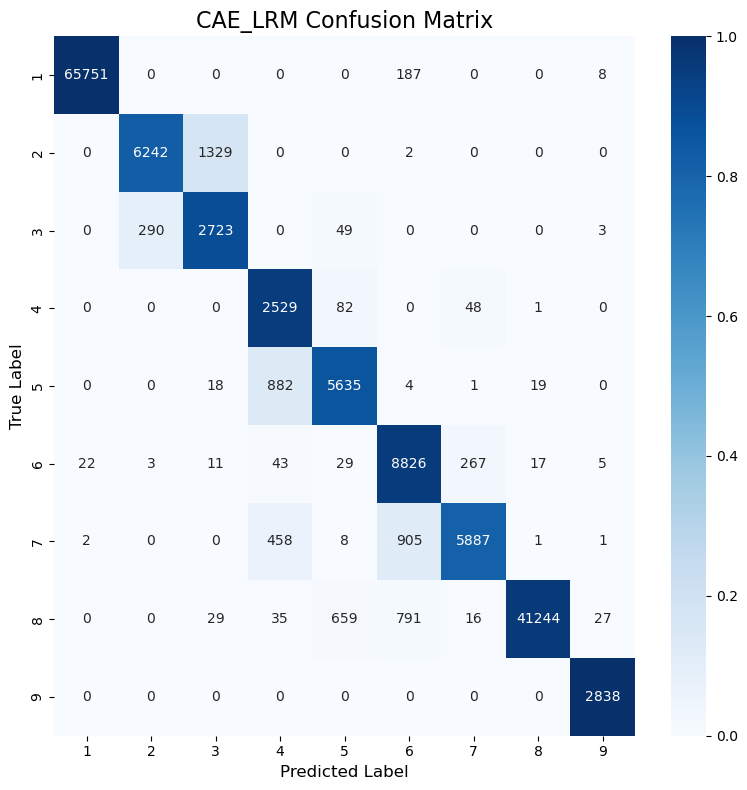

Classification Accuracy: 95.77%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


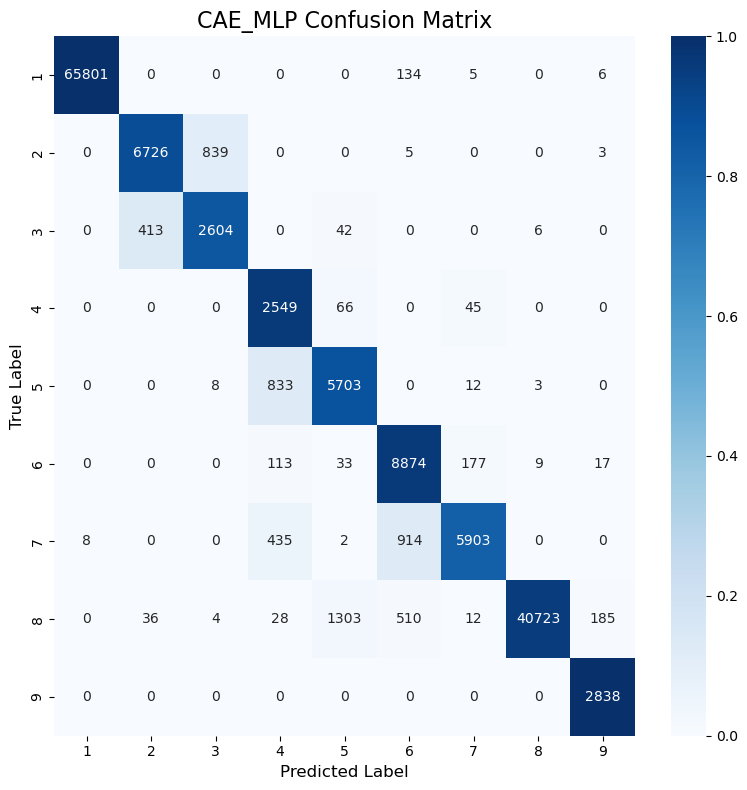

Classification Accuracy: 95.80%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


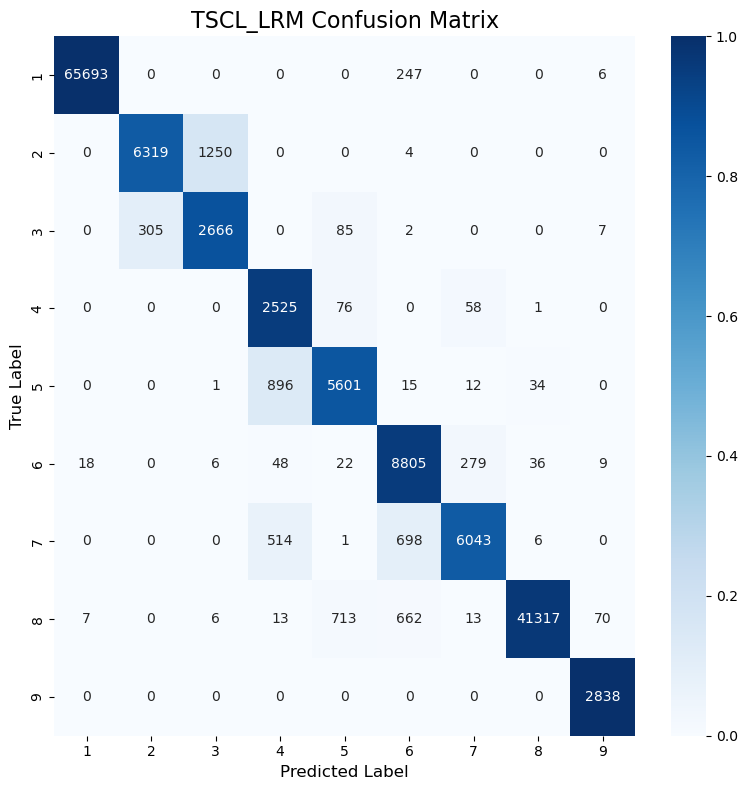

Classification Accuracy: 95.86%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


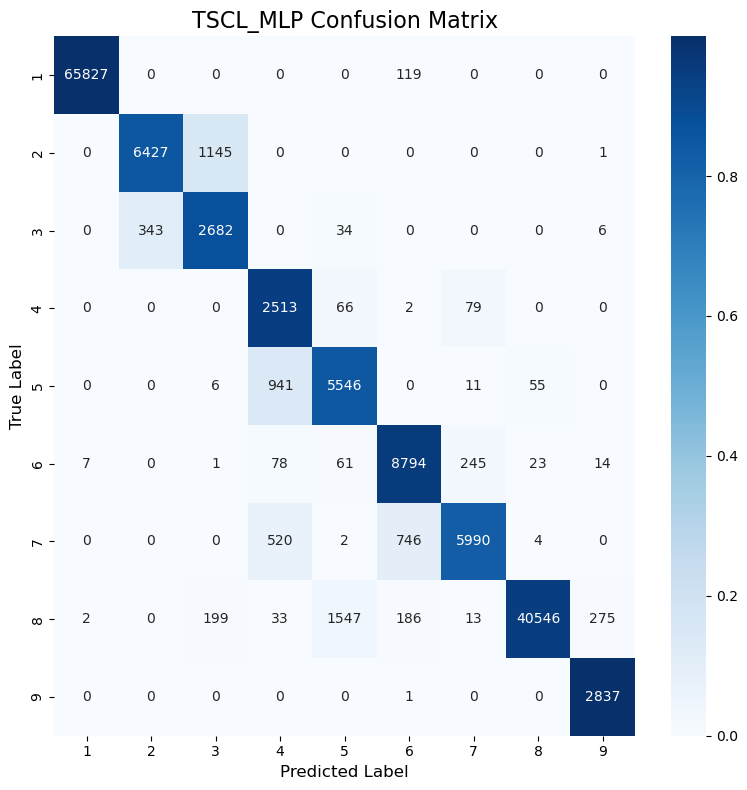

Classification Accuracy: 95.43%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


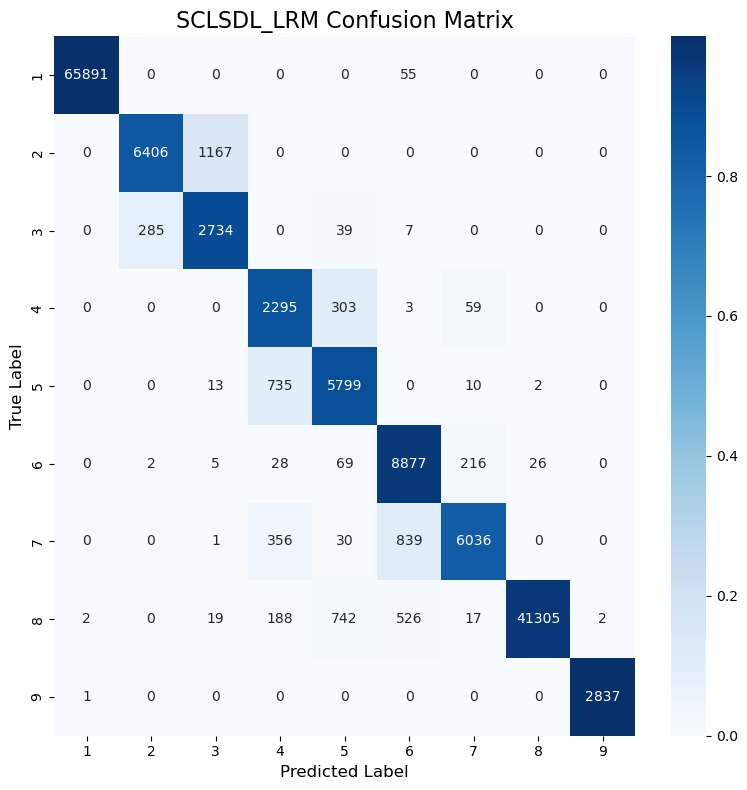

Classification Accuracy: 96.11%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


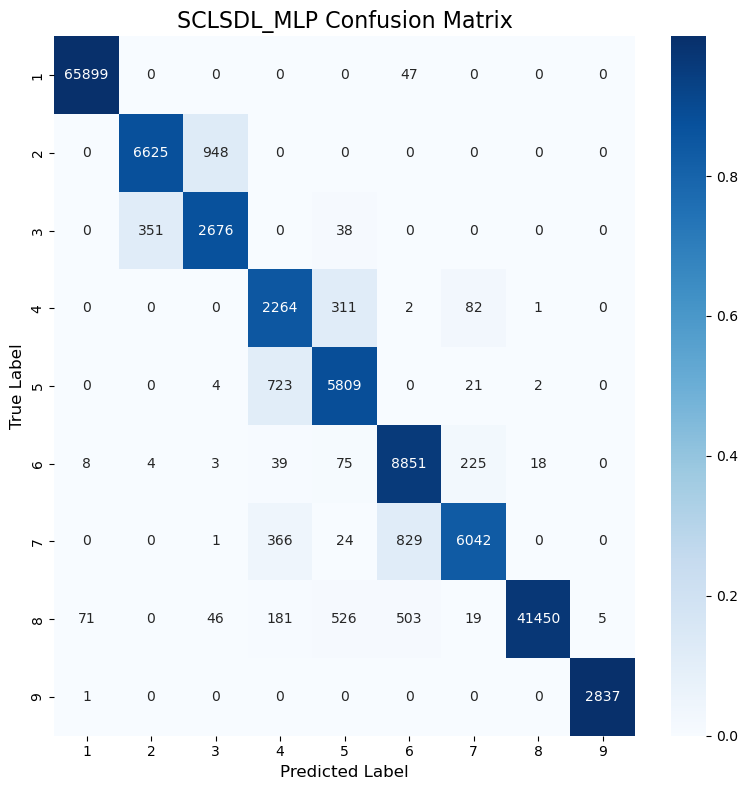

Classification Accuracy: 96.30%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.70
1    LRM (CAE)          95.77
2    MLP (CAE)          95.80
3     TSCL LRM          95.86
4     TSCL MLP          95.43
5  SCL_SDL LRM          96.11
6  SCL_SDL MLP          96.30

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.70
6  SCL_SDL MLP          96.30
5  SCL_SDL LRM          96.11
3     TSCL LRM          95.86
2    MLP (CAE)          95.80
1    LRM (CAE)          95.77
4     TSCL MLP          95.43
